# Predição de Precos de Carros Usados

Este notebook foi desenvolvido como parte do [Desafio Kaggle para Predição de Carros Usados](https://www.kaggle.com/competitions/playground-series-s4e9/overview). O objetivo deste desafio é prever o preço de um carro dado um conjunto de atributos.

Para avaliar a eficacia dos modelos de regressão, foi utilizada a função de Erro Quadrático Médio (RMSE).

$$
\text{RMSE} = \sqrt{\frac{1}{N} \sum_{i=1}^{N} (y_i - \hat{y}_i)^2}
$$

# Índice

- [1 - Importando-Bibliotecas](#1_Importando_Bibliotecas)
- [2 - Importando Dados](#2_Importando_Dados)
- [3 - Análise Exploratória de Dados](#3_Analise_Exploratoria-Dados)
- [5 - Tratamento dos Dados](#5_Tratamento_Dados)
- [6 - Treinamento dos Modelos](#6_Treinamento_Dos_Modelos)
- [7 - Calibrando os modelos](#7_Calibrando_os_modelos)
- [8 - Avaliando os modelos](#8_Avaliando_os_modelos)

In [2]:
try:
    from google.colab import drive
    drive.mount('/content/drive')
    IN_COLAB = True
    print("Está no google colab")
except:
    IN_COLAB = False
    print("Não está no google colab")

Não está no google colab


# 1_Importando_Bibliotecas

In [3]:
if IN_COLAB:
    !pip install -r /content/drive/Othercomputers/Meu-laptop/binary_prediction_poisonous_mushrooms/requirements.txt

In [48]:
import pandas as pd
#import kaggle
#from kaggle.api.kaggle_api_extended import KaggleApi
from sklearn.model_selection import train_test_split
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import numpy as np
import pickle
from pickle import UnpicklingError
import sys
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import datetime

# Tratamentos
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline

# Treinamento
import keras
import keras_tuner
from keras import layers
from skopt import BayesSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

##Avaliacao
from sklearn.metrics import r2_score, root_mean_squared_error

## Calibracao

from venn_abers import VennAbersCalibrator
from sklearn.base import BaseEstimator, RegressorMixin

In [5]:
import sys
sys.path.append('/home/vscode/.local/lib/python3.10/site-packages')
from feature_engine.transformation import LogCpTransformer, YeoJohnsonTransformer, BoxCoxTransformer

In [6]:
plt.style.use("ggplot")
%matplotlib inline
warnings.filterwarnings("ignore")
#pd.set_option('display.max_rows', None)

# 2_Importando_Dados

In [334]:
if IN_COLAB:
    sys.path.append("/content/drive/Othercomputers/Meu-laptop/binary_prediction_poisonous_mushrooms/dados")

    # Verifica os arquivos dentro da pasta 'dados'
    arquivos = os.listdir("/content/drive/Othercomputers/Meu-laptop/binary_prediction_poisonous_mushrooms/dados")

    diretorio = '/content/drive/Othercomputers/Meu-laptop/binary_prediction_poisonous_mushrooms/dados'


else:
    # Adiciona o caminho da pasta 'dados' ao sys.path
    sys.path.append("dados")

    # Verifica os arquivos dentro da pasta 'dados'
    arquivos = os.listdir("dados")

    diretorio = 'dados'

if "train_split.csv" not in arquivos or "test_split.csv" not in arquivos:
    dados = pd.read_csv(diretorio + "/train.csv")
    train, test  = train_test_split(dados, test_size=0.2)
    train.to_csv(diretorio + "/train_split.csv", index=False)
    test.to_csv(diretorio + "/test_split.csv", index=False)
    predict = pd.read_csv(diretorio + "/test.csv")

else:
    train = pd.read_csv(diretorio + "/train_split.csv")
    test = pd.read_csv(diretorio + "/test_split.csv")
    predict = pd.read_csv(diretorio + "/test.csv")

# 3_Analise_Exploratoria-Dados

Retirando o `id` dados de test e train

In [335]:
id_train = train["id"]
id_test = test["id"]
train.drop("id", axis=1, inplace=True)
test.drop("id", axis=1, inplace=True)
print(train.head())
test.head()

  brand             model  model_year  milage fuel_type  \
0   BMW      X1 sDrive28i        2021   13900  Gasoline   
1   BMW  650 Gran Coupe i        2013   98658  Gasoline   
2   Kia     Sorento LX V6        2019   42479  Gasoline   
3  Land  Rover Defender X        2023    4283  Gasoline   
4  Ford         F-150 XLT        2019   35580  Gasoline   

                                          engine  \
0   228.0HP 2.0L 4 Cylinder Engine Gasoline Fuel   
1   445.0HP 4.4L 8 Cylinder Engine Gasoline Fuel   
2                           3.3L V6 24V GDI DOHC   
3              5.0L V8 32V GDI DOHC Supercharged   
4  325.0HP 2.7L V6 Cylinder Engine Gasoline Fuel   

                     transmission      ext_col      int_col  \
0  Transmission w/Dual Shift Mode         Gray        Brown   
1  Transmission w/Dual Shift Mode        White        Black   
2               6-Speed Automatic        Black  Satin Black   
3               8-Speed Automatic  Firenze Red        Black   
4                

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,Land,Rover Discovery LSE,2004,123921,Gasoline,217.0HP 4.6L 8 Cylinder Engine Gasoline Fuel,A/T,Green,Beige,None reported,Yes,6399
1,Lexus,GX 460 Base,2012,212500,Gasoline,301.0HP 4.6L 8 Cylinder Engine Gasoline Fuel,A/T,Black,Beige,At least 1 accident or damage reported,NaN,17599
2,Ford,Mustang GT,1996,130000,Gasoline,300.0HP 5.4L 8 Cylinder Engine Gasoline Fuel,4-Speed A/T,Red,Gray,At least 1 accident or damage reported,Yes,10500
3,Land,Rover Range Rover Sport Supercharged,2007,118500,Gasoline,300.0HP 4.2L 8 Cylinder Engine Gasoline Fuel,6-Speed A/T,Beige,Beige,None reported,Yes,9950
4,Ford,F-150 XLT,2019,69800,Gasoline,375.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,A/T,Gray,Black,None reported,Yes,28500


In [336]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150826 entries, 0 to 150825
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   brand         150826 non-null  object
 1   model         150826 non-null  object
 2   model_year    150826 non-null  int64 
 3   milage        150826 non-null  int64 
 4   fuel_type     146781 non-null  object
 5   engine        150826 non-null  object
 6   transmission  150826 non-null  object
 7   ext_col       150826 non-null  object
 8   int_col       150826 non-null  object
 9   accident      148843 non-null  object
 10  clean_title   133728 non-null  object
 11  price         150826 non-null  int64 
dtypes: int64(3), object(9)
memory usage: 13.8+ MB


In [337]:
train.describe()

,model_year,milage,price
count,150826.000000,150826.000000,1.508260e+05
mean,2015.818473,65779.113422,4.363719e+04
std,5.665087,49769.913223,7.586056e+04
min,1974.000000,100.000000,2.000000e+03
25%,2013.000000,24213.000000,1.700000e+04
50%,2017.000000,57800.000000,3.075000e+04
75%,2020.000000,95500.000000,4.990000e+04
max,2024.000000,405000.000000,2.954083e+06


In [338]:
train.columns

Index(['brand', 'model', 'model_year', 'milage', 'fuel_type', 'engine',
       'transmission', 'ext_col', 'int_col', 'accident', 'clean_title',
       'price'],
      dtype='object')

**Primeiro, verificamos a quantidade de valores faltantes por coluna.**

Identificamos que três colunas possuem valores faltantes:

- A coluna `clean_title` possui 11% de valores faltantes.
- A coluna `fuel_type` possui 3% de valores faltantes.
- A coluna `accident` possui 1% de valores faltantes.
"""

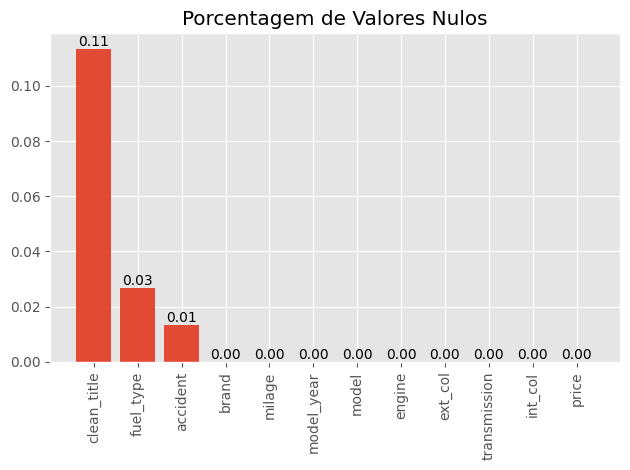

In [339]:
# Calcula a porcentagem de valores nulos
valor_nul = (train.isnull().sum() / train.shape[0]).sort_values(ascending=False)

# Cria os subplots
# Subplot para 'train'
plt.bar(valor_nul.index, valor_nul.values)
plt.title("Porcentagem de Valores Nulos")
plt.tick_params(axis="x", rotation=90)
for index, value in enumerate(valor_nul.values):
    plt.text(index, value, f"{value:.2f}", ha="center", va="bottom")

# Ajusta o layout para evitar sobreposição
plt.tight_layout()

# Exibe os gráficos
plt.show()

**Agora, verificamos as colunas numericas**

- A coluna `model_year` contém os anos de fabricação dos carros. Ao analisá-la, observa-se uma grande concentração de veículos fabricados entre os anos de 2010 e 2023, sendo o ano de 2021 o mais frequente. O ano mais antigo registrado é 1974.

- A coluna `milage`, que representa a quilometragem dos veículos, apresenta uma distribuição assimétrica, com maior concentração de valores à esquerda. No boxplot, a maioria dos valores está entre 24 mil e 95,5 mil quilômetros, com o terceiro quartil indicando o valor mais elevado. Aproximadamente 0,92% dos dados são considerados outliers. A diferença entre a média e a mediana é de 12,13%

- A coluna `price`, que é o alvo da predição, possui a maioria dos valores entre 17 mil e 49 mil. A porcentagem de outliers é de 5,72%. A diferença entre a média e a mediana é de 29,53%.


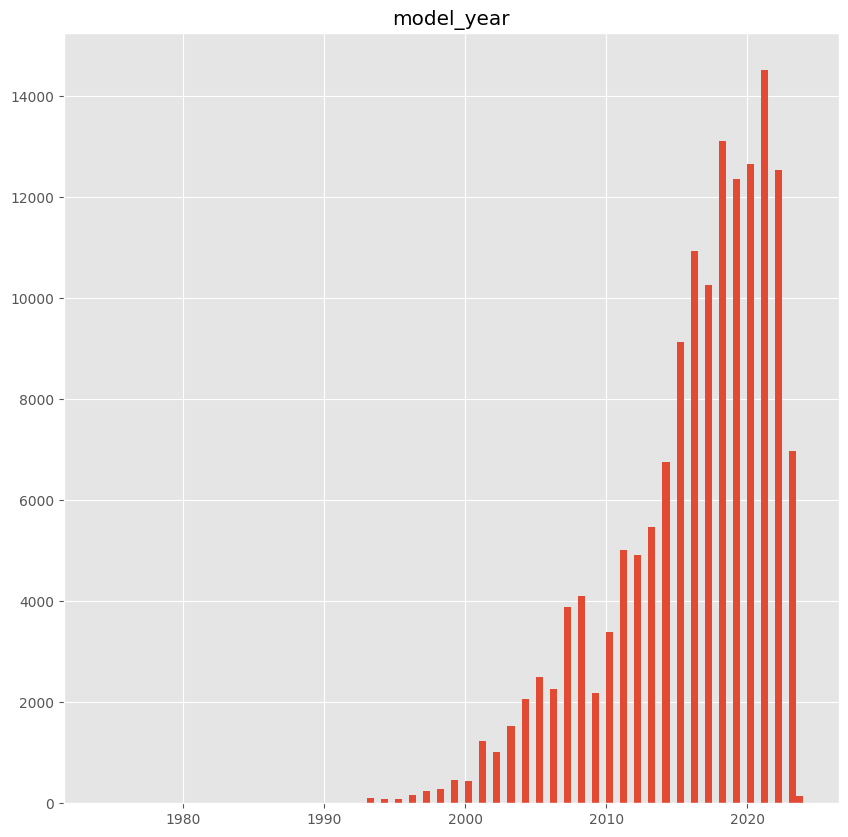

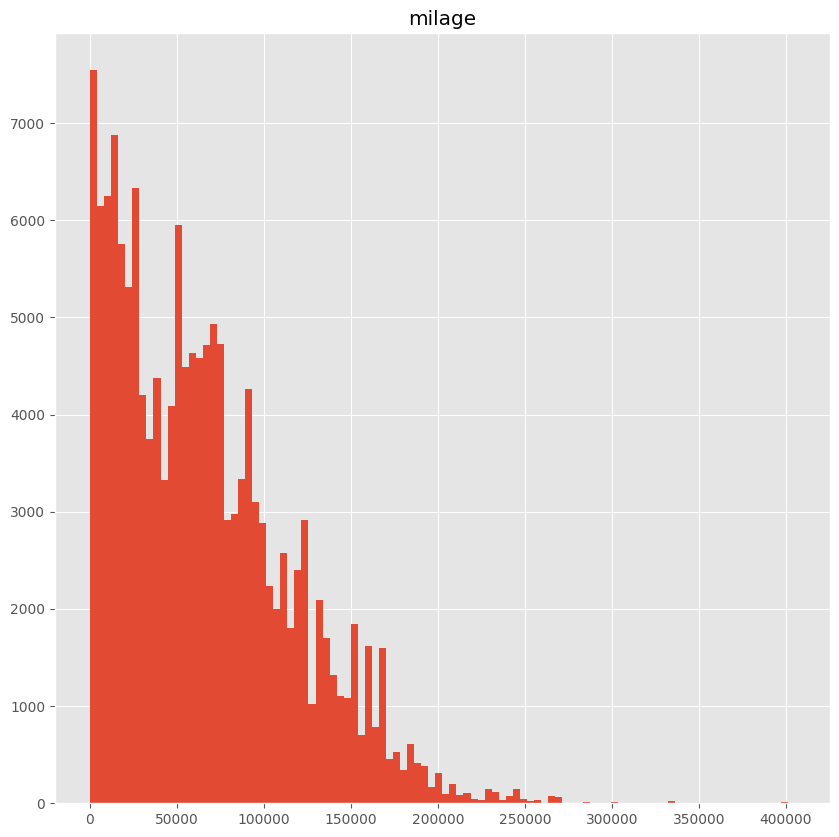

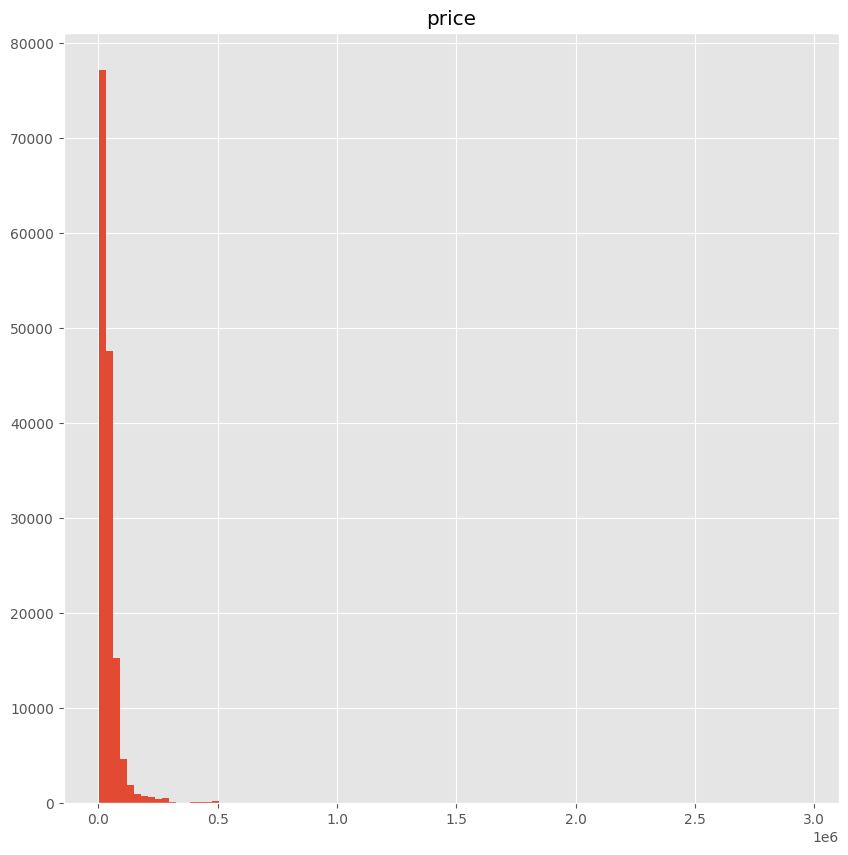

In [340]:
## plot histograma dos valores numericos
for col in train.columns:
    if train[col].dtype == "float64" or train[col].dtype == "int64":
        plt.figure(figsize=(10, 10))
        train[col].hist(bins=100)
        plt.title(col)
        plt.show()
        plt.close()

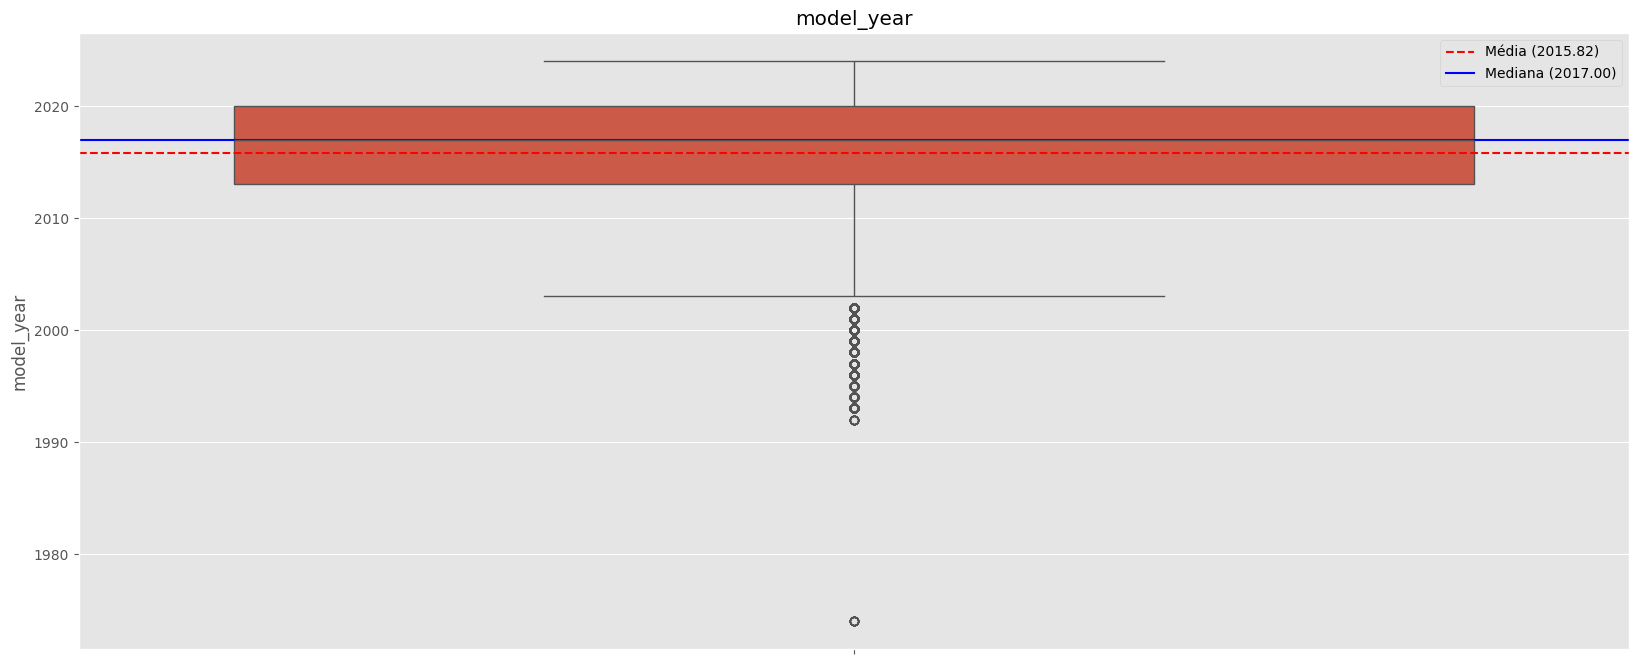

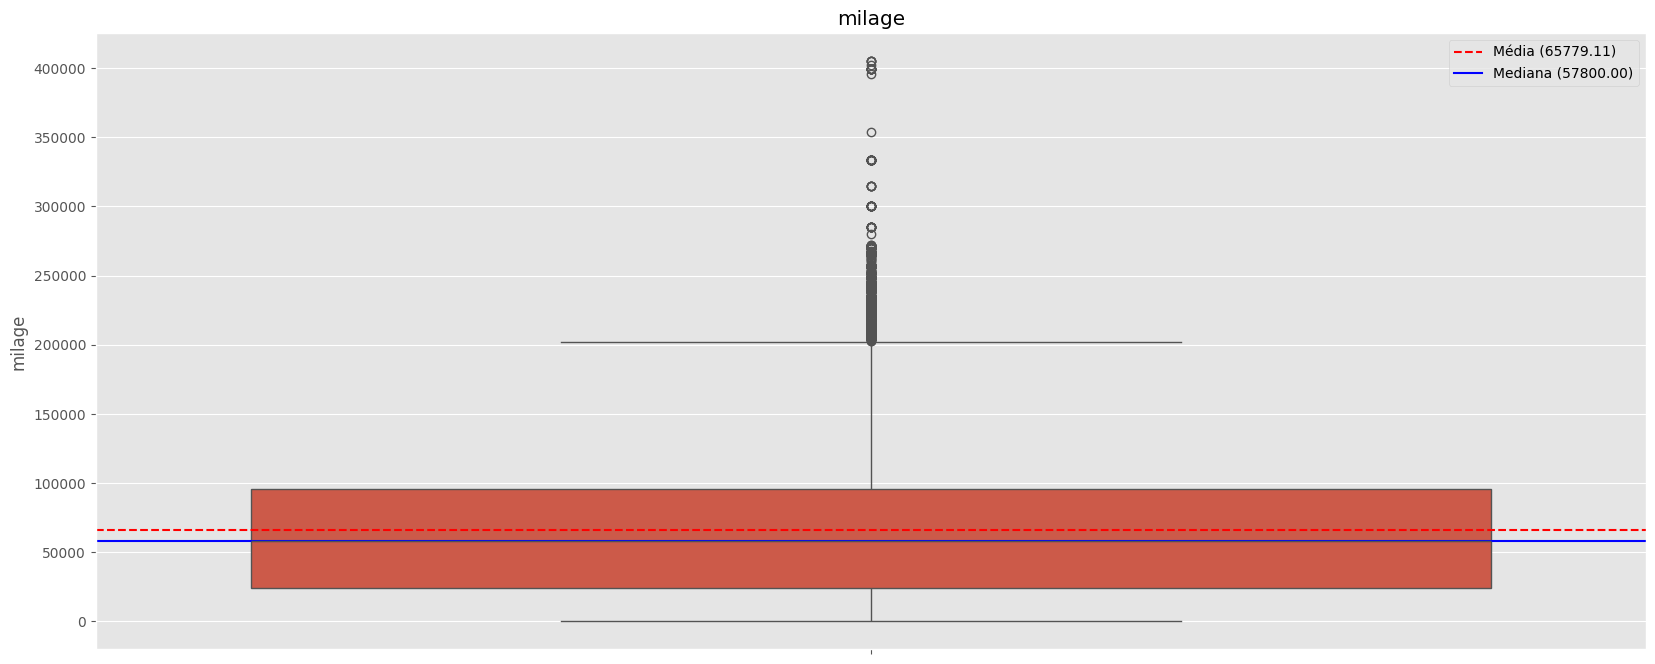

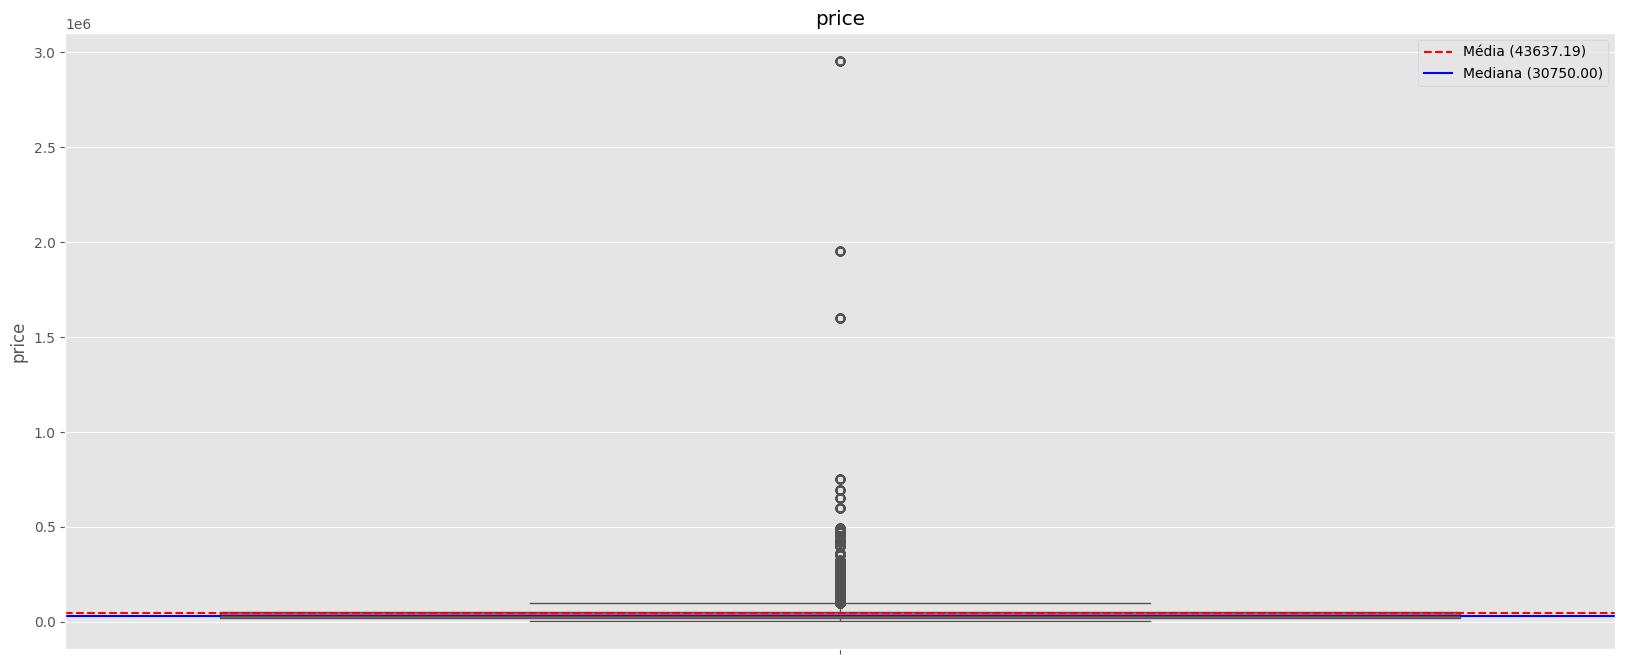

In [341]:
for col in train.columns:
    if train[col].dtype == "float64" or train[col].dtype == "int64":
        mean_value = train[col].mean()
        median_value = train[col].median()
        plt.figure(figsize=(20, 8))
        sns.boxplot(train[col],showfliers=True)
        plt.title(f"{col}")
        plt.axhline(
            y=mean_value, color="red", linestyle="--", label=f"Média ({mean_value:.2f})"
        )
        plt.axhline(
            y=median_value,
            color="blue",
            linestyle="-",
            label=f"Mediana ({median_value:.2f})",
        )
        plt.legend()
        plt.show()

In [342]:
# difernca percentual entre a media e a mediana
for col in train.columns:
    if train[col].dtype == "float64" or train[col].dtype == "int64":
        mean_value = train[col].mean()
        median_value = train[col].median()
        diff_mean_median = (mean_value - median_value) / mean_value * 100
        print(
            f"{col}: Diferença entre media e mediana dados train: {diff_mean_median:.2f} %"
        )

model_year: Diferença entre media e mediana dados train: -0.06 %
milage: Diferença entre media e mediana dados train: 12.13 %
price: Diferença entre media e mediana dados train: 29.53 %


In [343]:
# Porcentagem de outliers
for col in train.columns:
    if train[col].dtype == "float64" or train[col].dtype == "int64":
        Q1 = train[col].quantile(0.25)
        Q3 = train[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        upper_bound, lower_bound
        out_train = train[
            (train[col] < lower_bound) | (train[col] > upper_bound)
        ].shape[0]


        print(f"Explorando a porcentagem de outliers na coluna {col}")
        print(f"{col}: {out_train/train.shape[0]:.2%}")
        print("-------------------------------------------------------------")

Explorando a porcentagem de outliers na coluna model_year
model_year: 2.74%
-------------------------------------------------------------
Explorando a porcentagem de outliers na coluna milage
milage: 0.92%
-------------------------------------------------------------
Explorando a porcentagem de outliers na coluna price
price: 5.72%
-------------------------------------------------------------


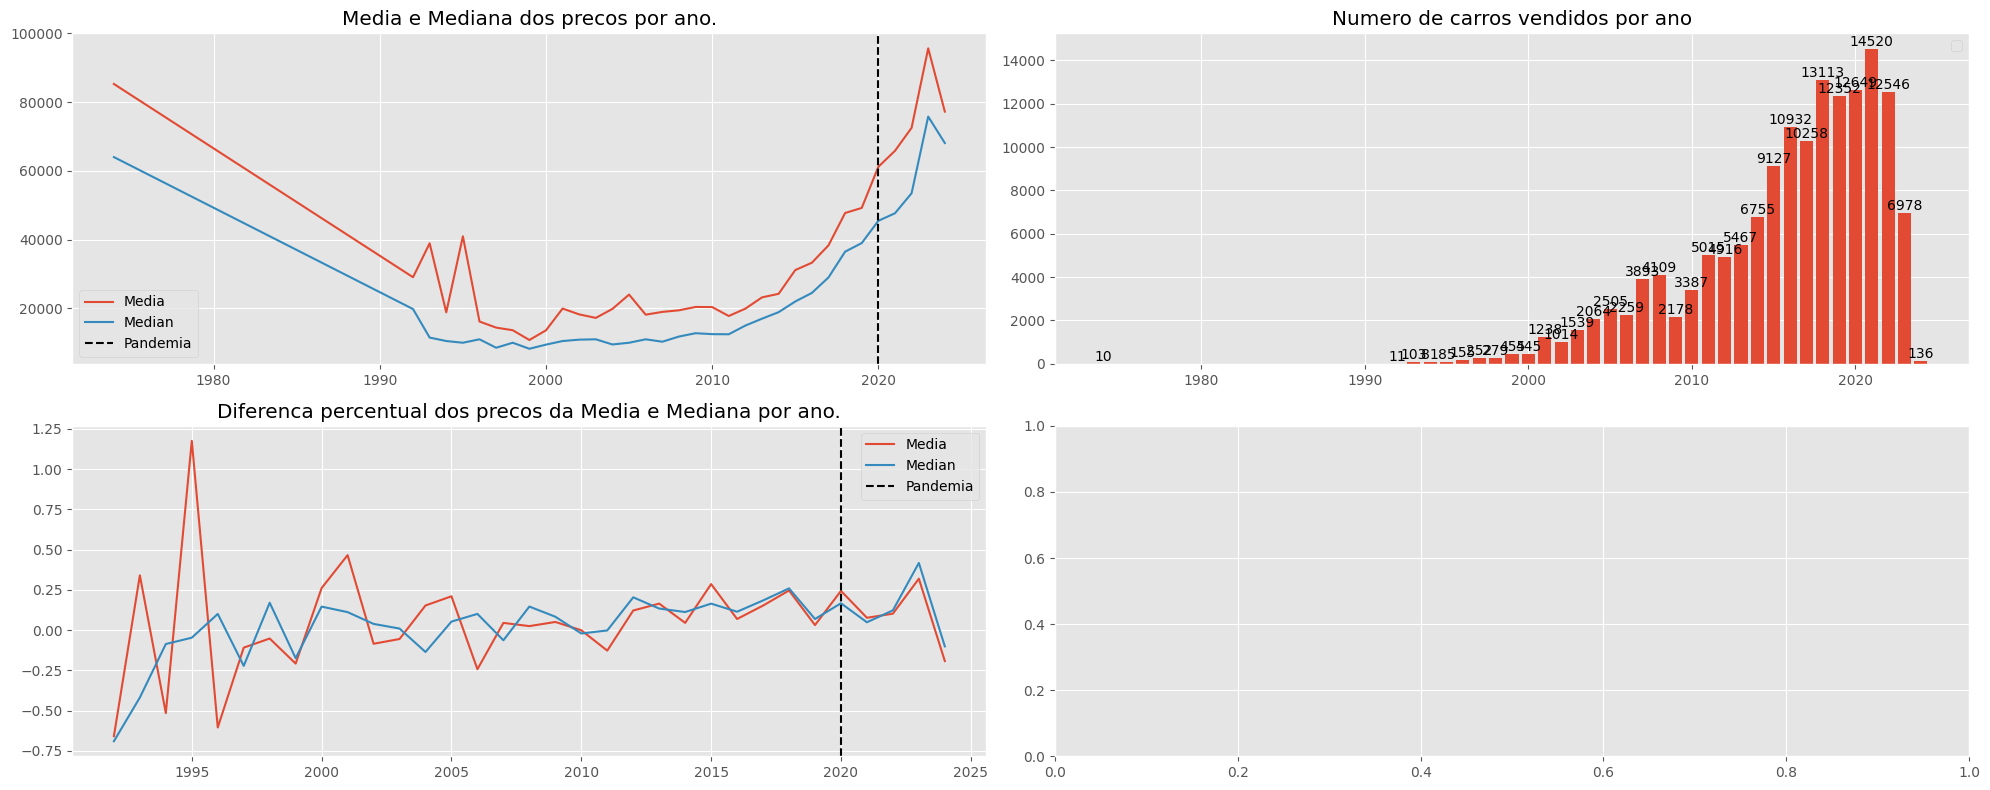

In [344]:
result = train.groupby("model_year")['price'].agg(["mean", "median"])
result_2 = train.groupby("model_year")['price'].count()
diferenca_percentual = result.pct_change()

fig, axes = plt.subplots(2, 2, figsize=(20, 8))

axes[0][0].plot(result.index, result['mean'], label="Media")
axes[0][0].plot(result.index, result['median'], label="Median")
axes[0][0].legend()
axes[0][0].set_title('Media e Mediana dos precos por ano.')
axes[0][0].axvline(
            x= 2020,
            color="black",
            linestyle="--",
            label="Pandemia",
        )
axes[0][0].legend()

axes[0][1].bar(result_2.index, result_2.values)
axes[0][1].legend()
axes[0][1].set_title('Numero de carros vendidos por ano')
for index, value in zip(result_2.index, result_2):
    axes[0][1].text(index, value, f"{value:.0f}", ha="center", va="bottom")
    

axes[1][0].plot(diferenca_percentual.index, diferenca_percentual['mean'], label="Media")
axes[1][0].plot(diferenca_percentual.index, diferenca_percentual['median'], label="Median")
axes[1][0].legend()
axes[1][0].axvline(
            x= 2020,
            color="black",
            linestyle="--",
            label="Pandemia",
        )
axes[1][0].set_title('Diferenca percentual dos precos da Media e Mediana por ano.')
axes[1][0].legend()
plt.tight_layout()
plt.show()

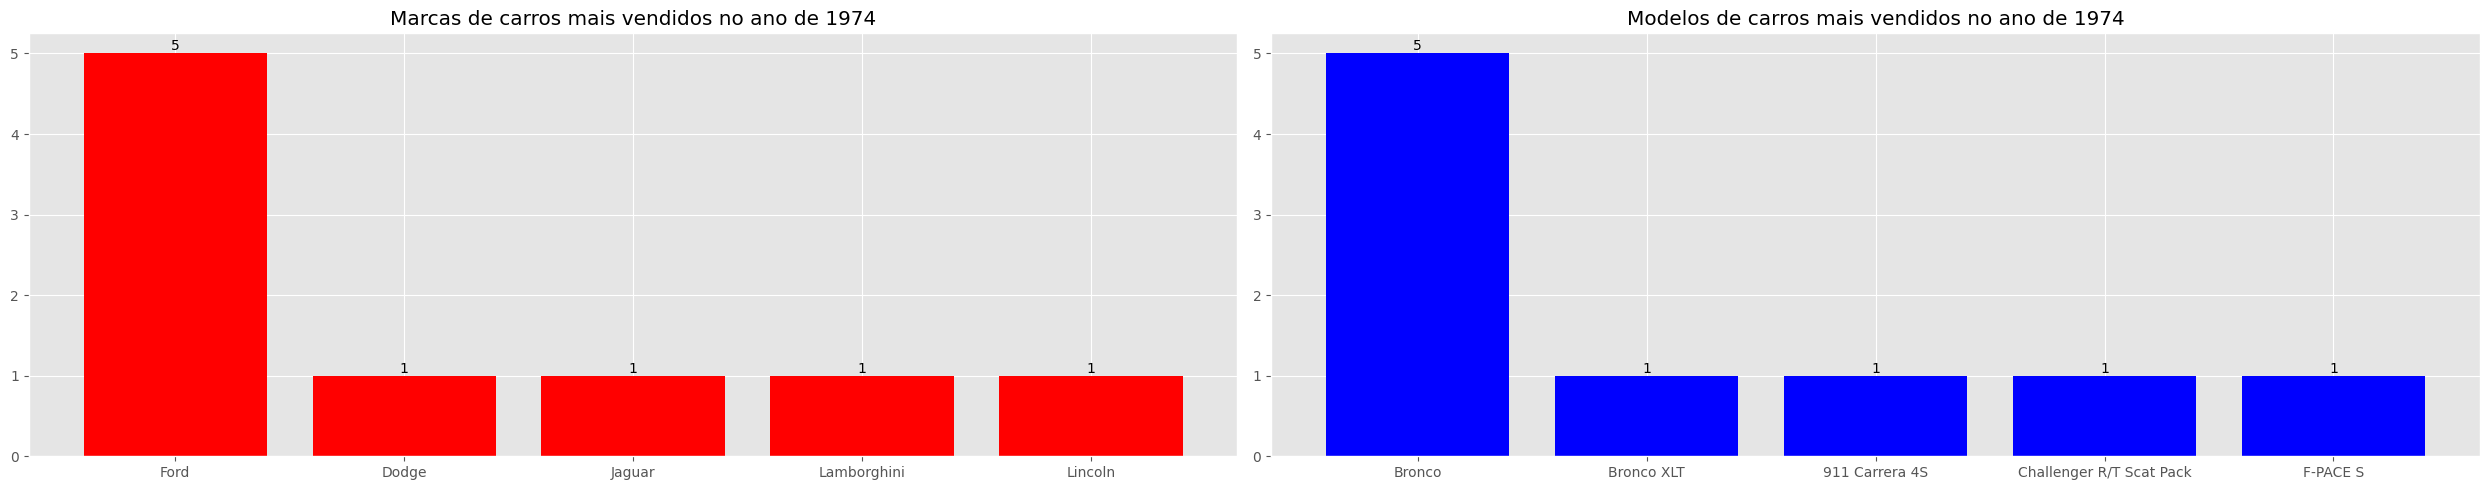

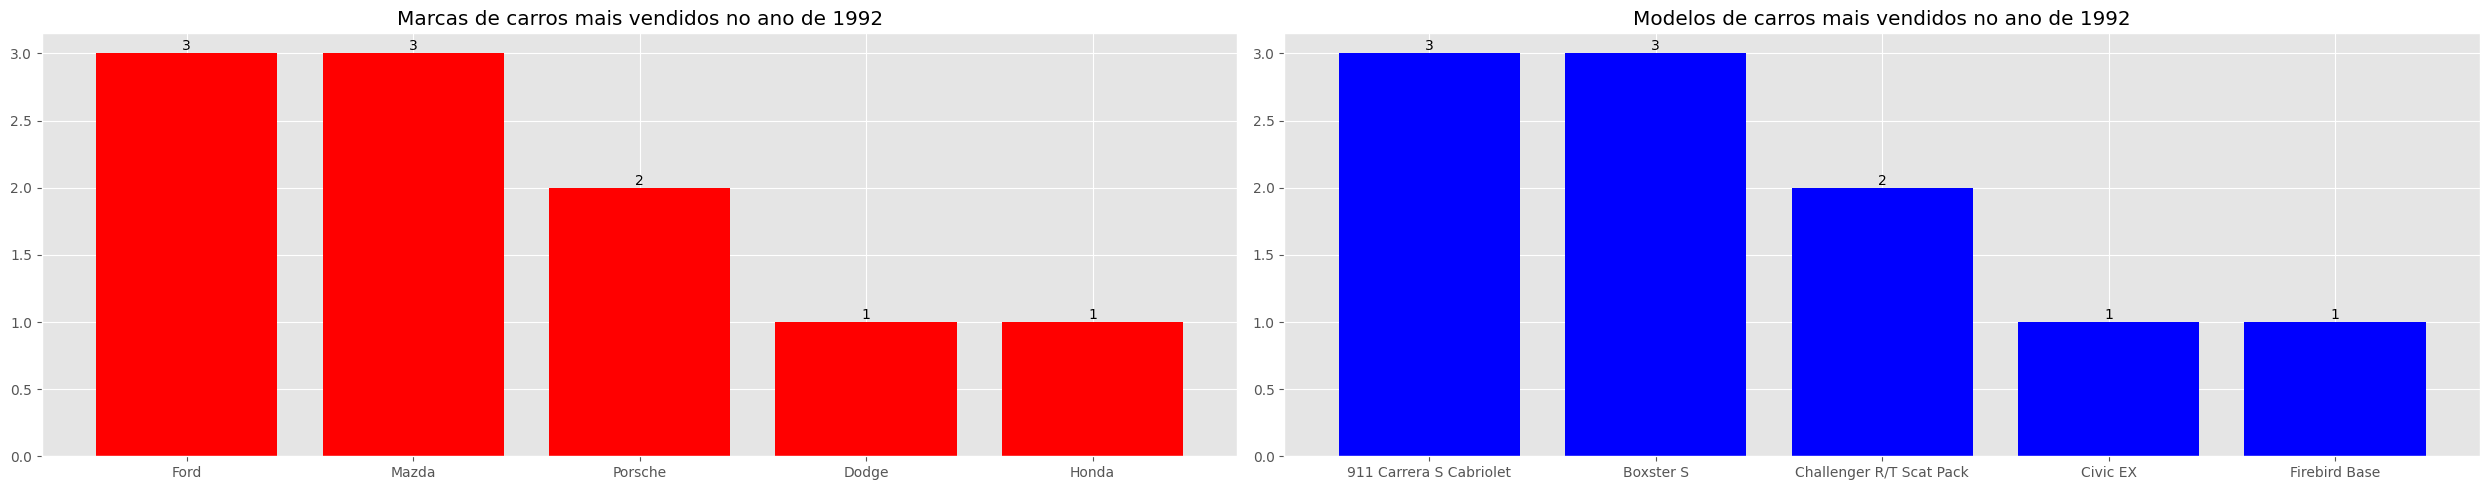

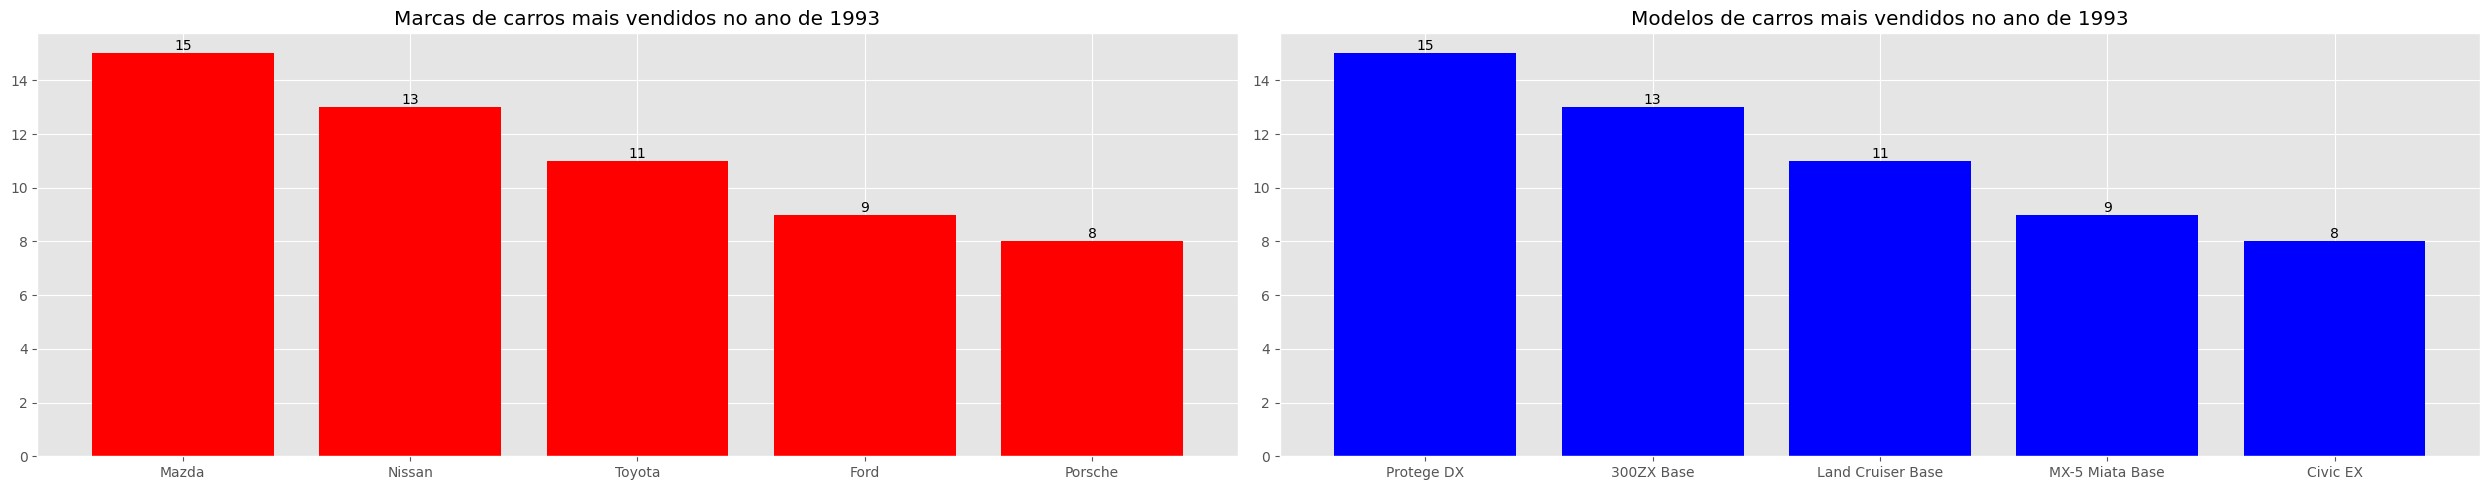

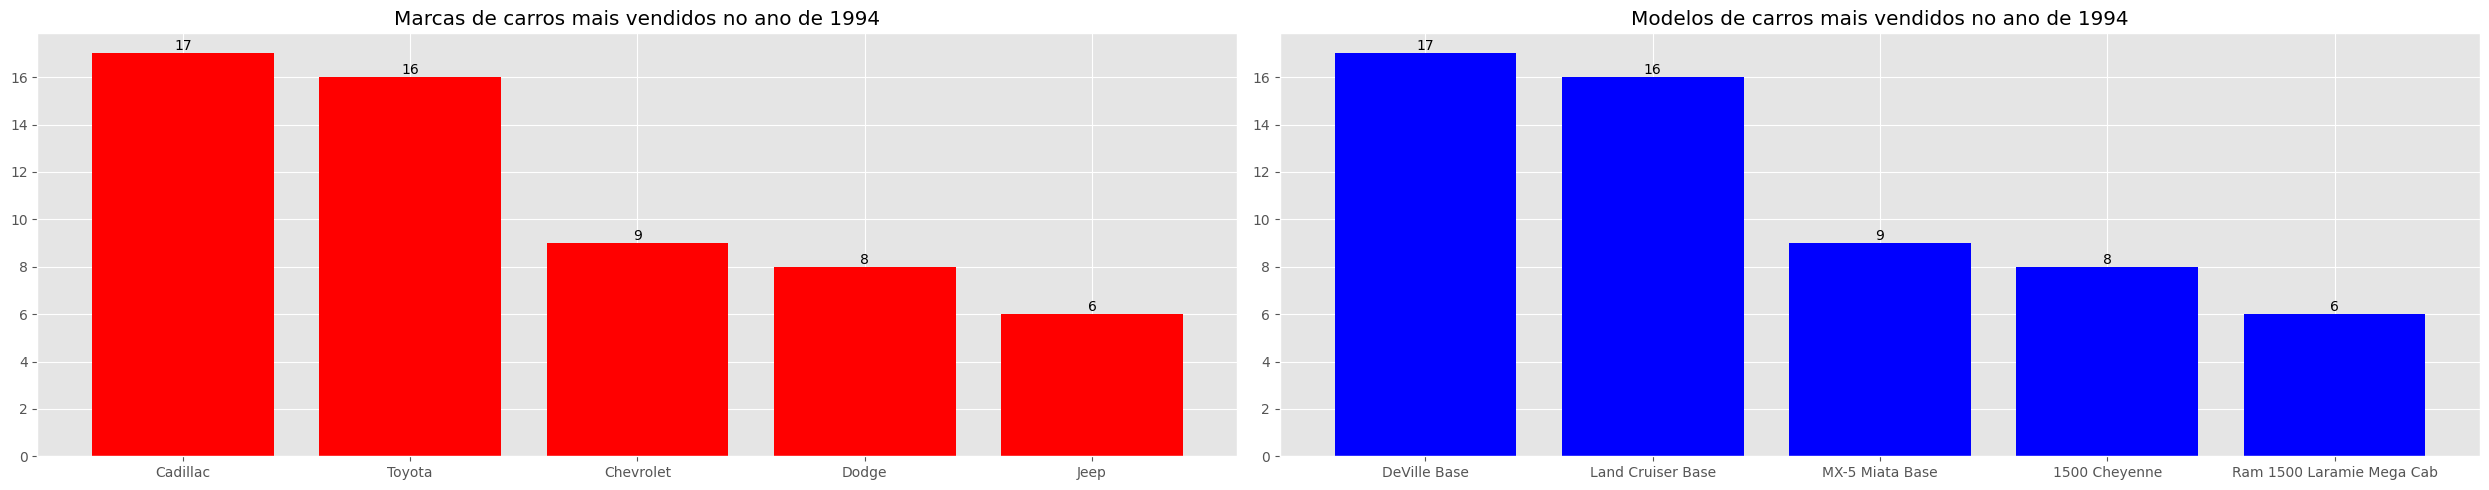

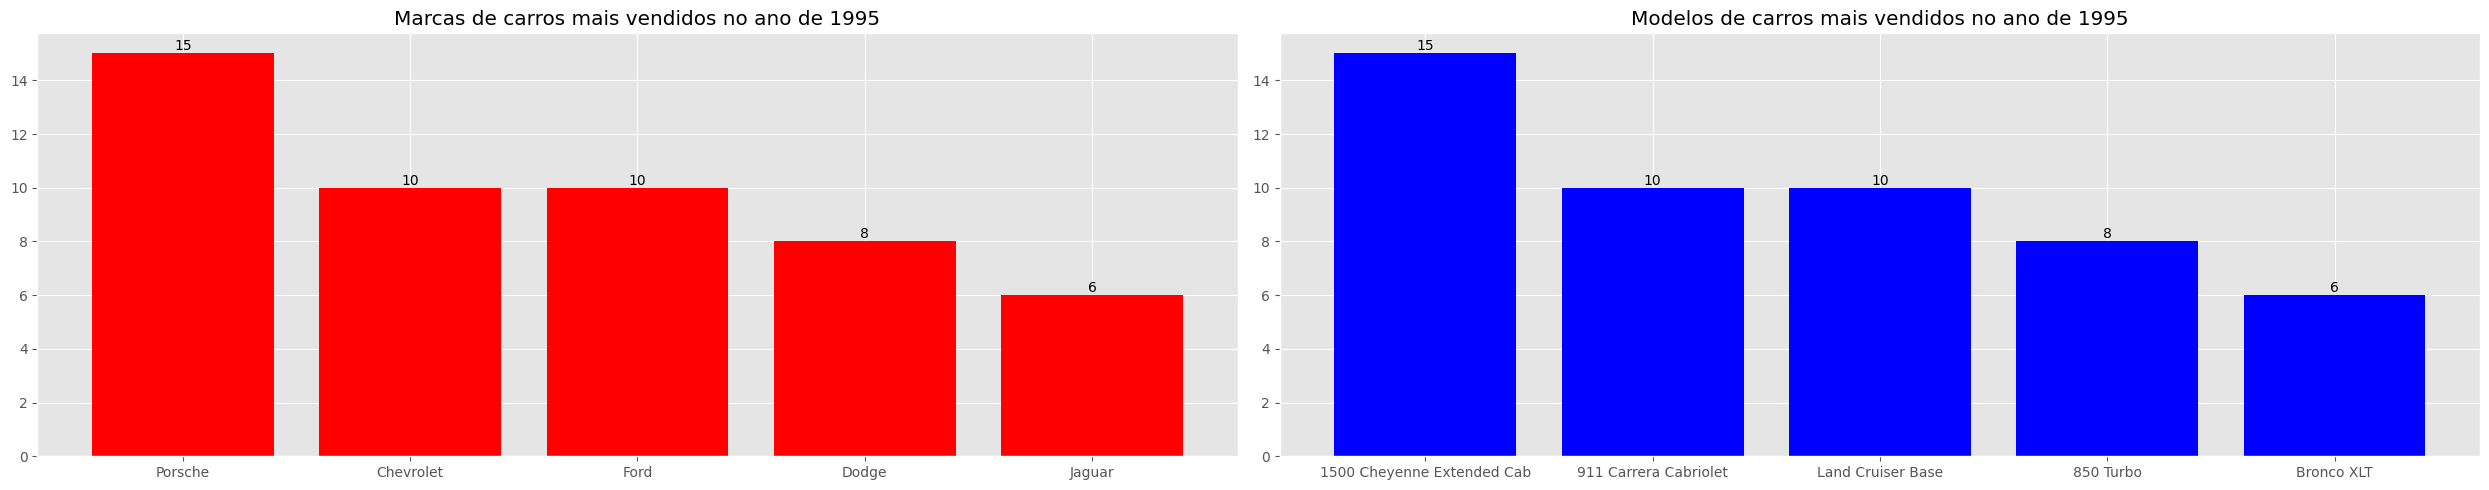

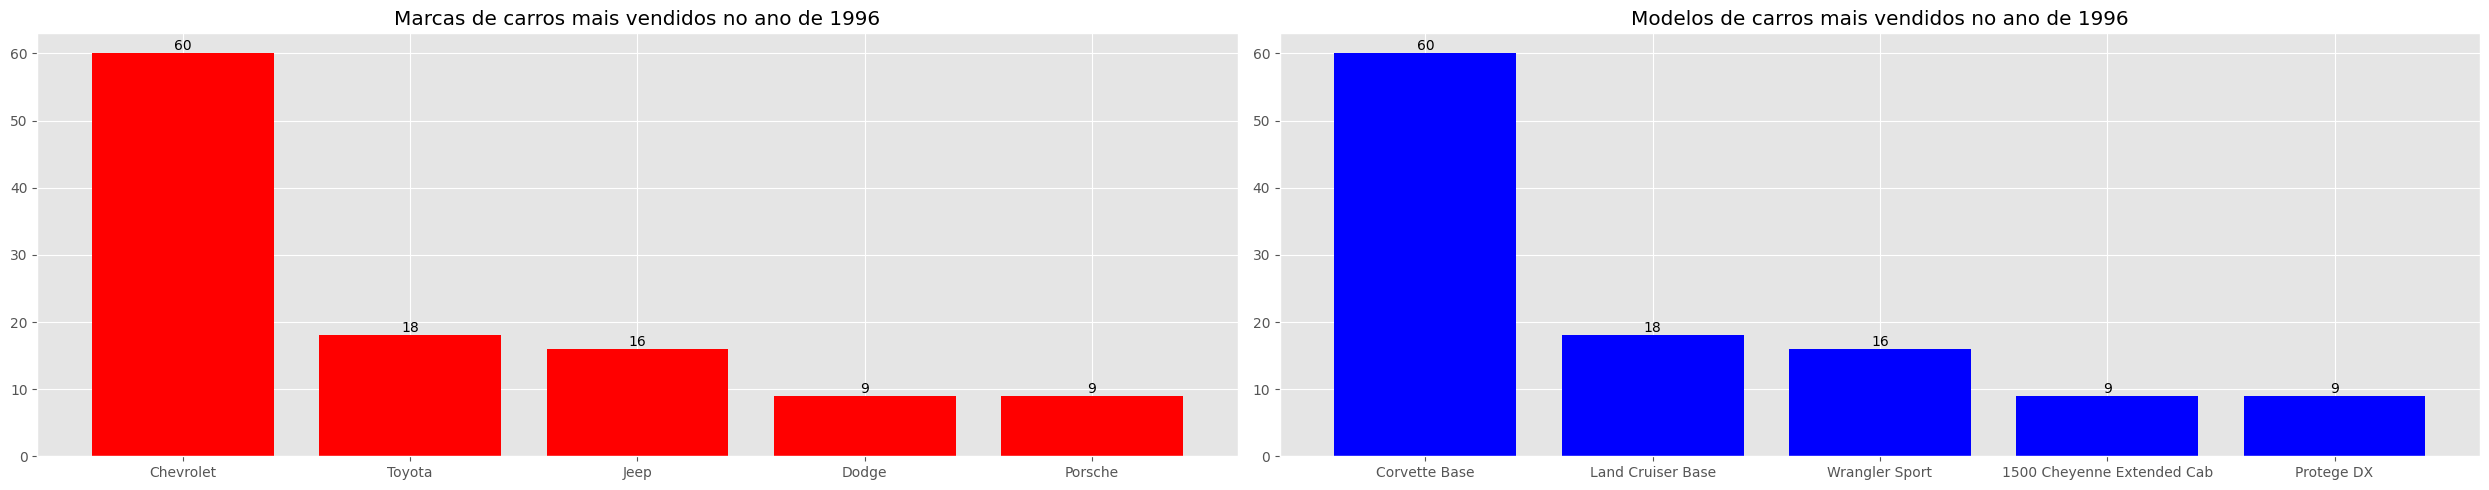

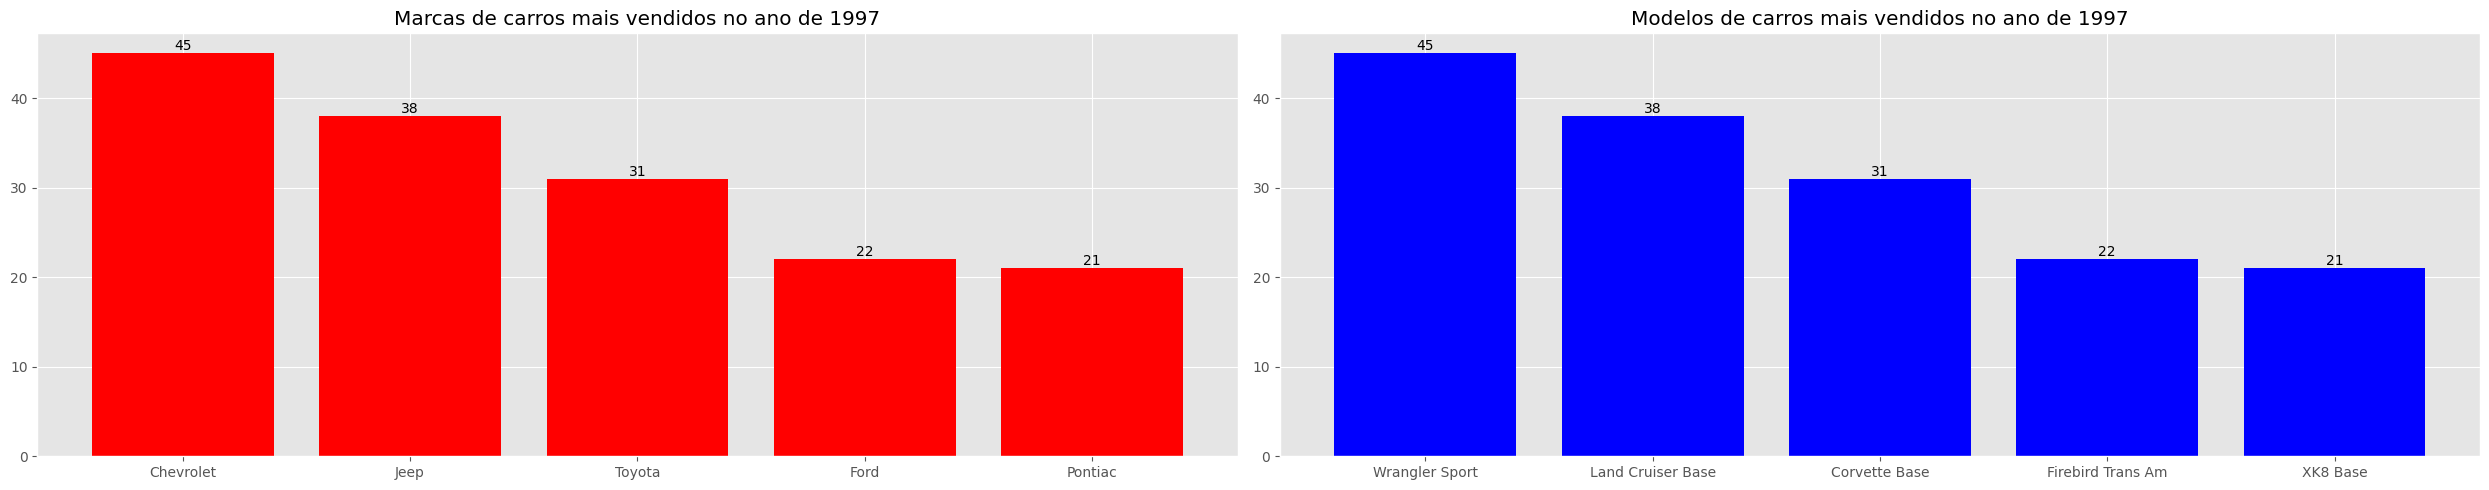

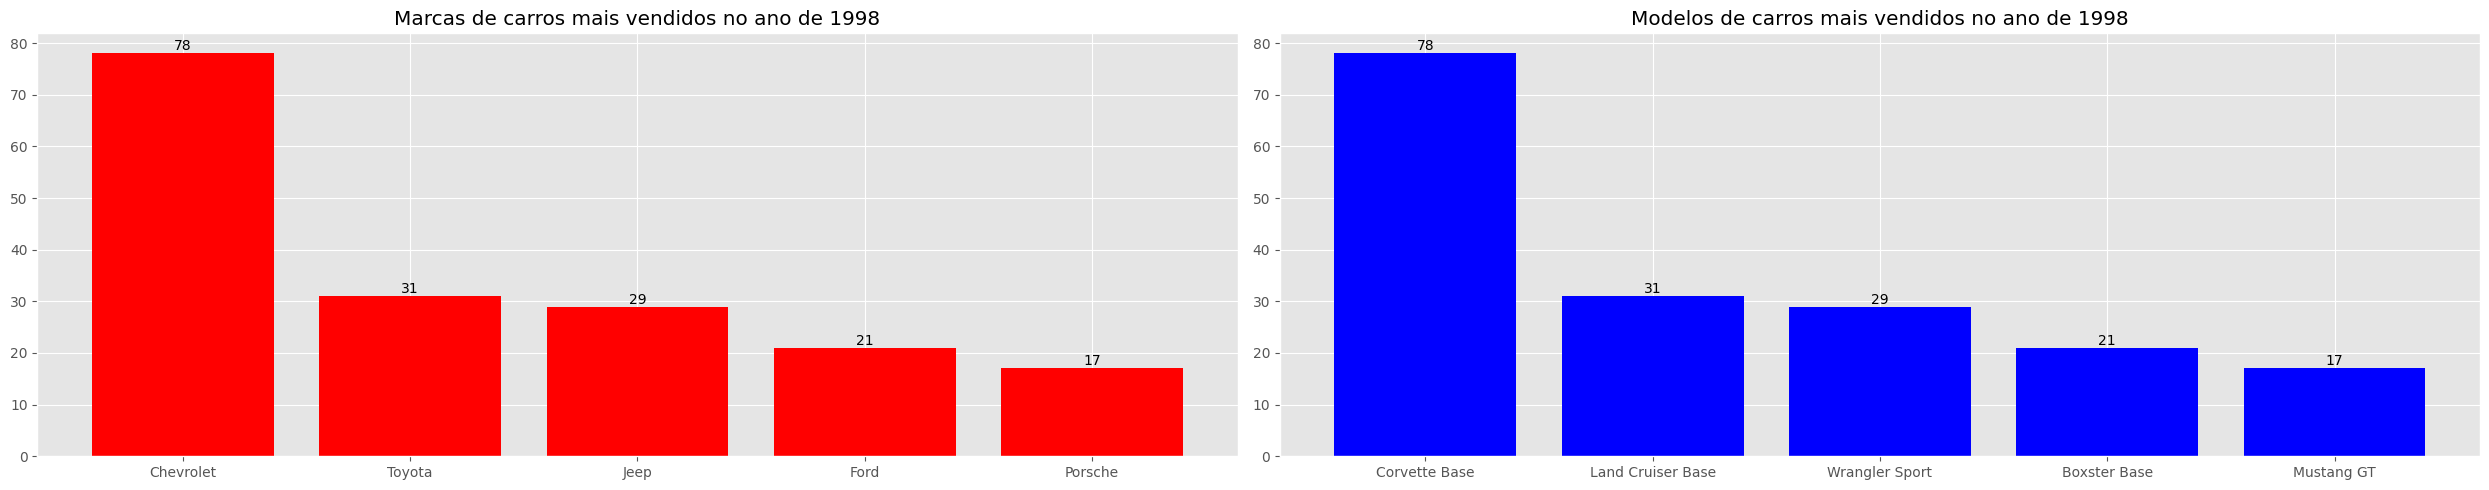

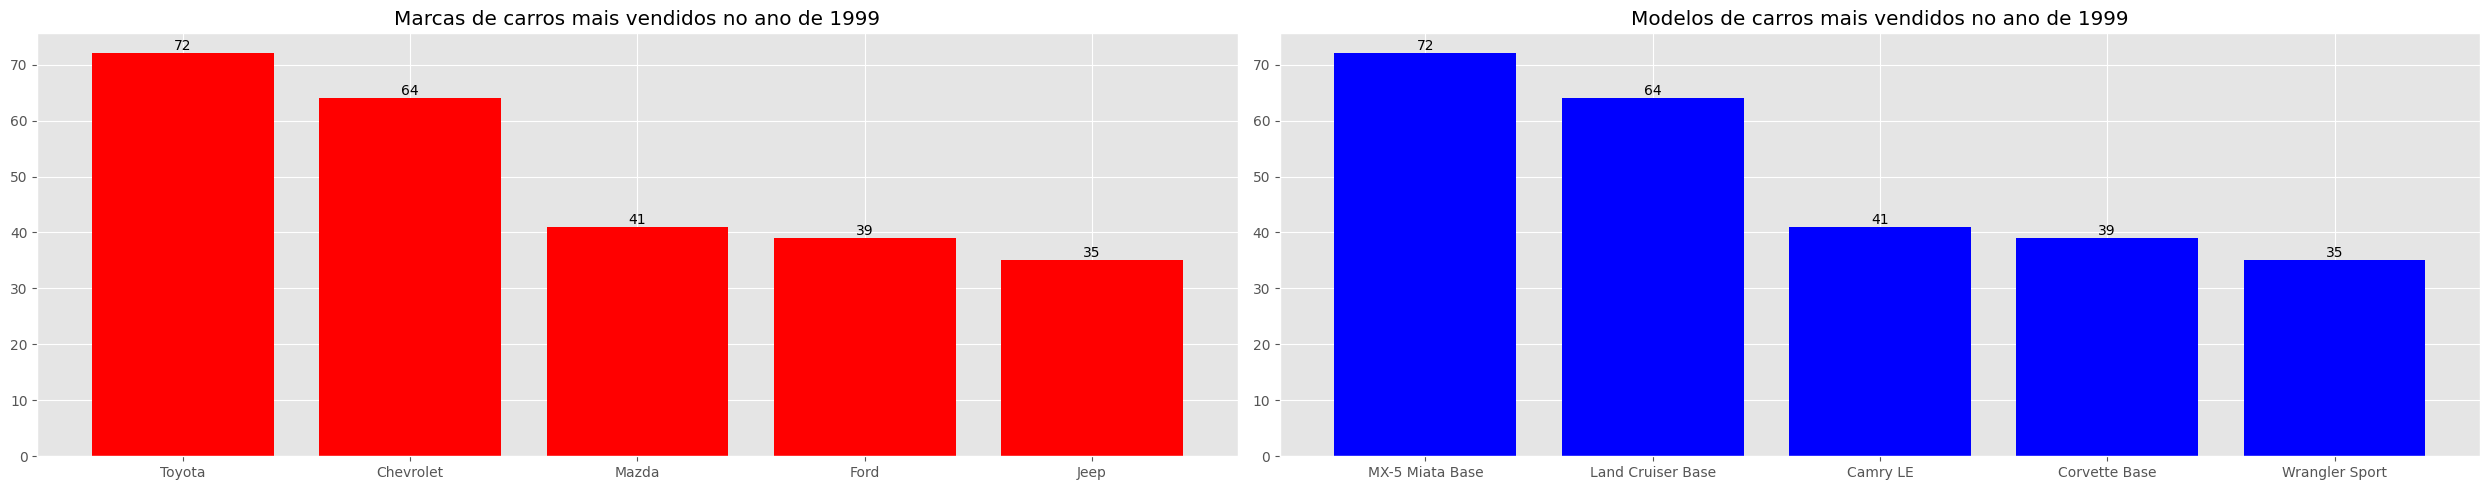

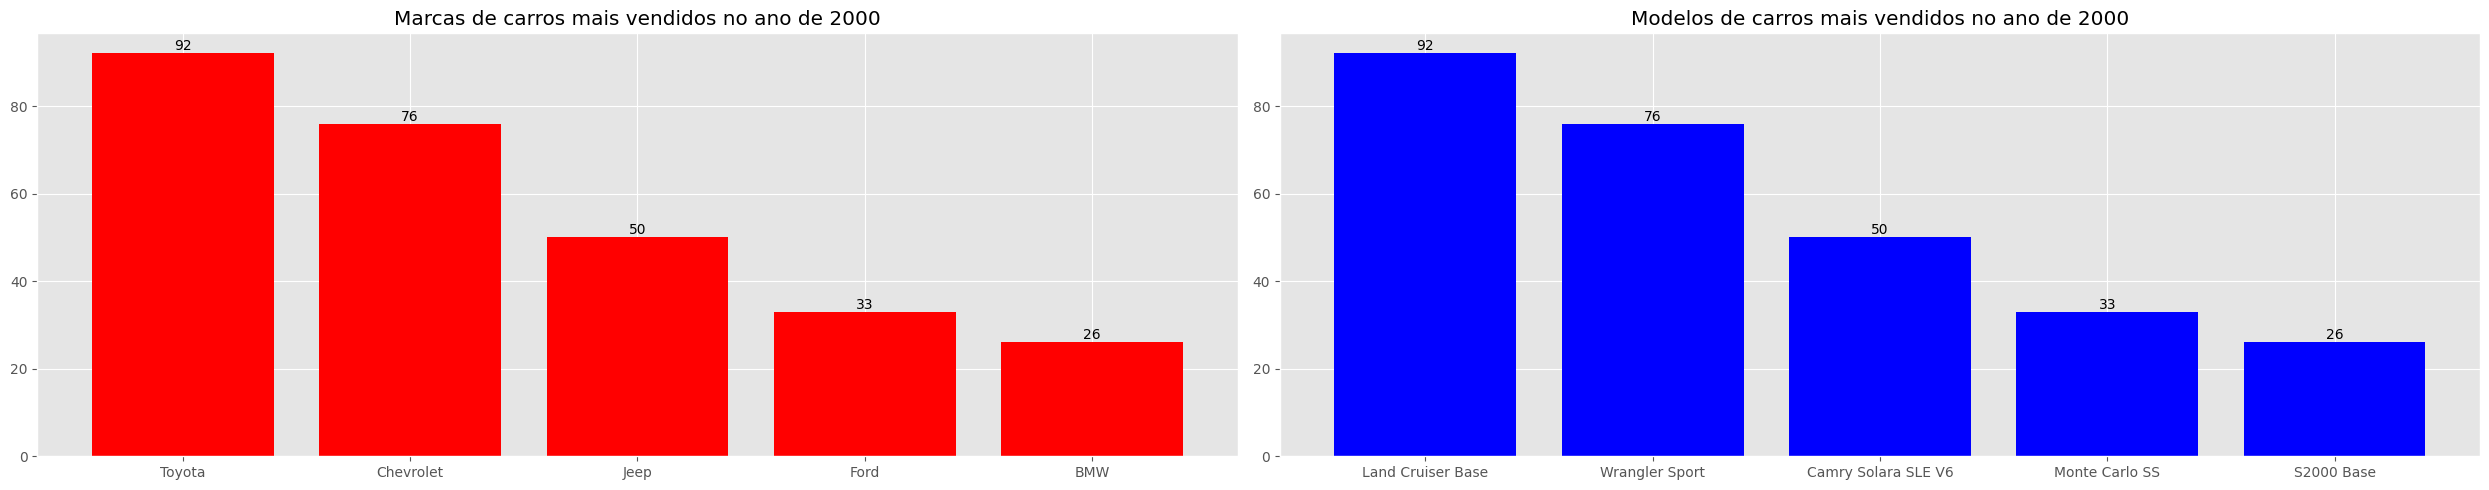

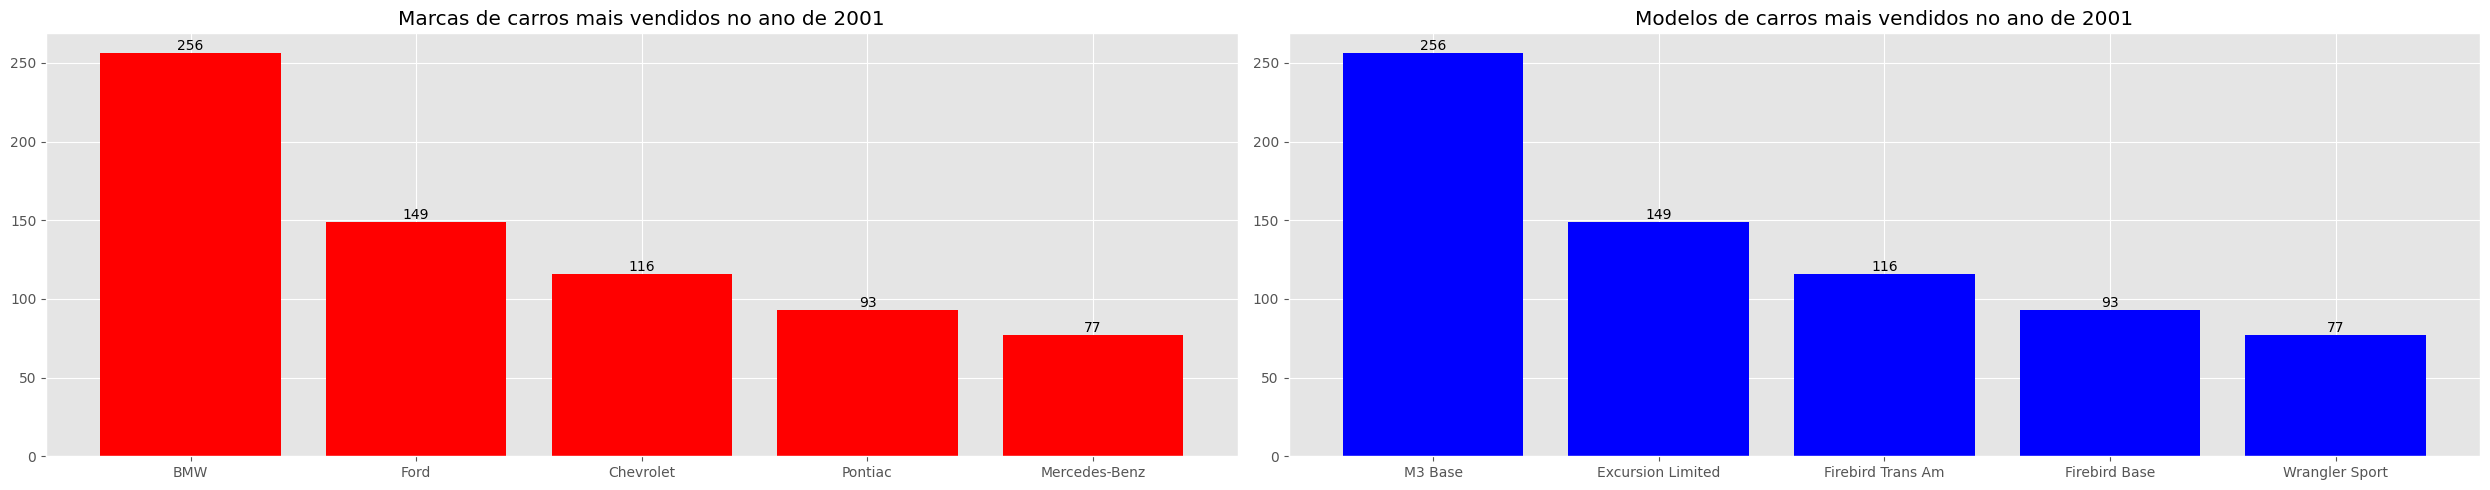

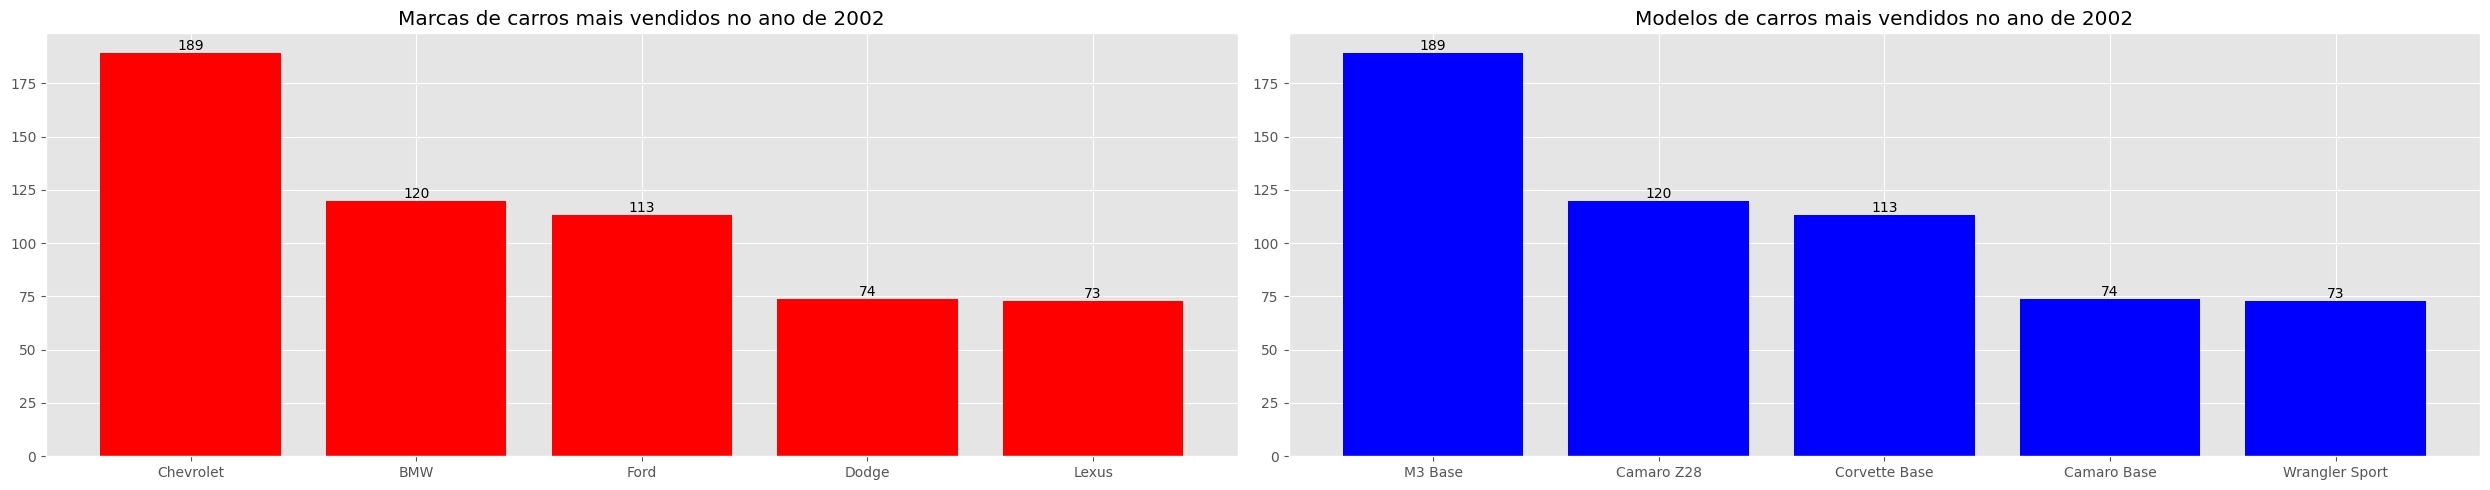

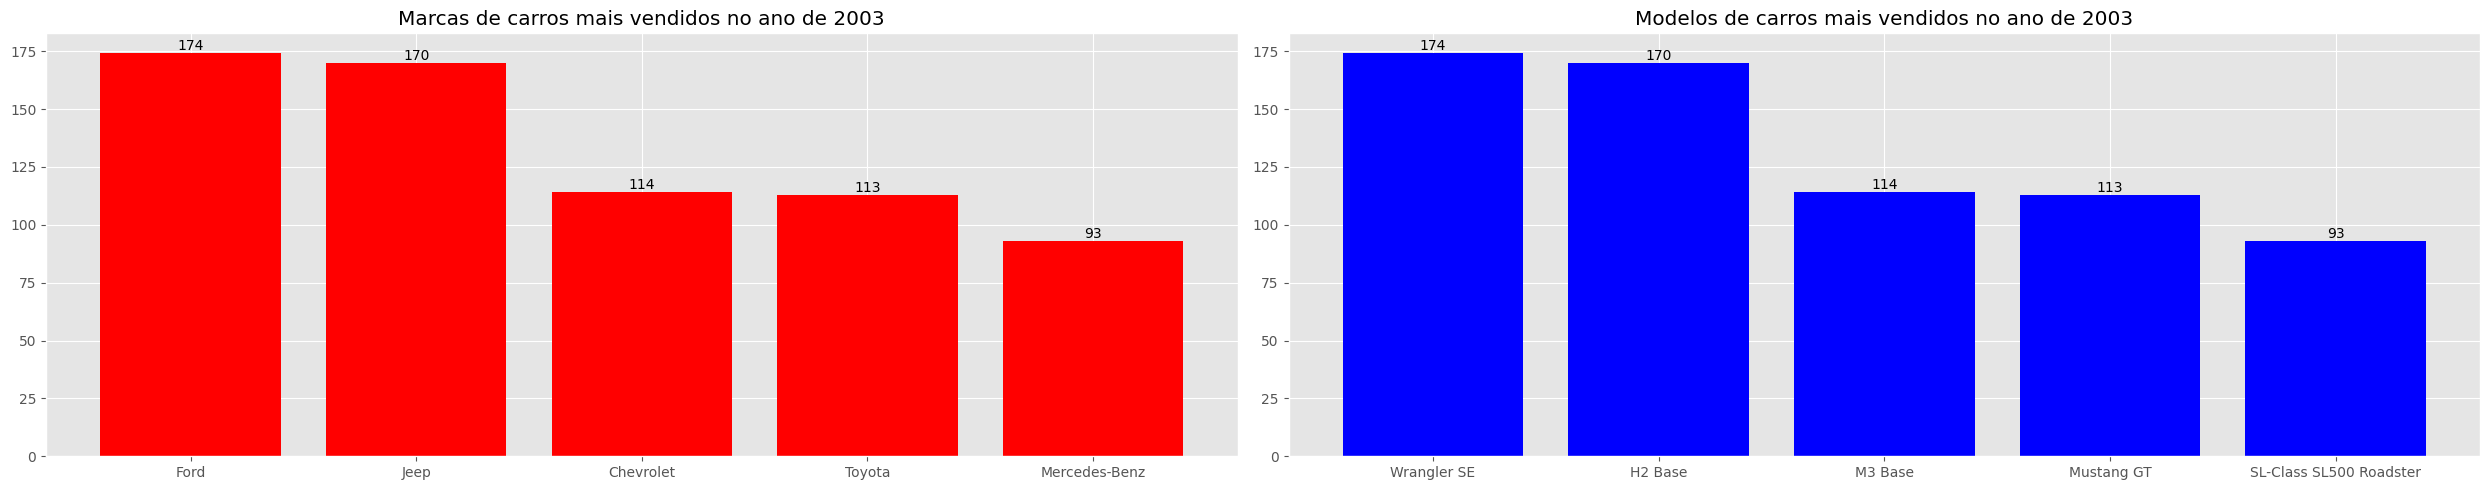

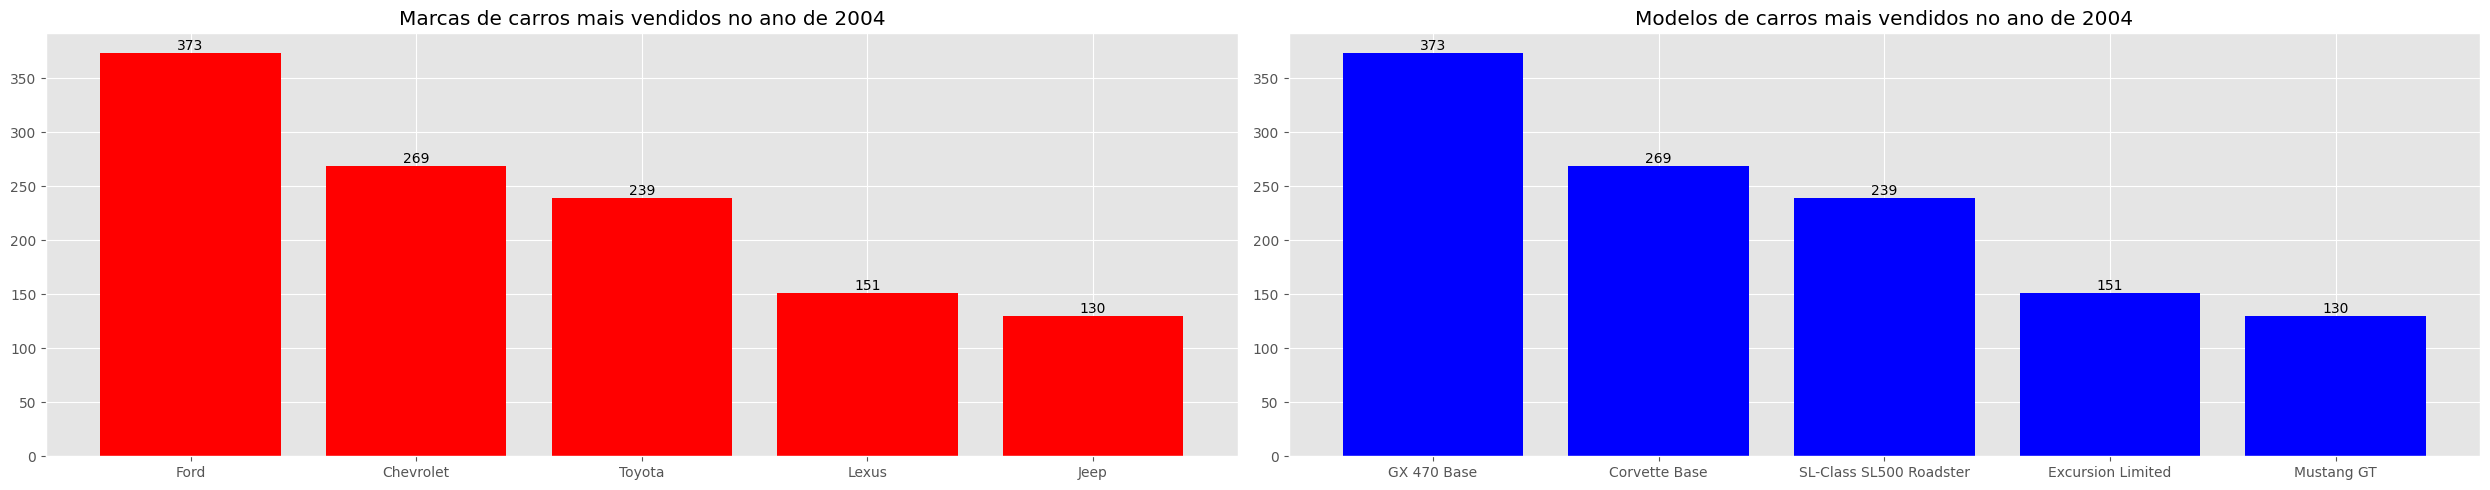

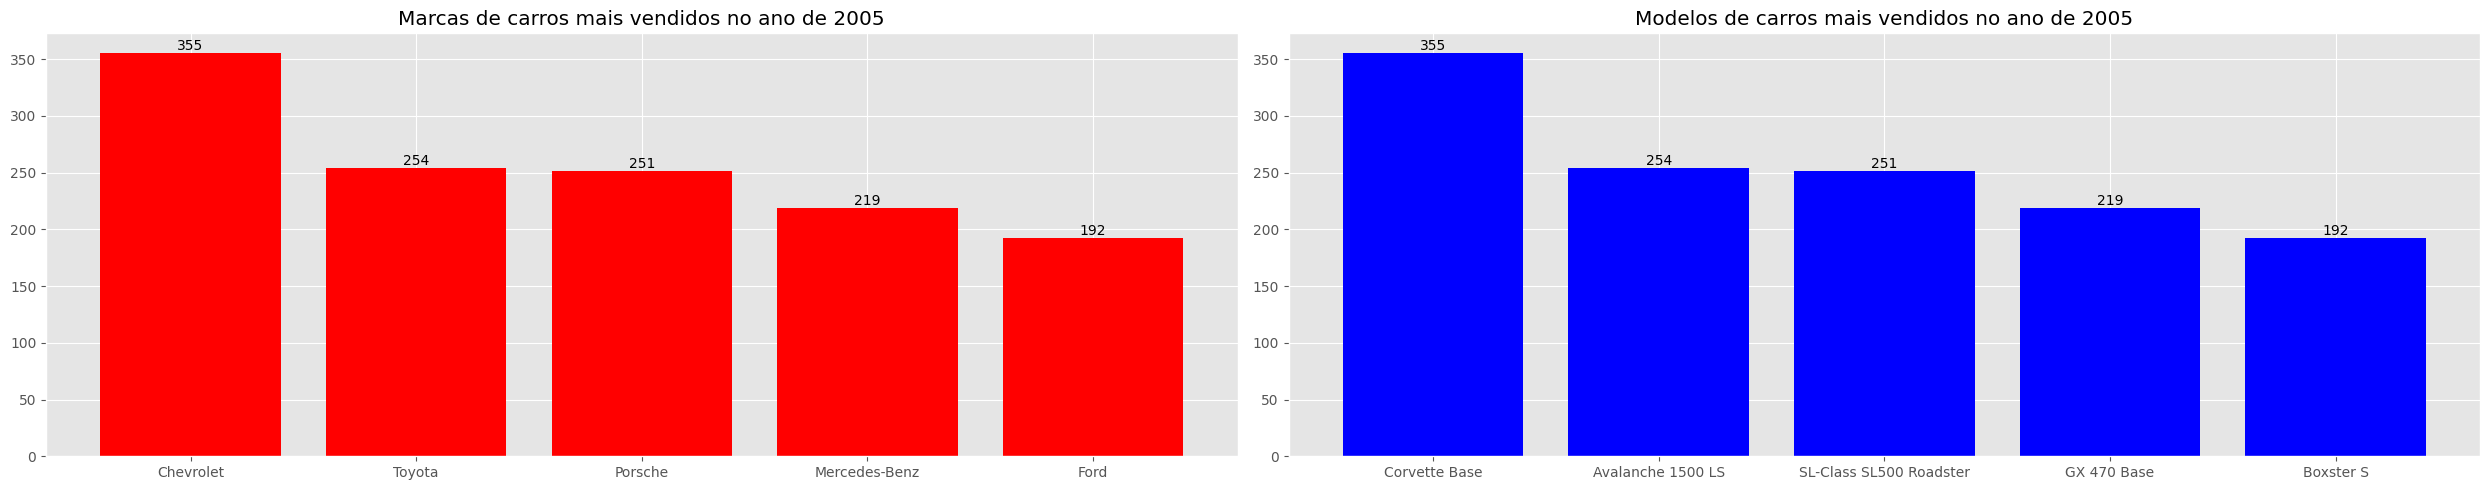

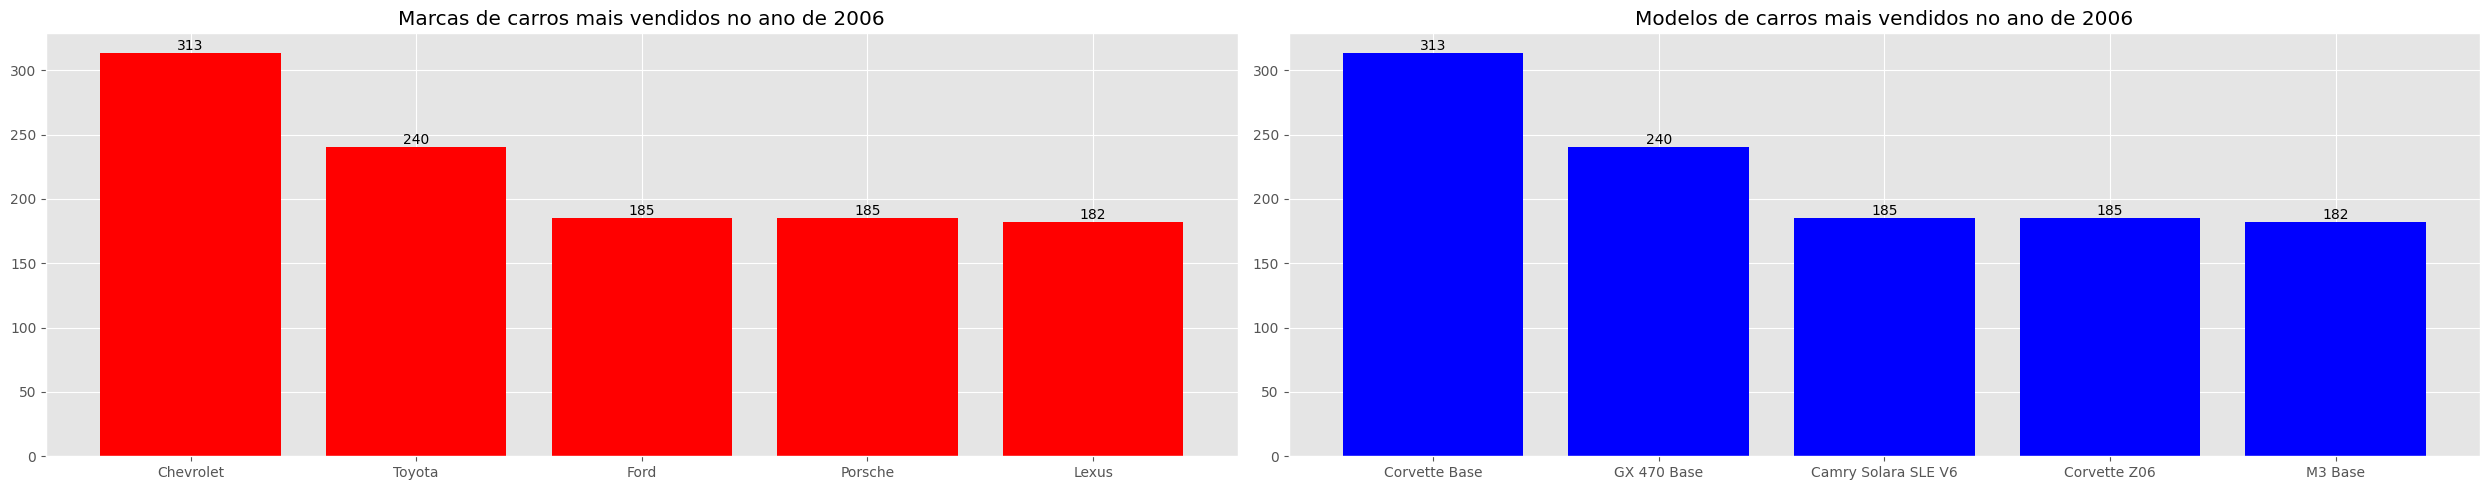

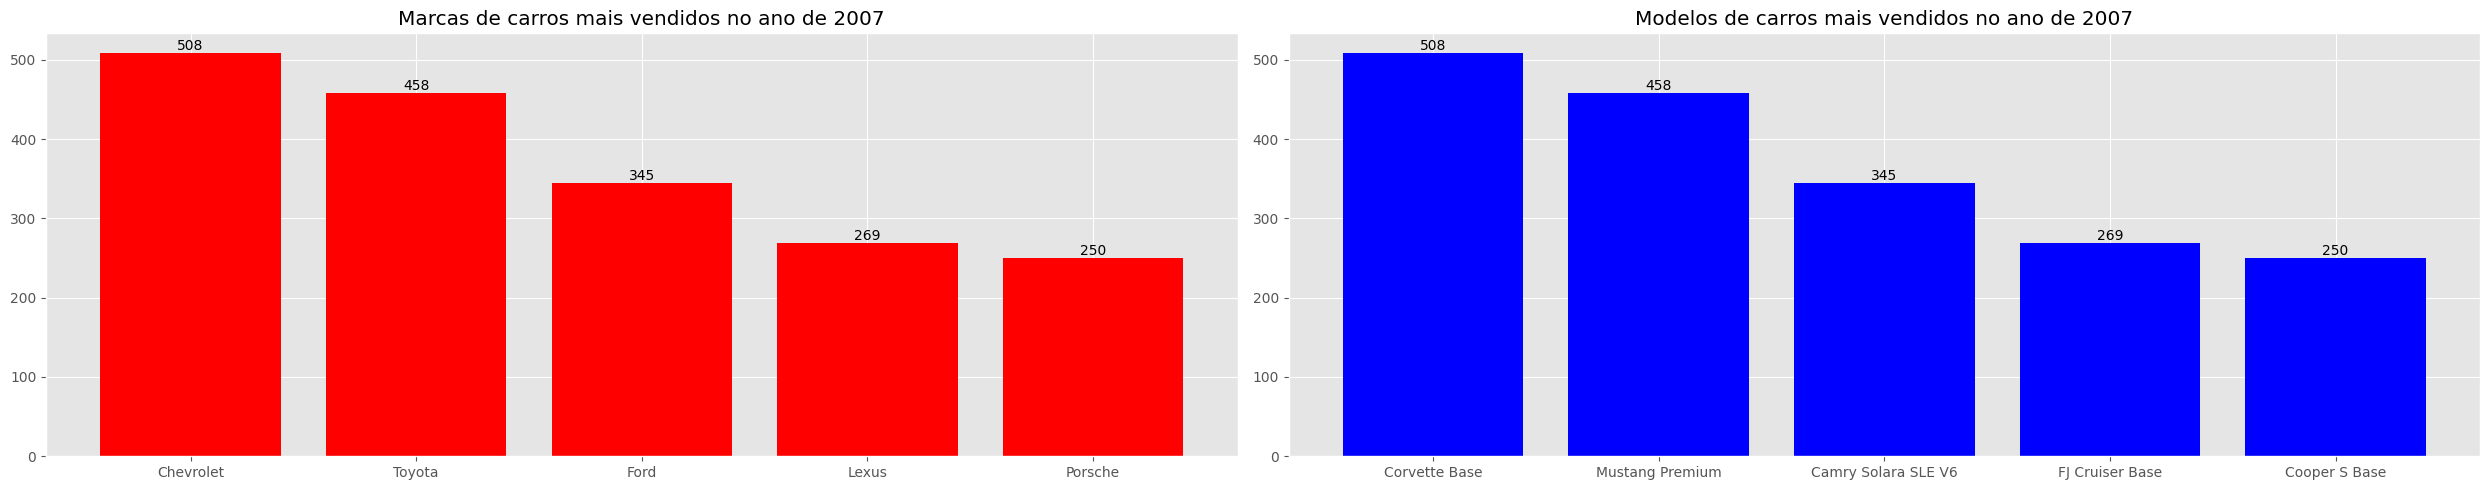

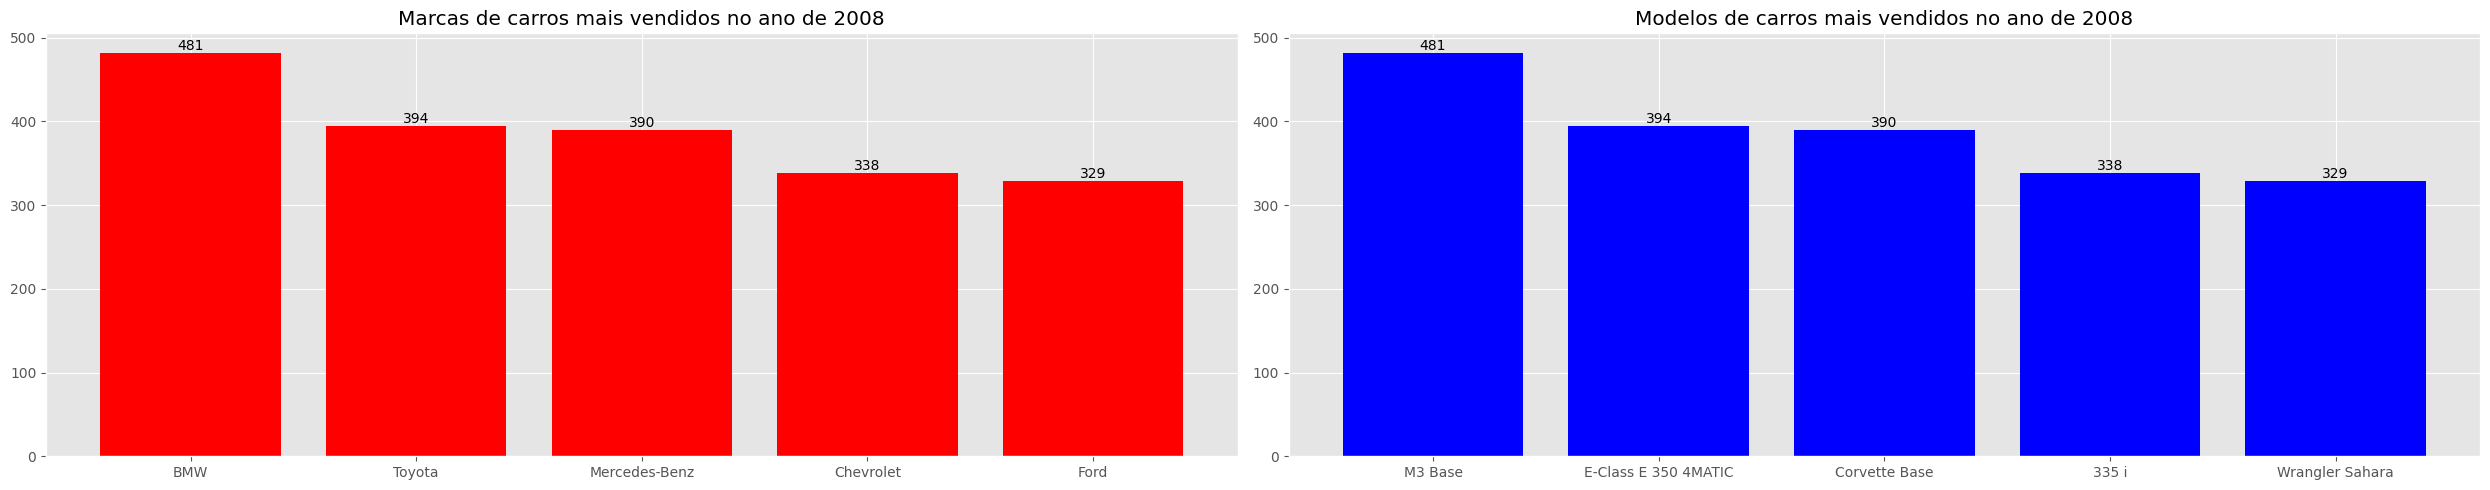

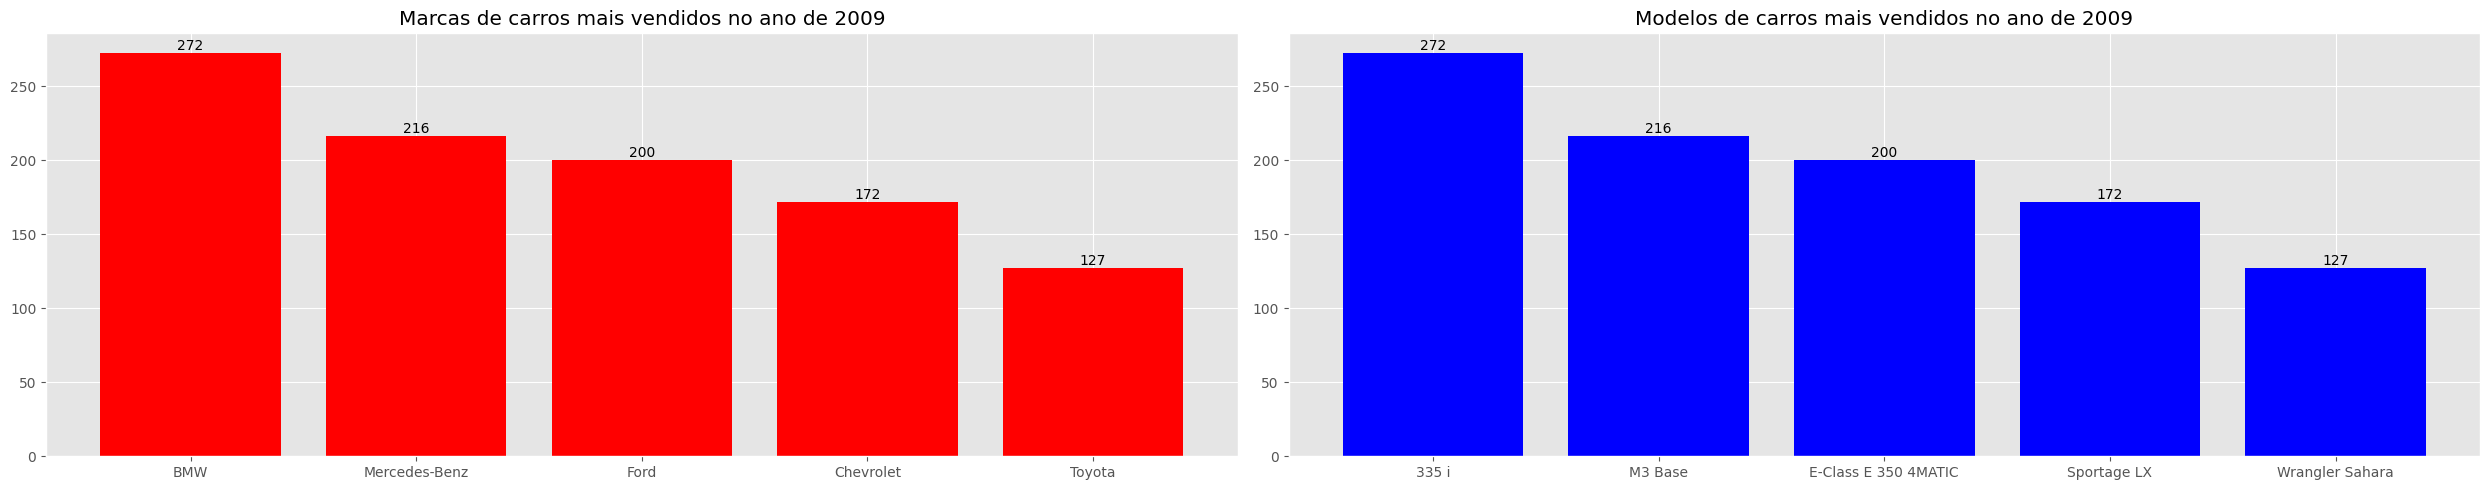

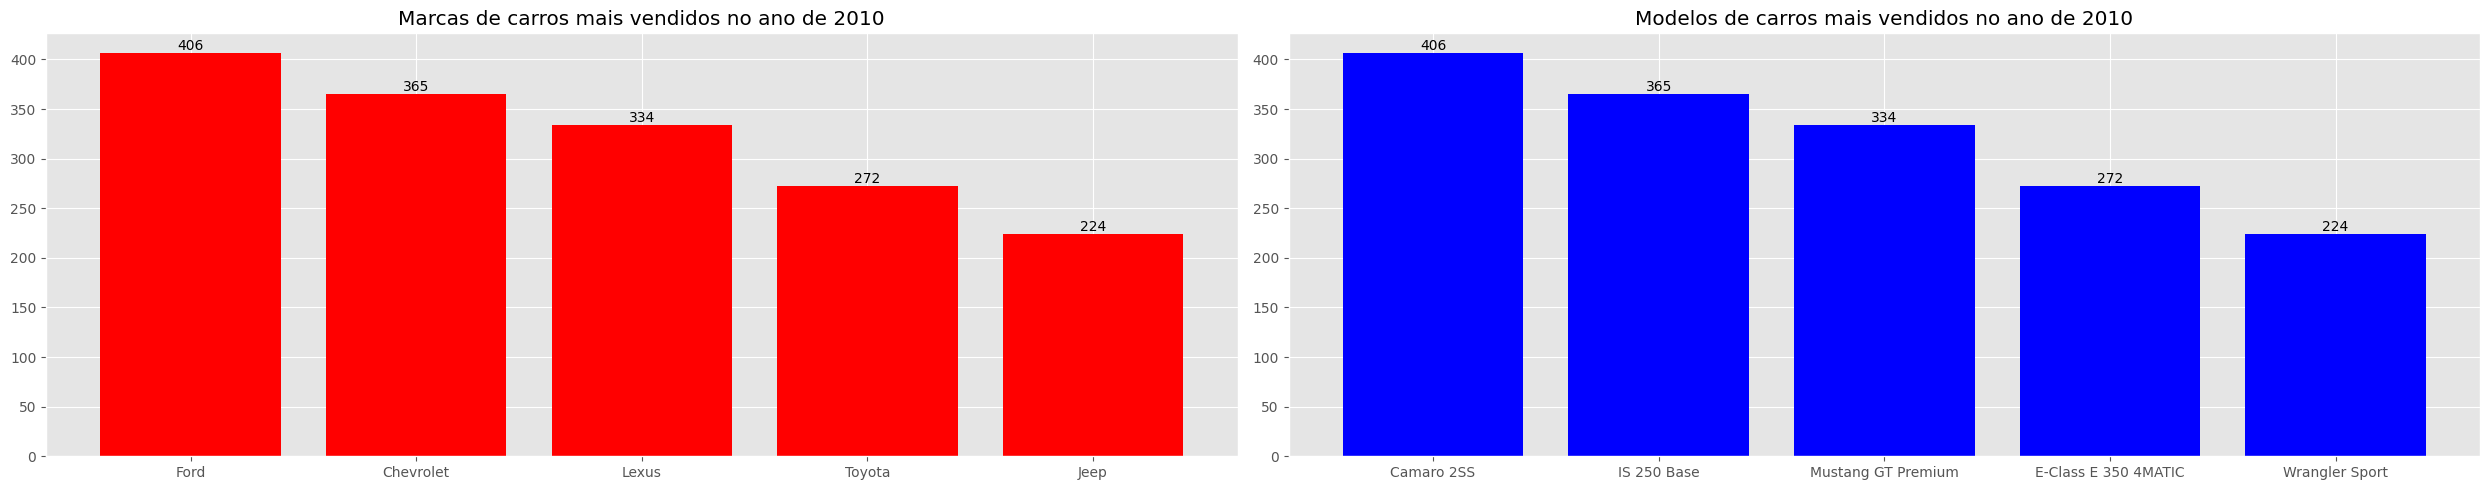

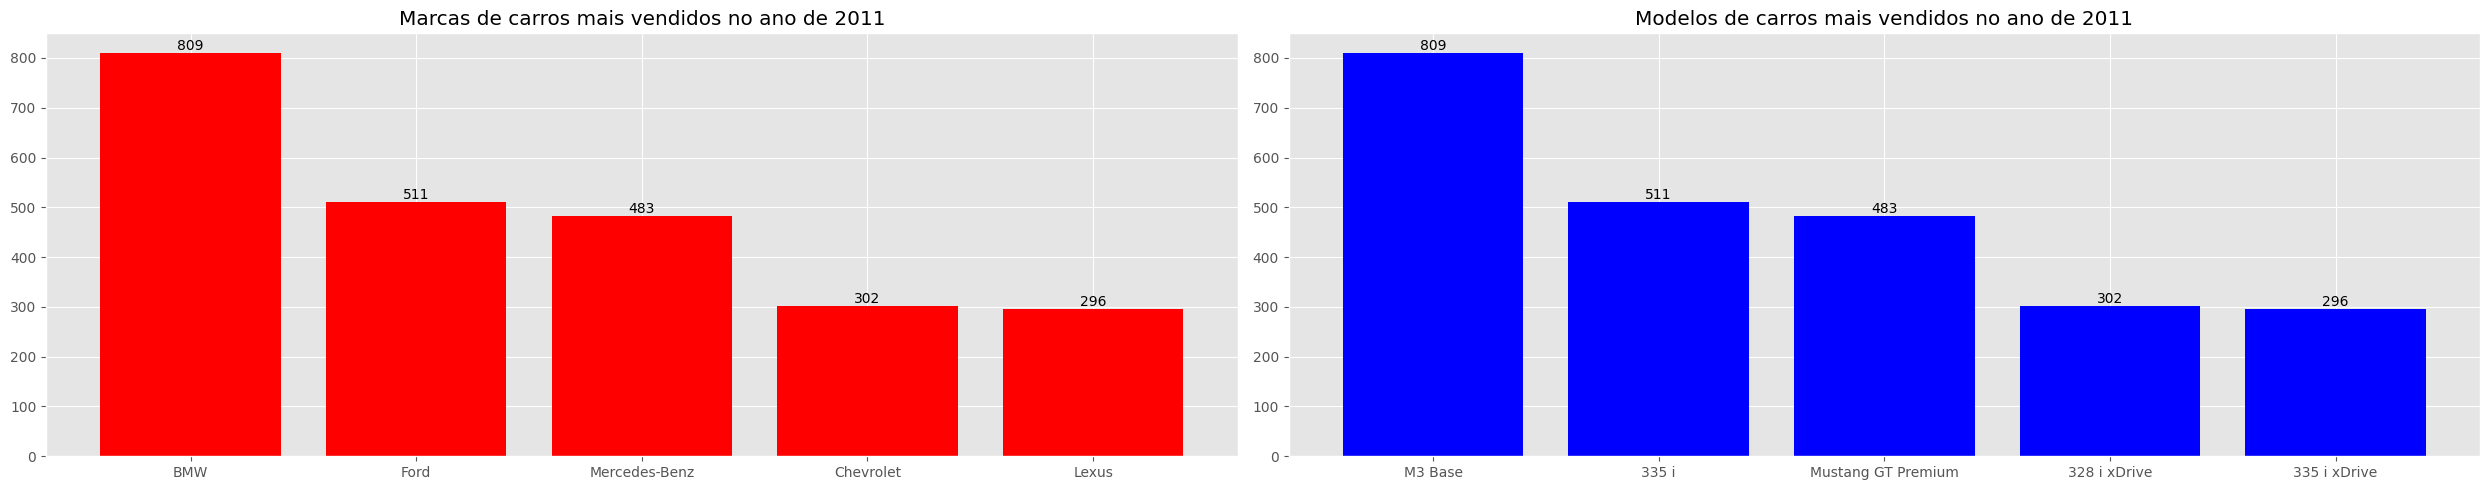

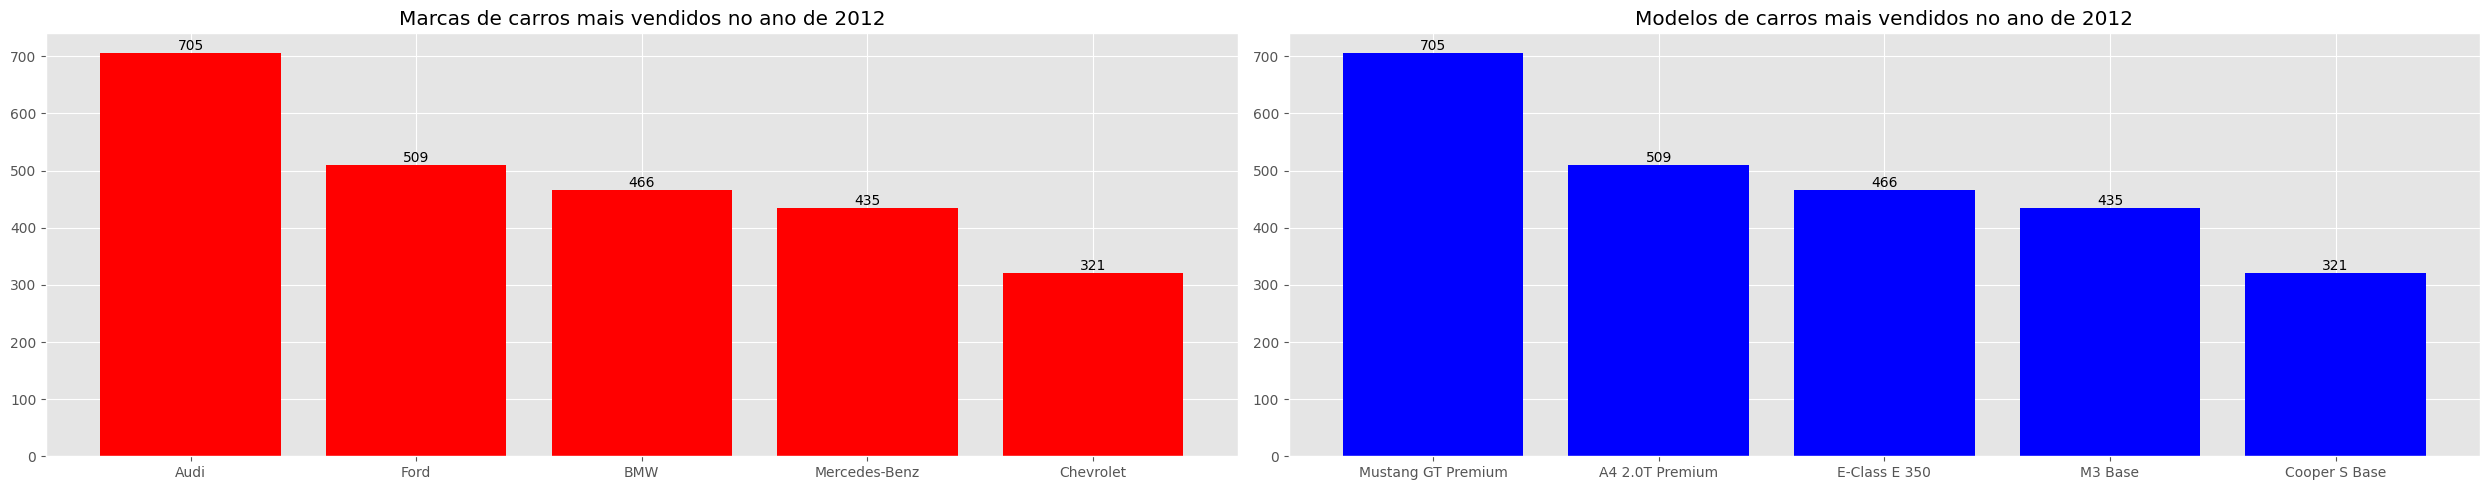

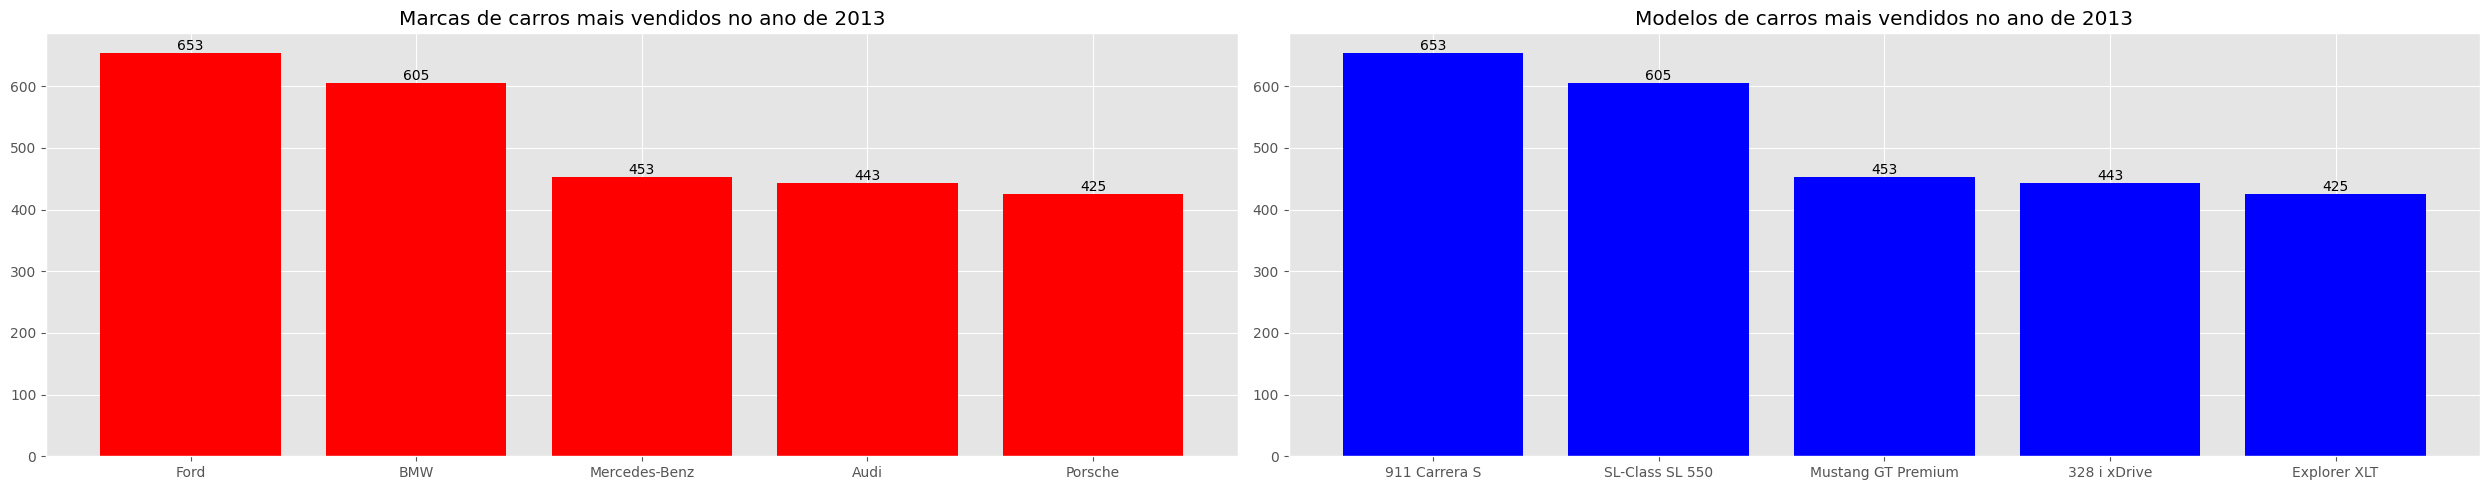

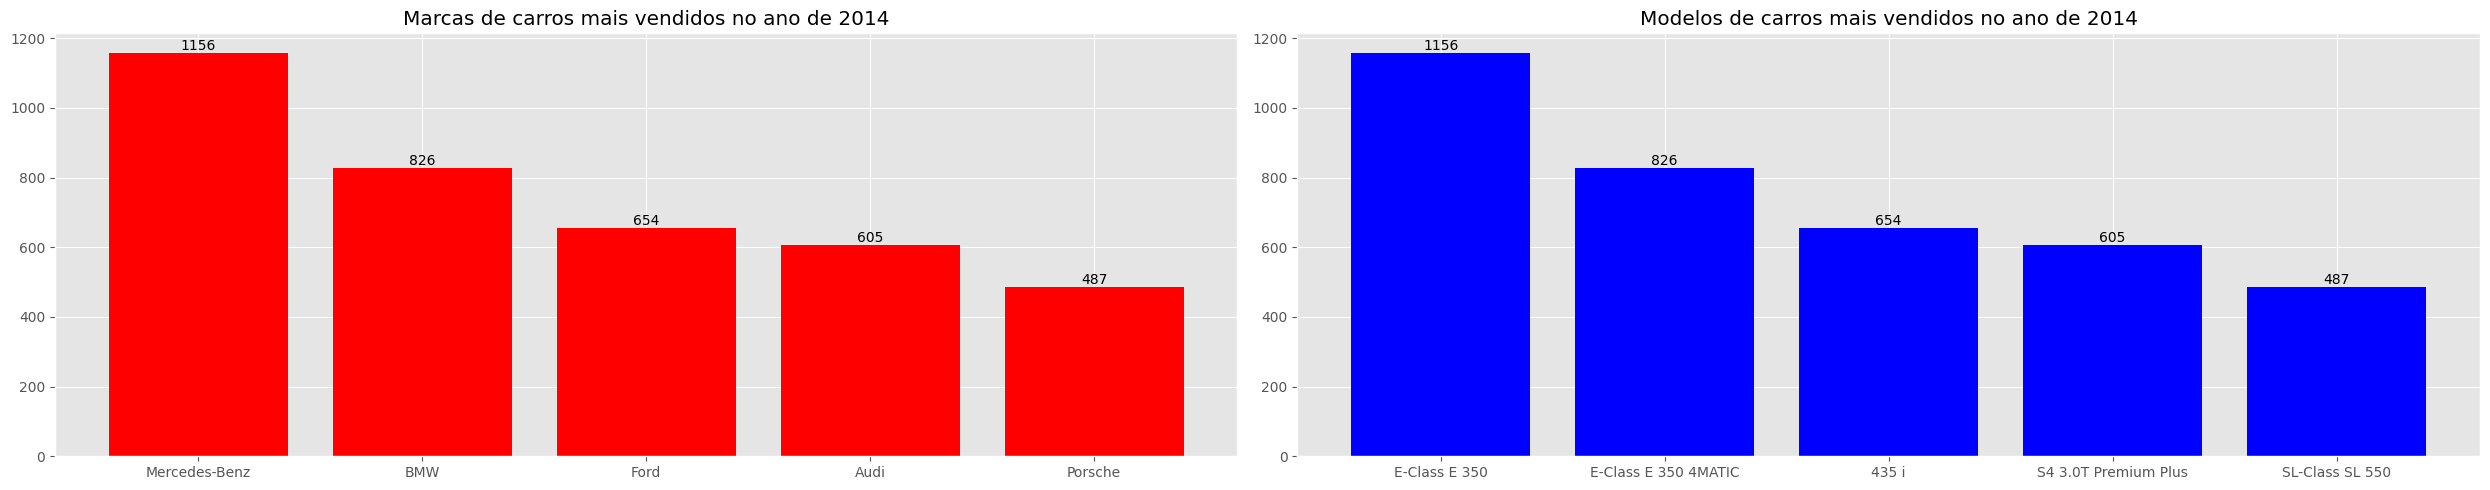

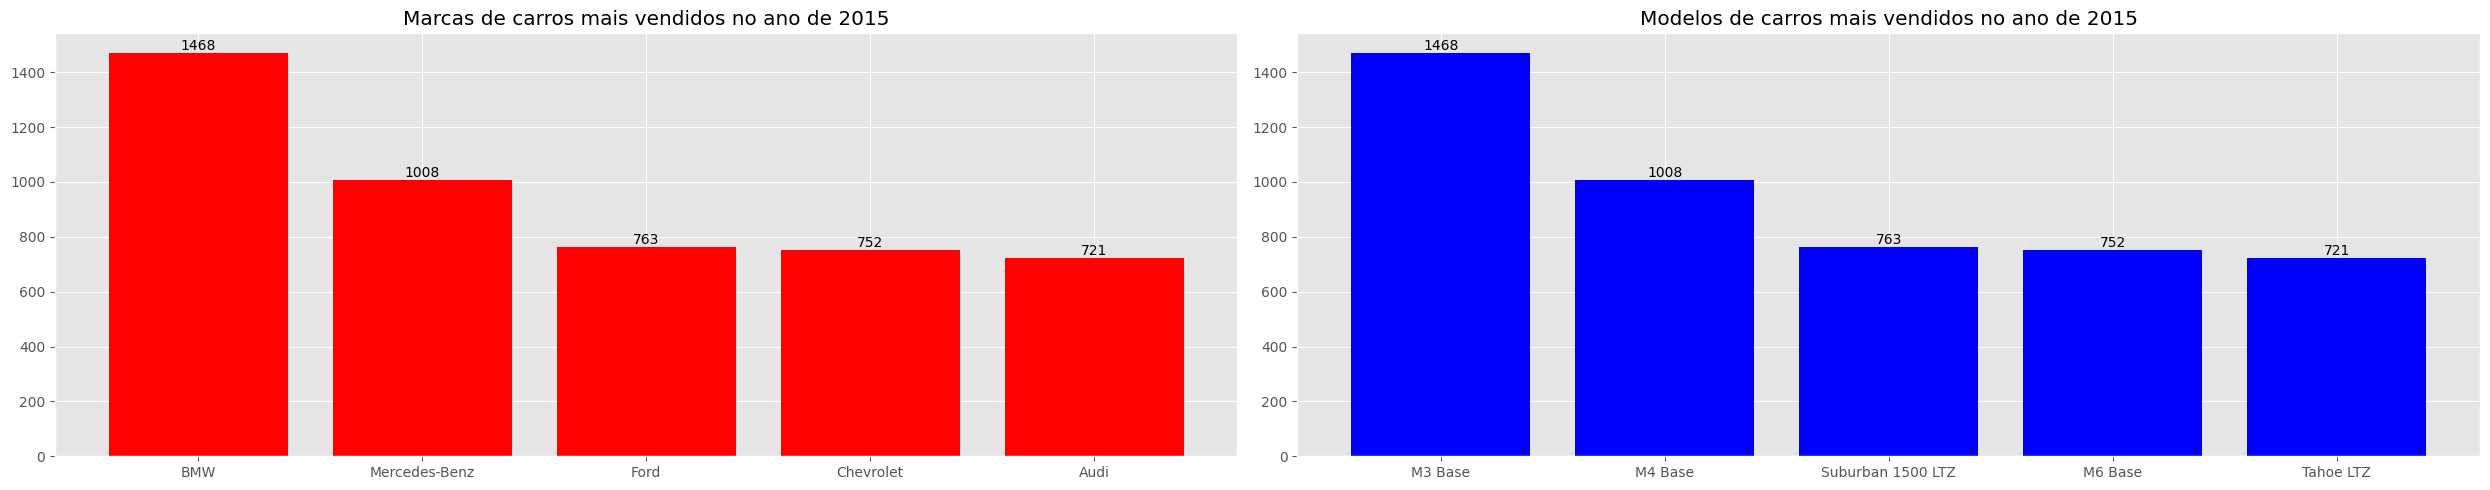

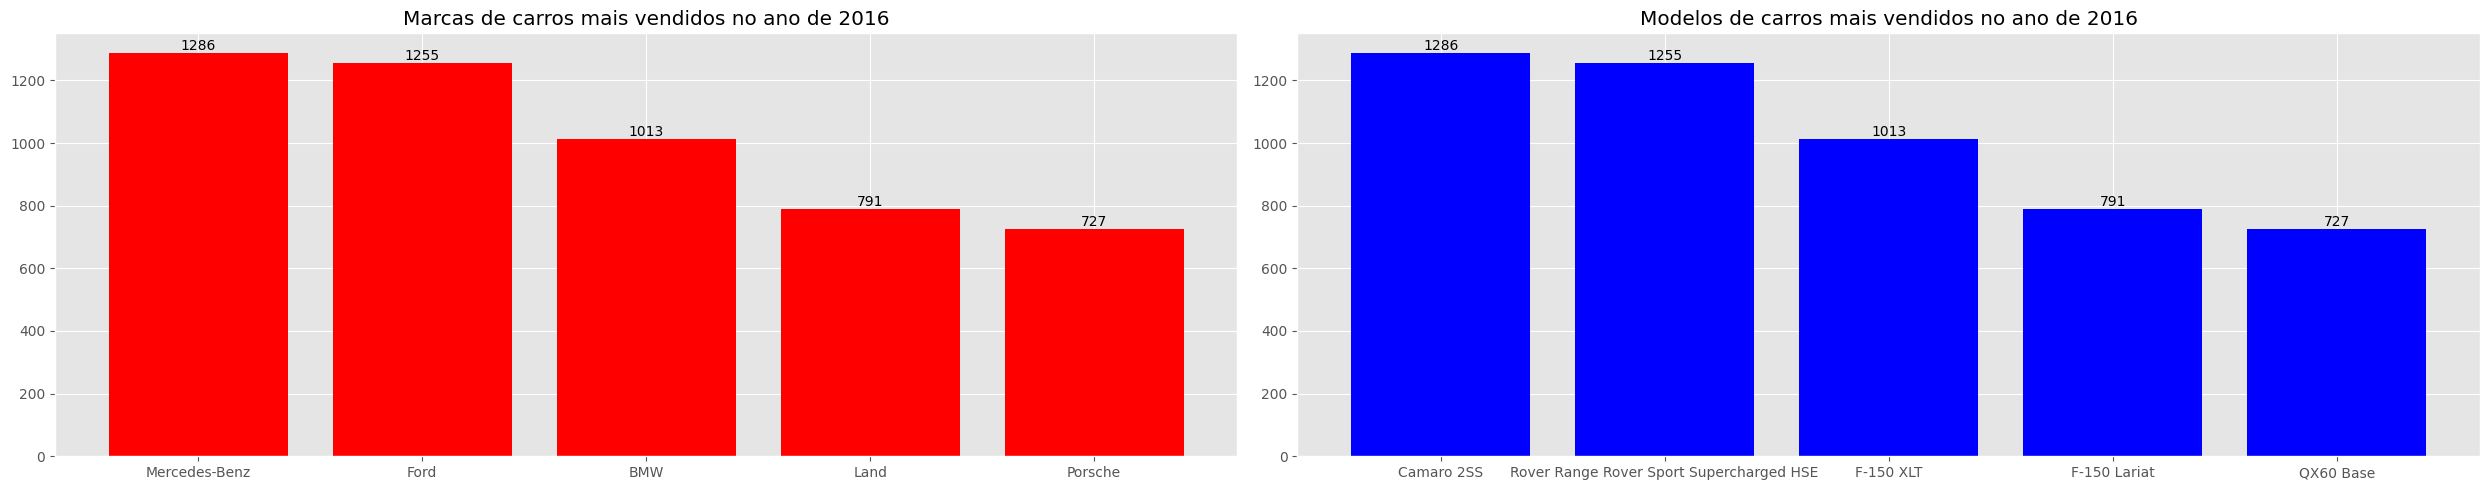

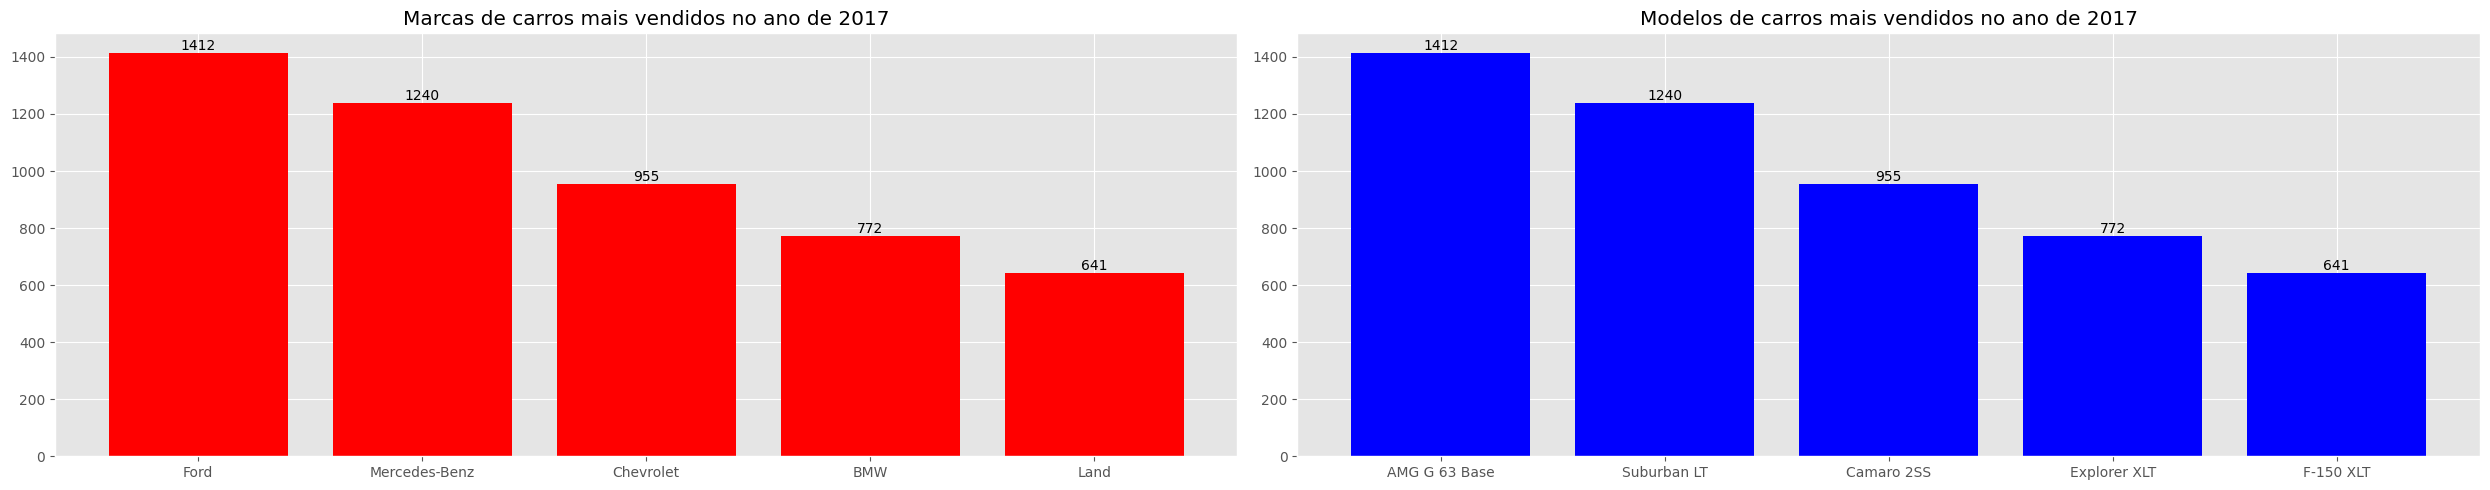

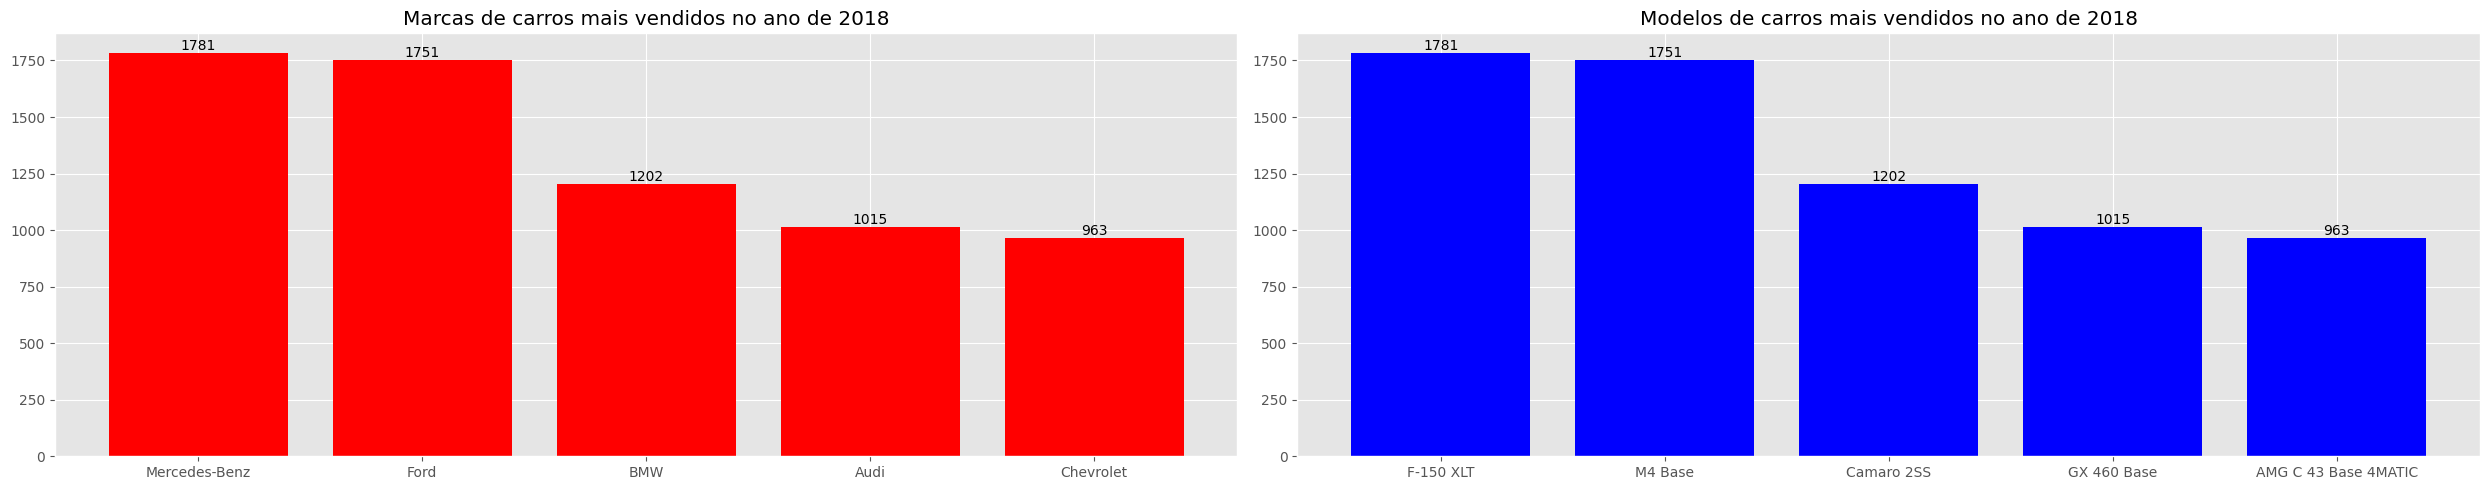

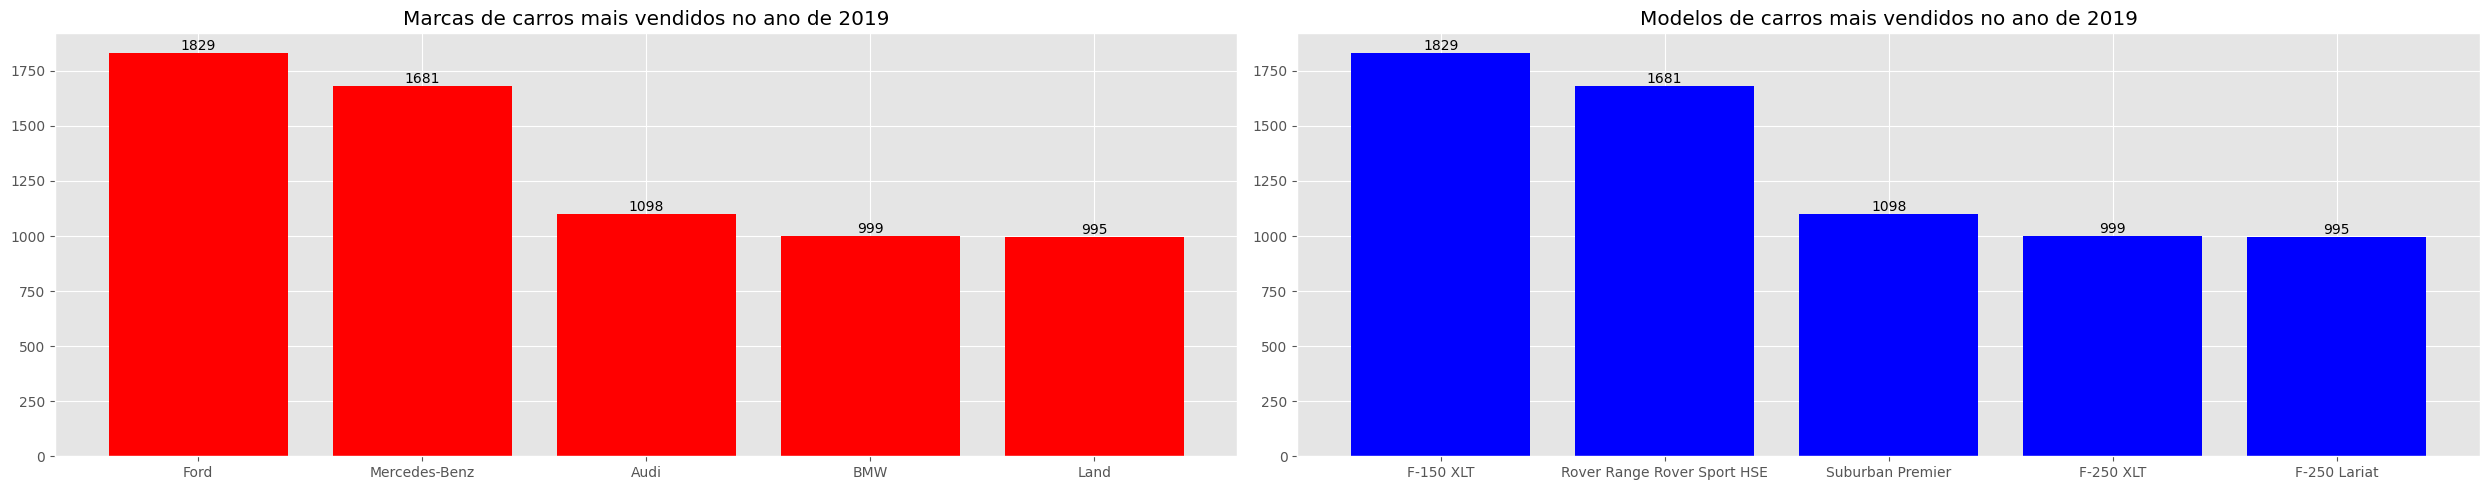

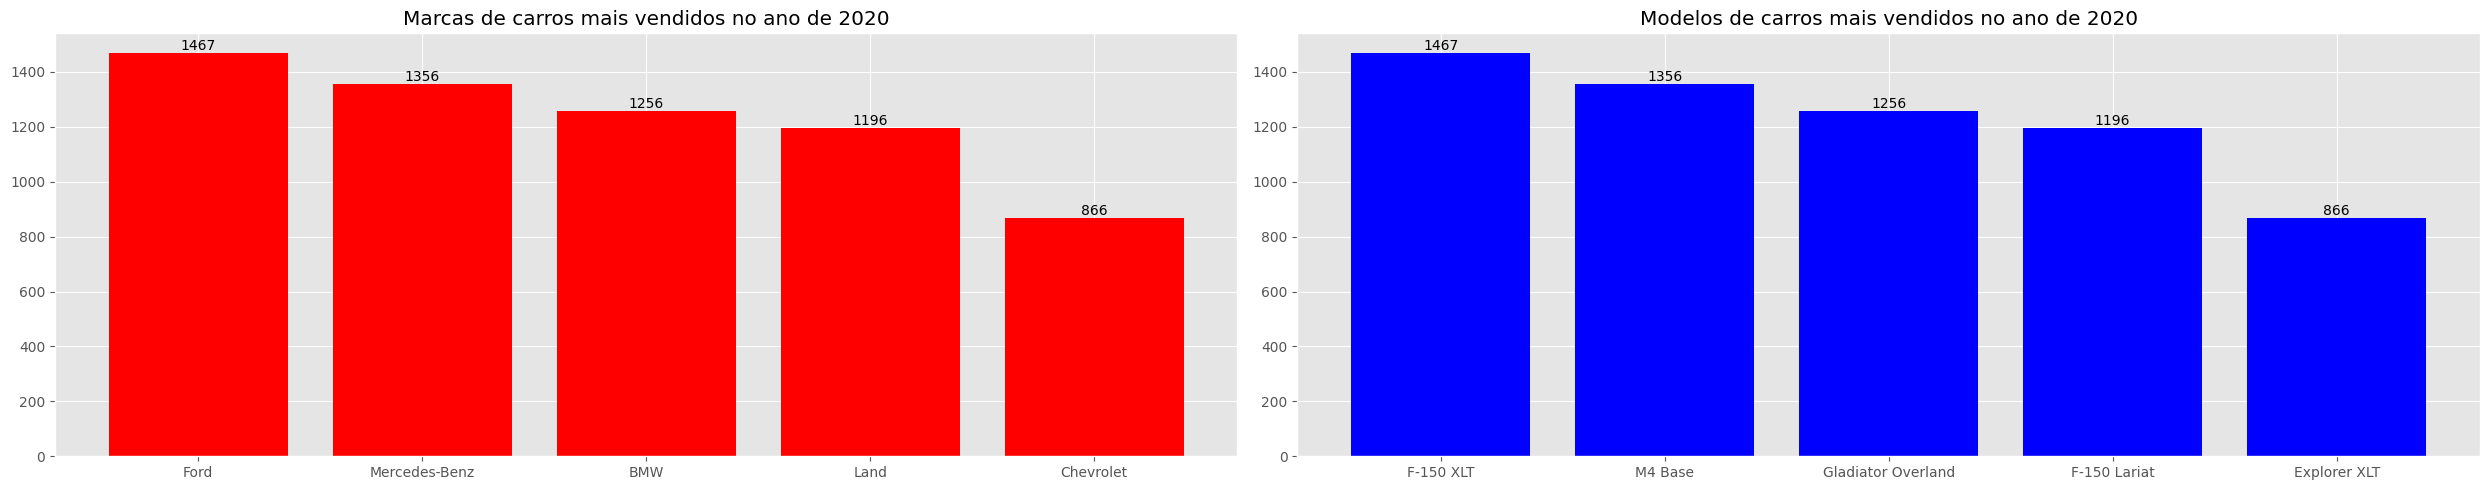

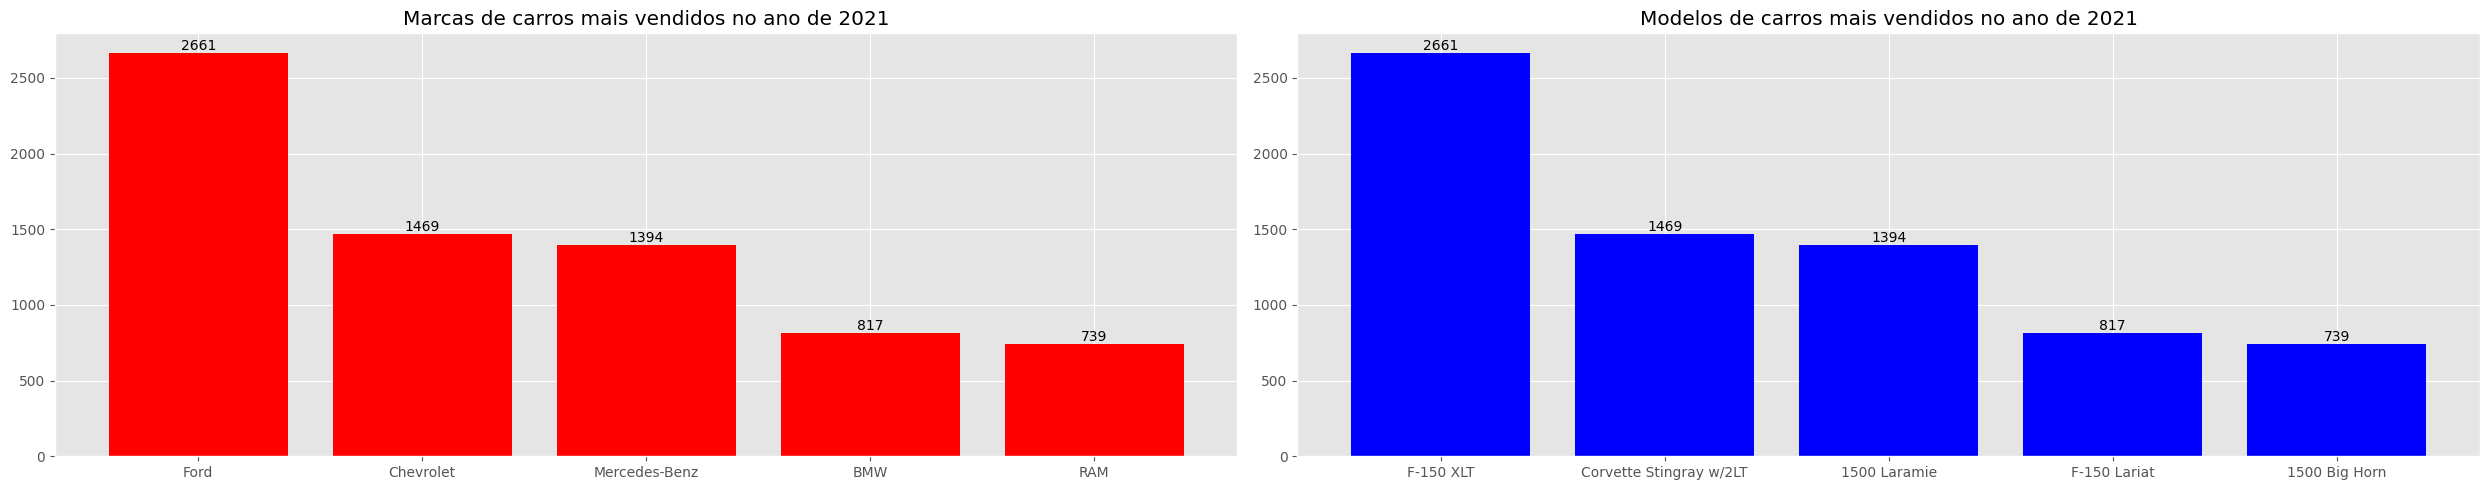

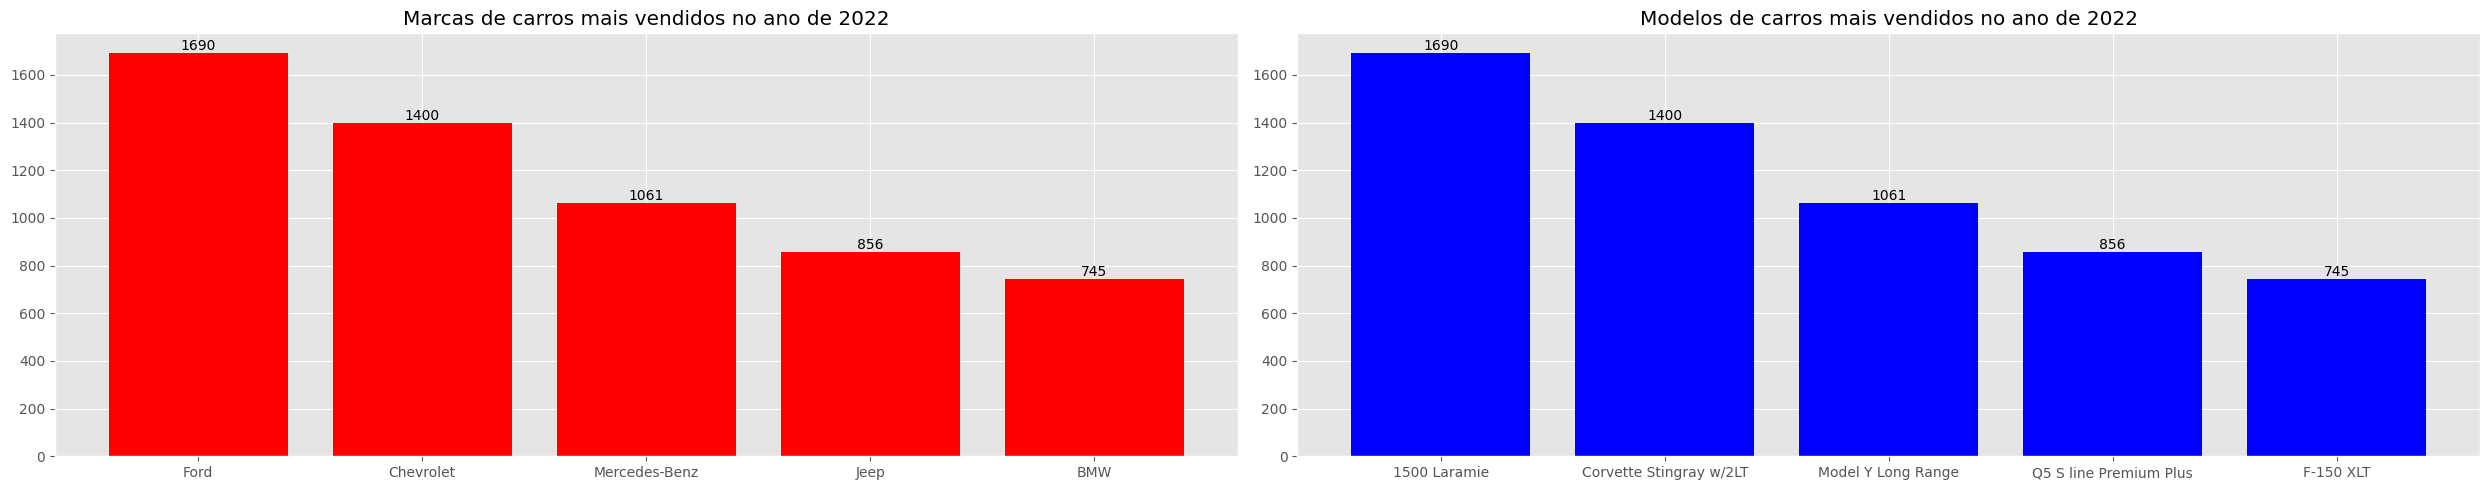

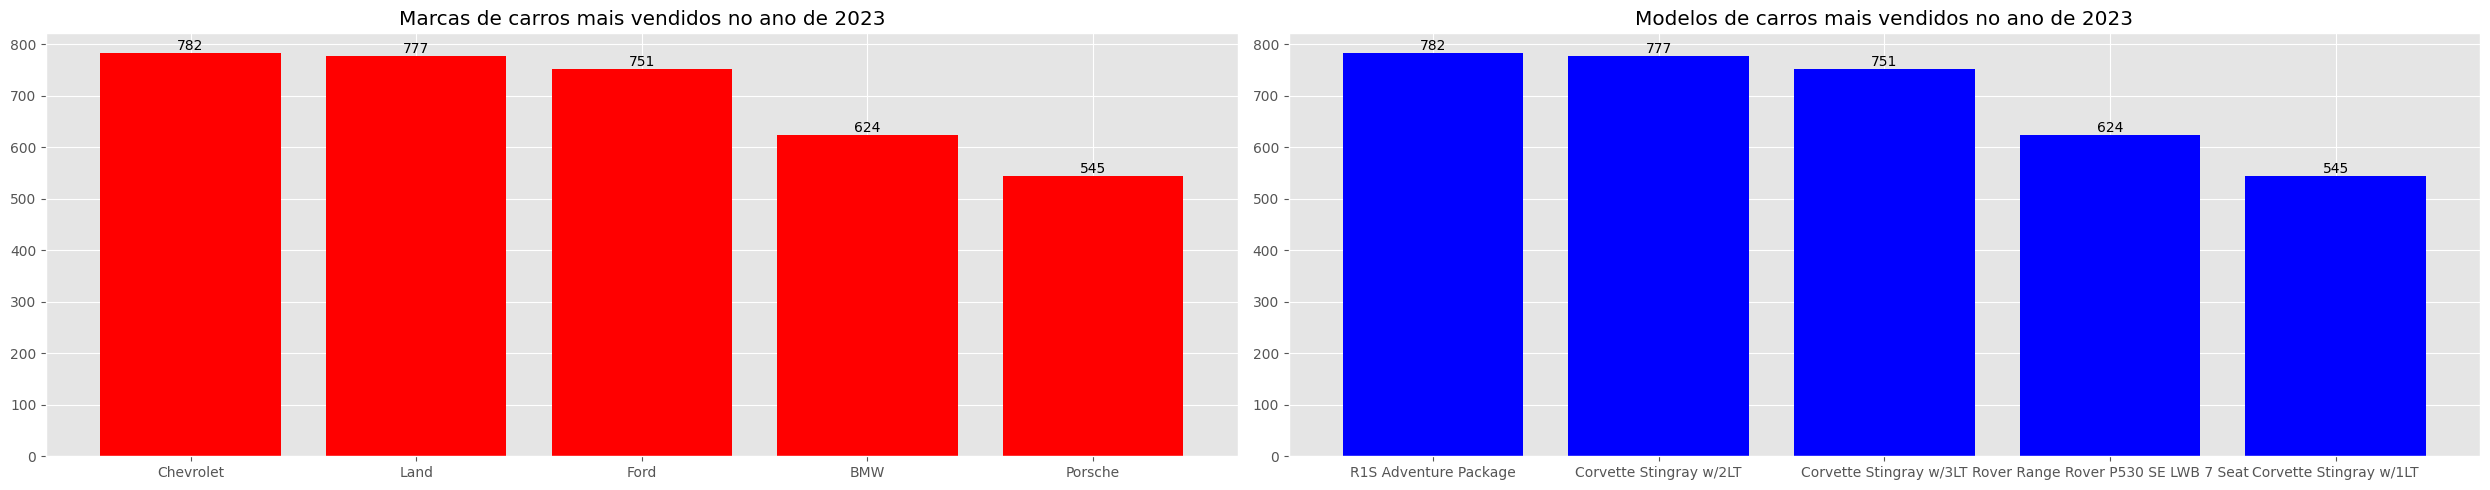

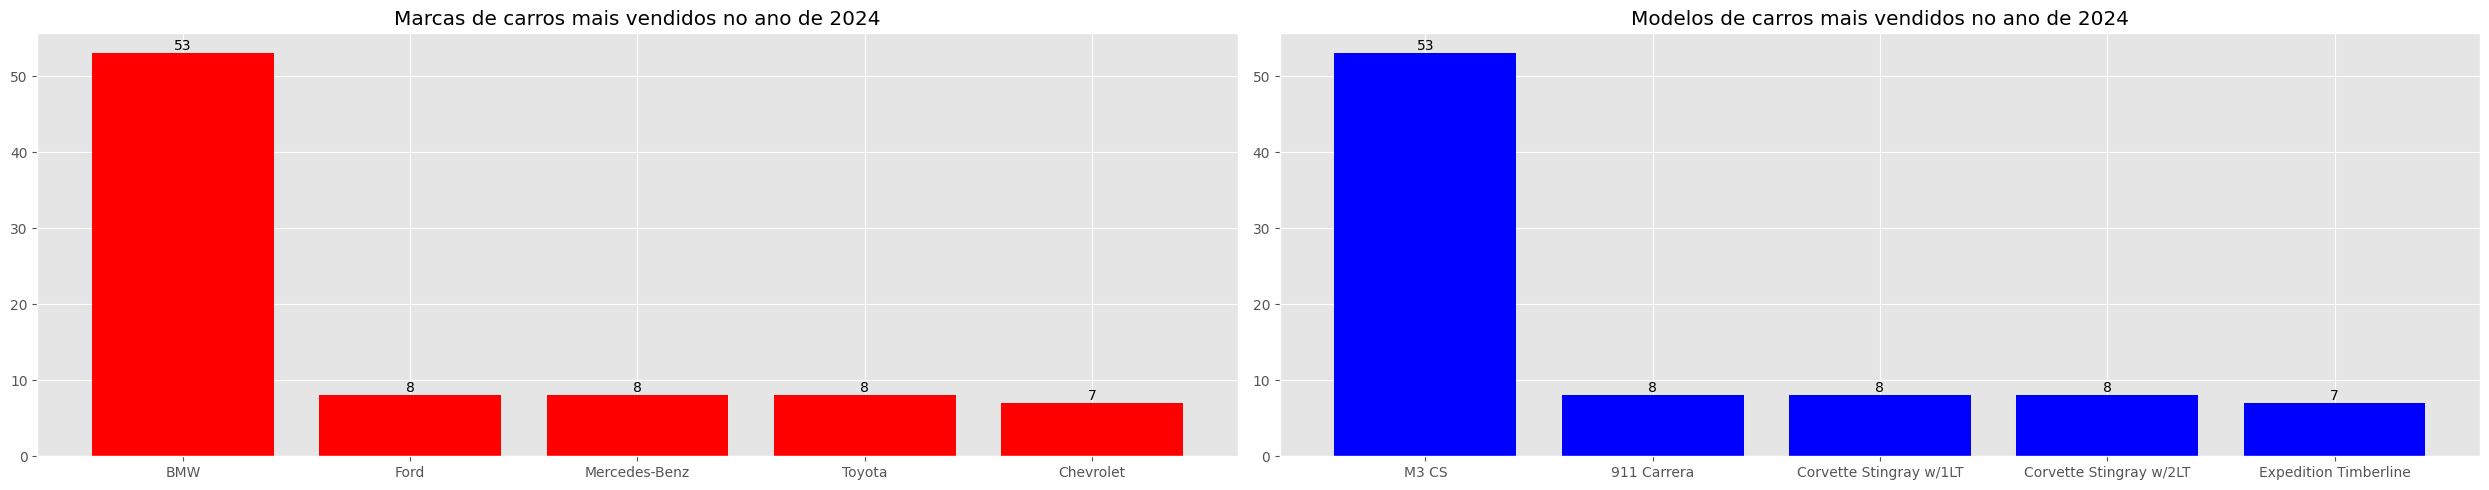

In [345]:
## os cincos modelos mais vendidos por ano
for ano  in sorted(train['model_year'].unique()):
    
    fig, axes = plt.subplots(1, 2, figsize=(25, 5))
    result_modelos = (
        train[train['model_year'] == int(ano)]
        .groupby("model_year")['model']
        .value_counts(ascending=False)
        .head(5)  # Pega as 5 primeiras ocorrências
        .reset_index(name='valor')  # Renomeia a coluna de contagem
    )
    
    result_marcas = (
            train[train['model_year'] == int(ano)]
            .groupby("model_year")['brand']
            .value_counts(ascending=False)
            .head(5)
            .reset_index(name='valor') 
        )

    axes[0].bar(result_marcas['brand'], result_marcas['valor'], color='red')
    axes[0].set_title(f'Marcas de carros mais vendidos no ano de {ano}')
    for index, value in zip(result_marcas['brand'], result_marcas['valor']):
        axes[0].text(index, value, f"{value:.0f}", ha="center", va="bottom")
    
    axes[1].bar(result_modelos['model'], result_marcas['valor'],color='blue')
    axes[1].set_title(f'Modelos de carros mais vendidos no ano de {ano}')
    for index, value in zip(result_modelos['model'], result_marcas['valor']):
        axes[1].text(index, value, f"{value:.0f}", ha="center", va="bottom")
    
    plt.tight_layout()
    plt.show()

Text(0.5, 1.0, 'As 20 marcas com a mediana de precos por ano mais caras.')

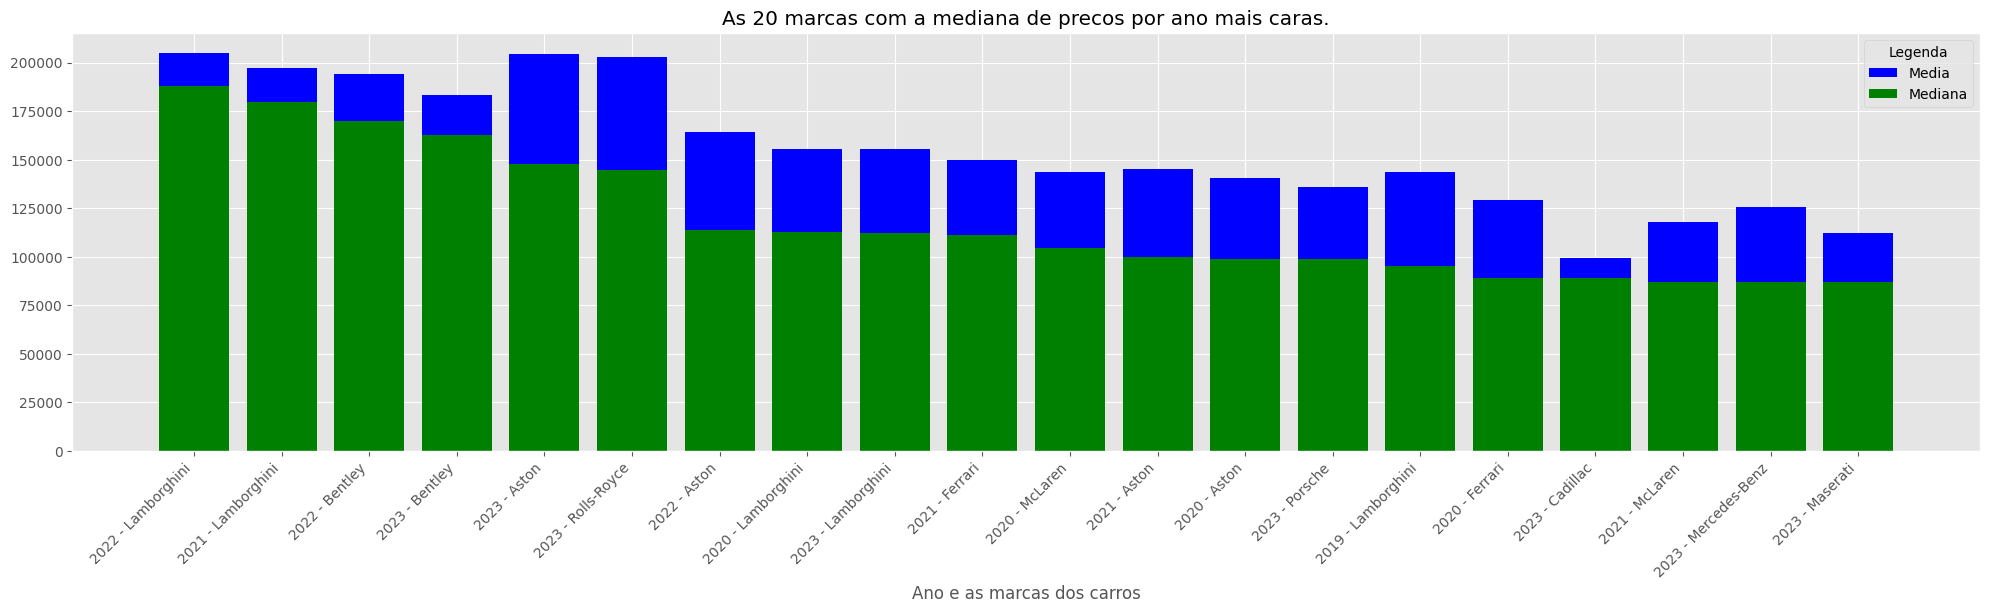

In [346]:

result = (
    train.groupby(["model_year", "brand"])['price']
    .agg(["mean", "median", "count"])
    .reset_index()
    .query('count > 10')
    .sort_values("median", ascending=False)
    .head(20)
    
)
eixo_x = [(str(ano)+' - '+ modelo) for ano, modelo in zip(result['model_year'], result['brand'])]
plt.figure(figsize=(20, 6))
plt.bar([(str(ano)+' - '+ modelo) for ano, modelo in zip(result['model_year'], result['brand'])], result['mean'],color='blue', label='Media')
plt.bar([(str(ano)+' - '+ modelo) for ano, modelo in zip(result['model_year'], result['brand'])], result['median'],color='green', label='Mediana')
plt.xlabel('Ano e as marcas dos carros')
plt.xticks(rotation=45, ha='right')
plt.legend(['Media', 'Mediana'],loc='upper right', title="Legenda", fontsize=10)
plt.tight_layout()
plt.title('As 20 marcas com a mediana de precos por ano mais caras.')

Text(0.5, 1.0, 'Os 20 modelos com a mediana de precos por ano mais caras.')

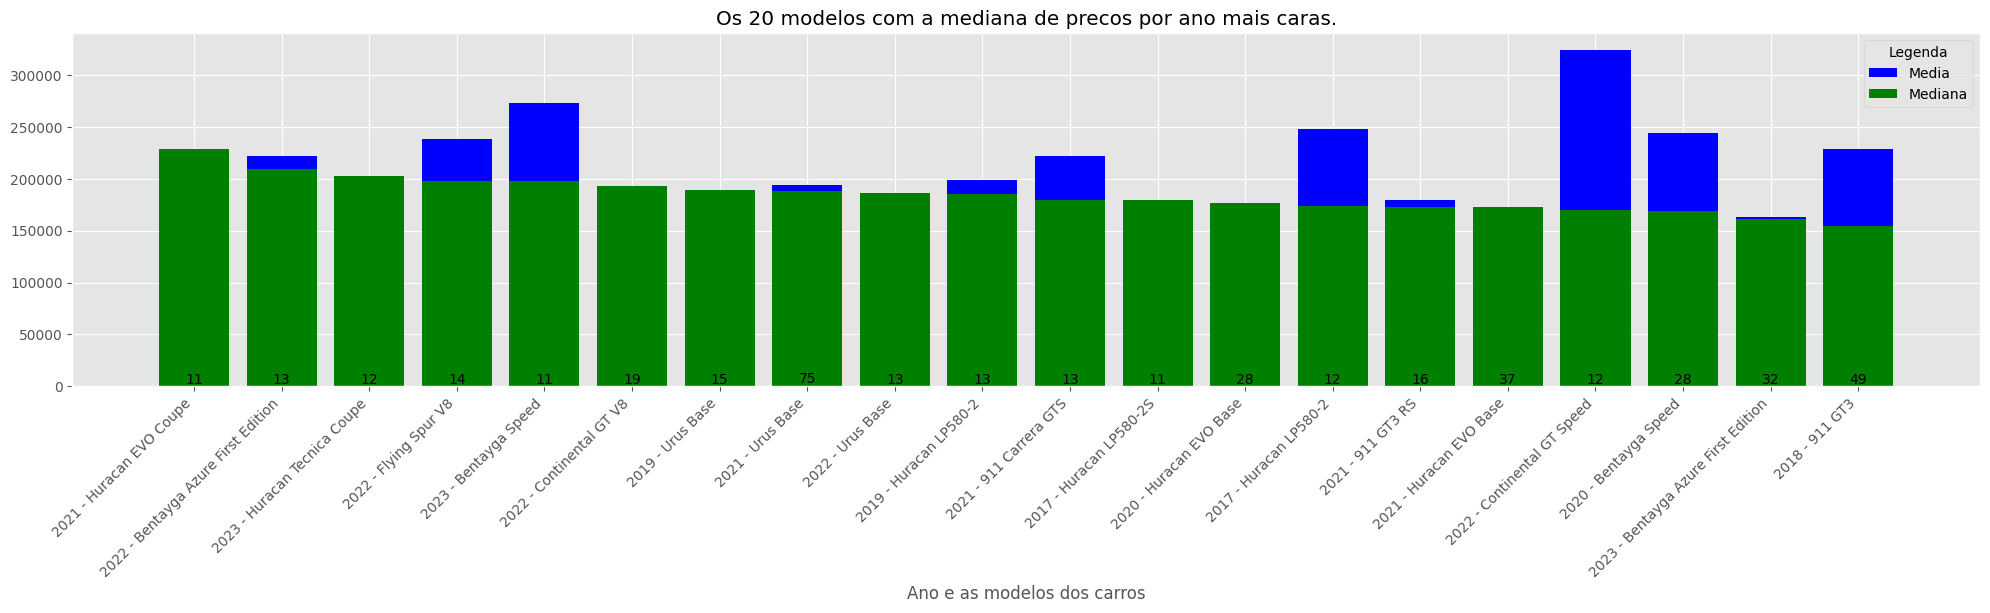

In [347]:
result = (
    train.groupby(["model_year", "model"])['price']
    .agg(["mean", "median", "count"])
    .reset_index()
    .query('count > 10')
    .sort_values("median", ascending=False)
    .head(20)
    
)
eixo_x = [(str(ano)+' - '+ modelo) for ano, modelo in zip(result['model_year'], result['model'])]
plt.figure(figsize=(20, 6))
plt.bar([(str(ano)+' - '+ modelo) for ano, modelo in zip(result['model_year'], result['model'])], result['mean'],color='blue', label='Media')
plt.bar([(str(ano)+' - '+ modelo) for ano, modelo in zip(result['model_year'], result['model'])], result['median'],color='green', label='Mediana')
eixo_x = [(str(ano)+' - '+ modelo) for ano, modelo in zip(result['model_year'], result['model'])]
for index, value in zip(eixo_x, result['count']):
    plt.text(index, value, f"{value:.0f}", ha="center", va="bottom")
plt.xlabel('Ano e as modelos dos carros')
plt.xticks(rotation=45, ha='right')
plt.legend(['Media', 'Mediana'],loc='upper right', title="Legenda", fontsize=10)
plt.tight_layout()
plt.title('Os 20 modelos com a mediana de precos por ano mais caras.')

In [348]:
## O carros mais carros
train.sort_values('price', ascending=False).head(10)

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
96438,Mercedes-Benz,AMG GLE AMG GLE 63 S-Model 4MATIC,2017,4590,Gasoline,577.0HP 5.5L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Gray,Black,None reported,Yes,2954083
114658,Lexus,SC 430 Base,2004,89500,Gasoline,300.0HP 4.3L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Black,None reported,Yes,2954083
67277,Pontiac,Firebird Trans Am,2001,64776,Gasoline,200.0HP 3.8L V6 Cylinder Engine Gasoline Fuel,4-Speed A/T,White,Beige,None reported,Yes,2954083
8611,Honda,Pilot Elite,2021,42653,Gasoline,3.5L V6 24V GDI SOHC,9-Speed Automatic,Gray,Black,NaN,NaN,2954083
89415,Ford,F-150 XLT,2021,26315,Gasoline,3.5L V6 24V PDI DOHC Twin Turbo,10-Speed Automatic,Agate Black Metallic,Black,None reported,Yes,2954083
83768,Audi,S4 Base,2004,73500,Gasoline,340.0HP 4.2L 8 Cylinder Engine Gasoline Fuel,6-Speed M/T,Blue,Beige,None reported,Yes,2954083
107021,Cadillac,Escalade Premium Luxury Platinum,2021,61830,Gasoline,6.2L V8 16V GDI OHV,10-Speed Automatic,Sandstone Metallic,Dark Auburn,None reported,Yes,2954083
7065,GMC,Sierra 1500 SLE1 Extended Cab,2020,2750,Gasoline,5.3L V8 16V GDI OHV,6-Speed Automatic,Red,Black,None reported,Yes,2954083
80924,Cadillac,XT5 Luxury,2021,16156,Gasoline,3.6L V6 24V MPFI DOHC,8-Speed Automatic,Shadow Black,Shara Beige,None reported,Yes,2954083
86204,Land,Rover Range Rover 3.0L V6 Supercharged HSE,2021,29850,Gasoline,380.0HP 3.0L V6 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,White,Black,None reported,Yes,2954083


In [349]:
## O carros mais barratos
train.sort_values('price', ascending=True).head(10)

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
82567,Nissan,350Z Touring,2001,42000,Gasoline,200.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,6-Speed M/T,Black,Orange,NaN,NaN,2000
94913,Pontiac,Firebird Base,1999,158000,Gasoline,200.0HP 3.8L V6 Cylinder Engine Gasoline Fuel,A/T,White,Beige,At least 1 accident or damage reported,Yes,2000
146866,Mazda,MX-5 Miata Base,1999,150000,Gasoline,140.0HP 1.8L 4 Cylinder Engine Gasoline Fuel,A/T,Silver,Black,At least 1 accident or damage reported,Yes,2000
29144,Honda,CR-V EX,2004,169613,Gasoline,150.0HP 2.4L 4 Cylinder Engine Gasoline Fuel,M/T,Silver,Gray,None reported,Yes,2000
13772,Toyota,Tundra SR5 Access Cab,2004,120000,Gasoline,282.0HP 4.7L 8 Cylinder Engine Gasoline Fuel,A/T,Red,–,None reported,Yes,2000
26303,Volvo,S60 R,2005,110000,Gasoline,230.0HP 4.7L 8 Cylinder Engine Gasoline Fuel,4-Speed A/T,Black,Beige,None reported,Yes,2000
144935,Ford,Excursion XLT 4WD,2002,205000,Gasoline,310.0HP 6.8L 10 Cylinder Engine Gasoline Fuel,A/T,Black,Beige,At least 1 accident or damage reported,Yes,2000
124068,Toyota,Camry Solara SLE V6,2006,114528,Gasoline,225.0HP 3.3L V6 Cylinder Engine Gasoline Fuel,A/T,Black,Gray,None reported,Yes,2000
107637,Chevrolet,Monte Carlo SS,2001,64776,Gasoline,200.0HP 3.8L V6 Cylinder Engine Gasoline Fuel,4-Speed A/T,Gray,Black,None reported,Yes,2000
59685,Kia,Optima EX,2000,130000,Gasoline,200.0HP 2.4L 4 Cylinder Engine Gasoline Fuel,A/T,Black,Beige,None reported,Yes,2000


In [350]:
## O carros mais rodados
train.sort_values('milage', ascending=False).head(10)

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
126607,Porsche,911 Carrera Cabriolet,1998,405000,Gasoline,300.0HP 3.4L Flat 6 Cylinder Engine Gasoline Fuel,6-Speed M/T,Blue,Black,None reported,Yes,124995
32468,Chevrolet,Camaro 1SS,2019,405000,Gasoline,455.0HP 6.2L 8 Cylinder Engine Gasoline Fuel,6-Speed M/T,Orange,Black,None reported,Yes,71950
54529,Volkswagen,Golf GTI 2.0T SE 4-Door,2016,405000,Gasoline,240.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,6-Speed M/T,Blue,Black,None reported,Yes,18000
60689,Volkswagen,CC 2.0T Sport,2016,405000,Gasoline,200.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,8-Speed A/T,White,Gray,At least 1 accident or damage reported,Yes,17500
98435,Mazda,MX-5 Miata Sport,2002,402000,Gasoline,142.0HP 1.8L 4 Cylinder Engine Gasoline Fuel,5-Speed M/T,White,Black,NaN,NaN,12500
1320,Mercedes-Benz,E-Class E 550,2016,399000,Gasoline,402.0HP 4.7L 8 Cylinder Engine Gasoline Fuel,7-Speed A/T,Gray,Black,None reported,Yes,26500
11337,Chevrolet,Tahoe LT,2010,399000,E85 Flex Fuel,355.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,6-Speed A/T,White,Black,At least 1 accident or damage reported,Yes,39990
69329,Mercedes-Benz,Sprinter Normal Roof,2013,399000,Diesel,188.0HP 3.0L V6 Cylinder Engine Diesel Fuel,5-Speed A/T,White,Black,At least 1 accident or damage reported,Yes,16800
11451,Mercedes-Benz,SL-Class SL63 AMG Roadster,2008,399000,Gasoline,518.0HP 6.3L 8 Cylinder Engine Gasoline Fuel,A/T,Black,Black,None reported,Yes,28500
3026,Mercedes-Benz,Sprinter 2500,2012,399000,Diesel,188.0HP 3.0L V6 Cylinder Engine Diesel Fuel,A/T,Silver,Black,None reported,Yes,17700


In [351]:
## O carros menos rodado
train.sort_values('milage', ascending=True).head(10)

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
77138,Porsche,911 Carrera S,2023,100,Gasoline,3.0L H6 24V GDI DOHC Twin Turbo,8-Speed Automatic,Red,Black,None reported,NaN,77430
36403,Tesla,Model Y Long Range,2021,100,NaN,425.0HP Electric Motor Electric Fuel System,A/T,Silver,White,None reported,Yes,24000
36405,Kia,Telluride LX,2023,100,Gasoline,291.0HP 3.8L V6 Cylinder Engine Gasoline Fuel,A/T,Green,Gray,None reported,Yes,98900
111061,Rivian,R1S Adventure Package,2023,100,NaN,557.0HP Electric Motor Electric Fuel System,1-Speed A/T,Blue,Black,None reported,Yes,72999
82289,Audi,Q8 55 Premium Plus,2023,100,Hybrid,335.0HP 3.0L V6 Cylinder Engine Gasoline/Mild ...,8-Speed A/T,Gray,Red,None reported,Yes,75000
74290,Lexus,RX 350 Base,2022,100,Gasoline,295.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,6-Speed A/T,Silver,Black,None reported,Yes,66200
44896,GMC,Sierra 1500 AT4,2023,100,Gasoline,401.0HP 6.6L 8 Cylinder Engine Gasoline Fuel,A/T,Blue,Black,None reported,Yes,23500
61338,Tesla,Model 3 Long Range,2021,100,NaN,271.0HP Electric Motor Electric Fuel System,A/T,White,Black,None reported,Yes,29999
1504,BMW,750 i xDrive,2023,100,Gasoline,445.0HP 4.4L 8 Cylinder Engine Gasoline Fuel,A/T,Black,Black,None reported,Yes,188500
139069,Dodge,Viper SRT-10,2005,100,Gasoline,500.0HP 8.3L 10 Cylinder Engine Gasoline Fuel,6-Speed M/T,Orange,Gray,None reported,Yes,60500


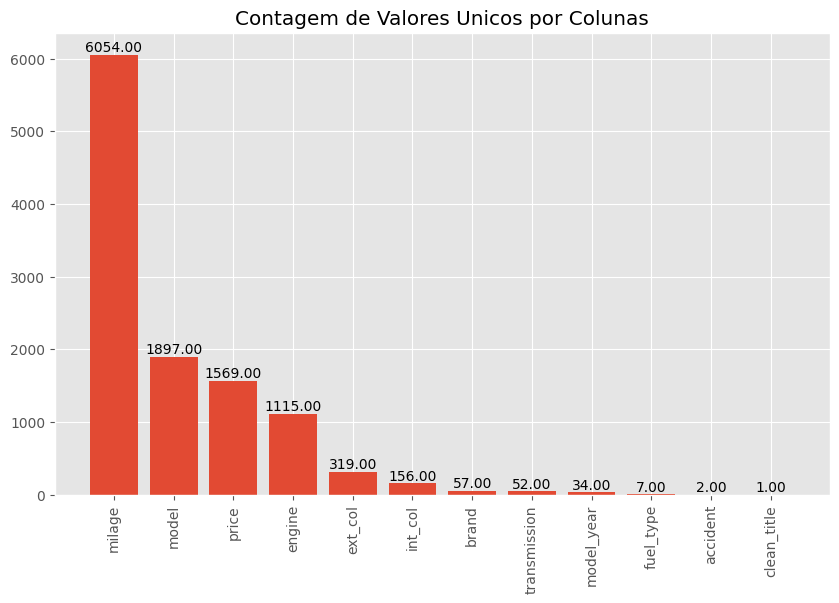

In [25]:
train_nunique = train.nunique().sort_values(ascending=False)

plt.figure(figsize=(10, 6))

plt.bar(train_nunique.index, train_nunique.values)
plt.title("Contagem de Valores Unicos por Colunas")
plt.tick_params(axis="x", rotation=90)
for index, value in enumerate(train_nunique.values):
    plt.text(index, value, f"{value:.2f}", ha="center", va="bottom")


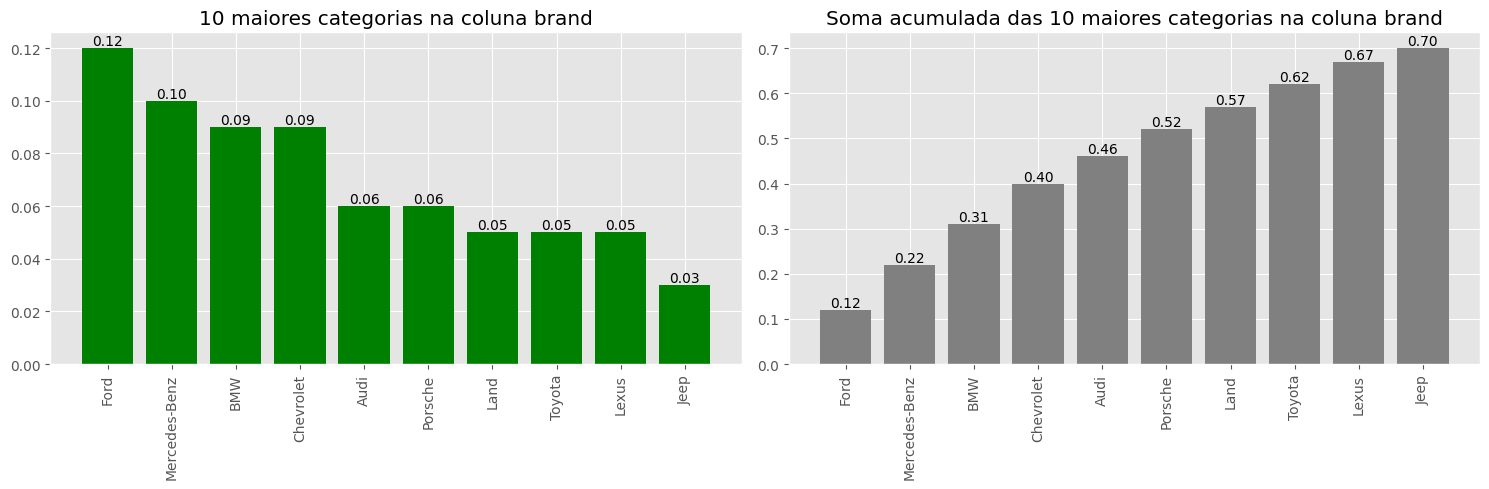

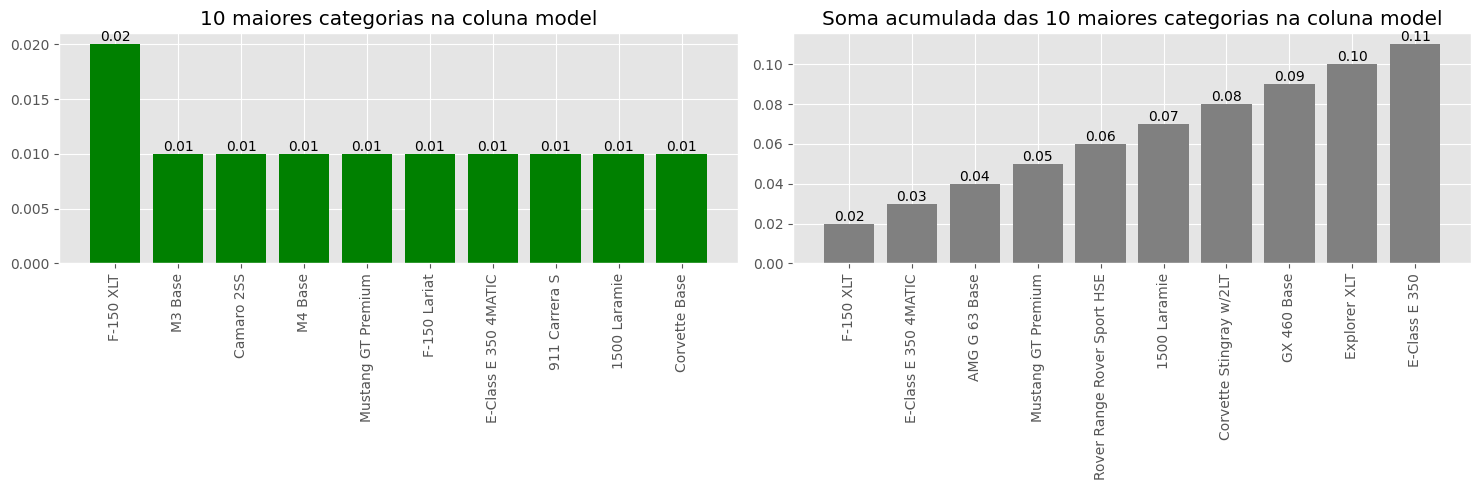

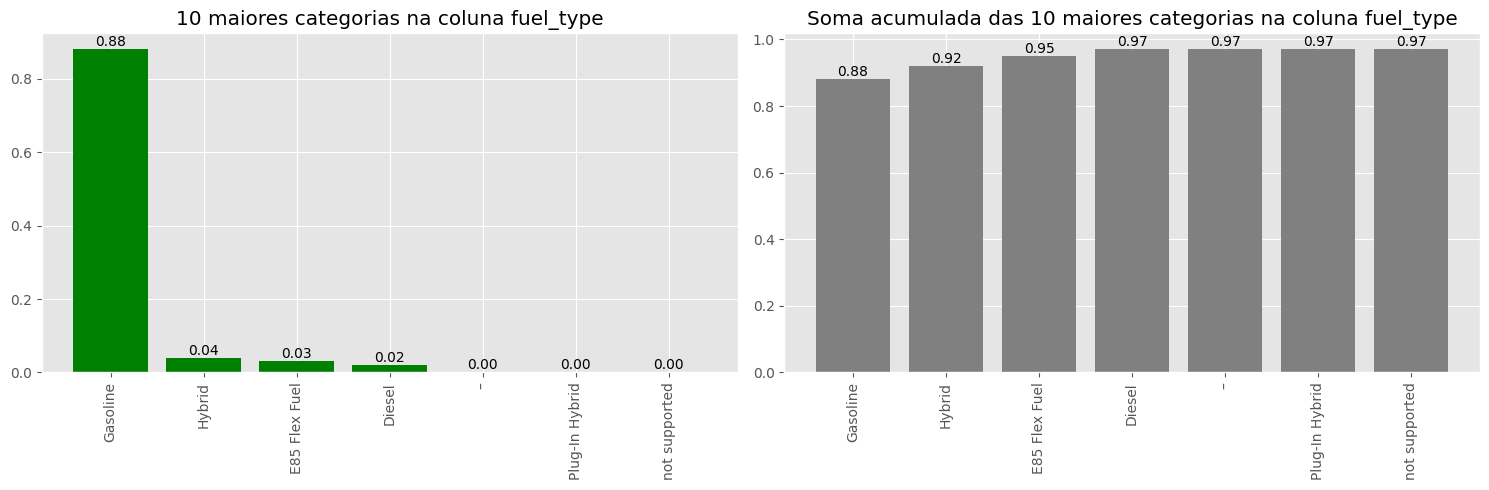

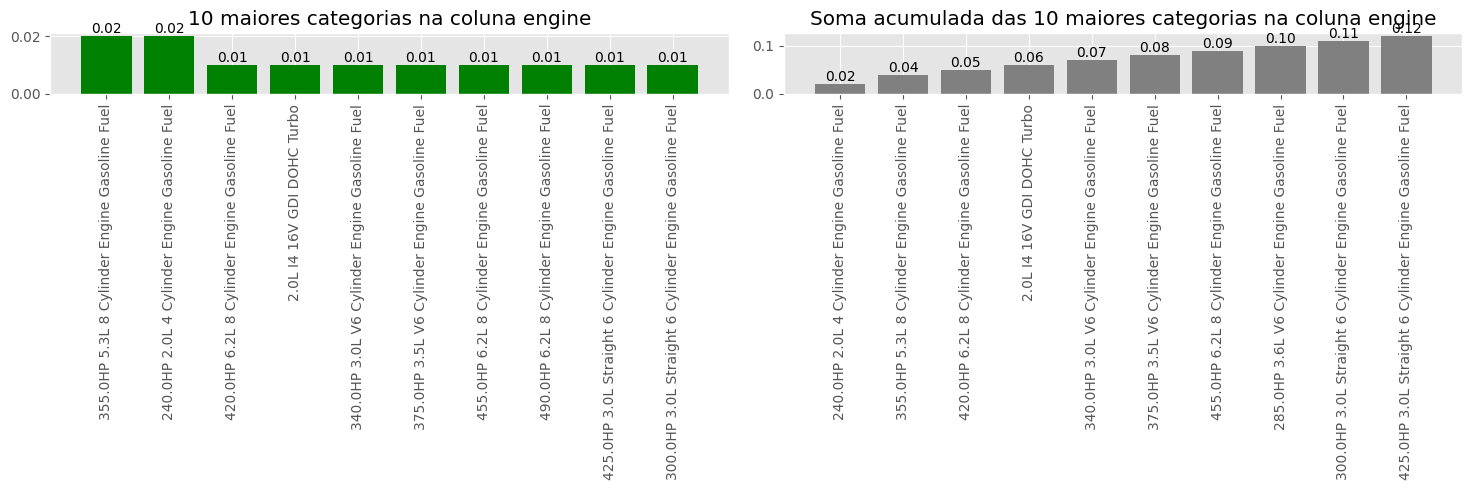

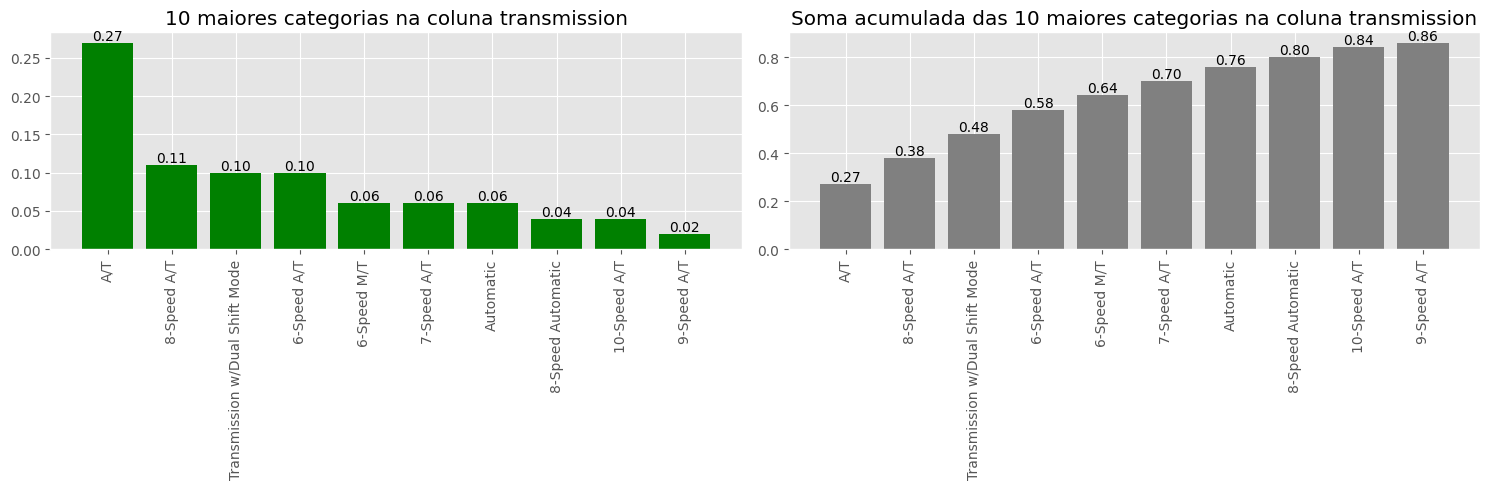

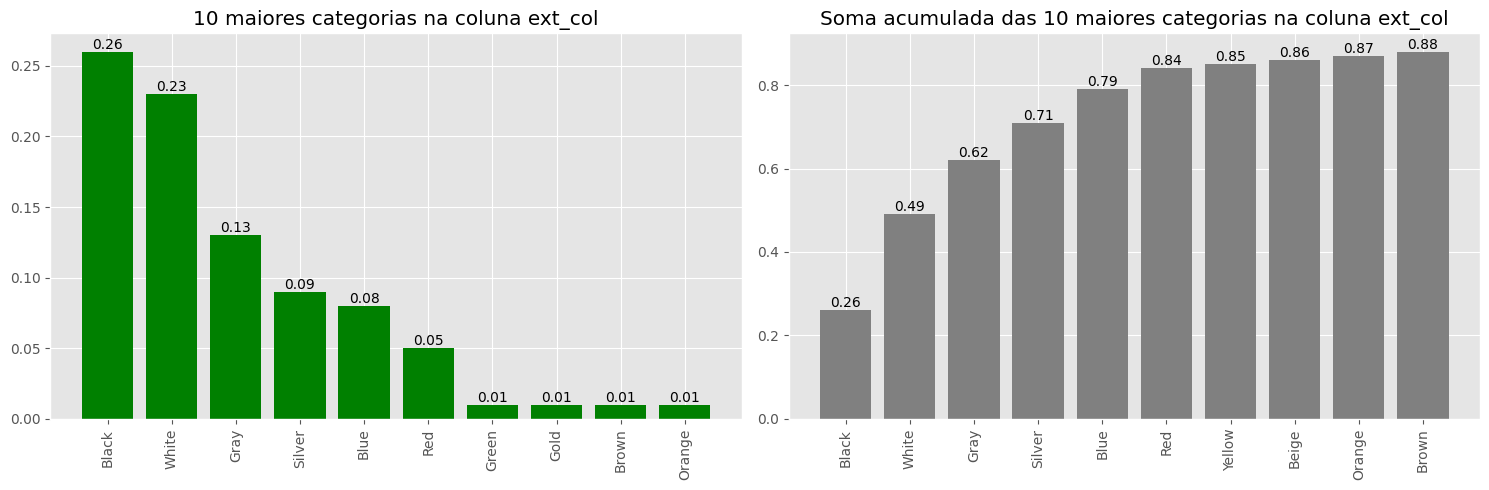

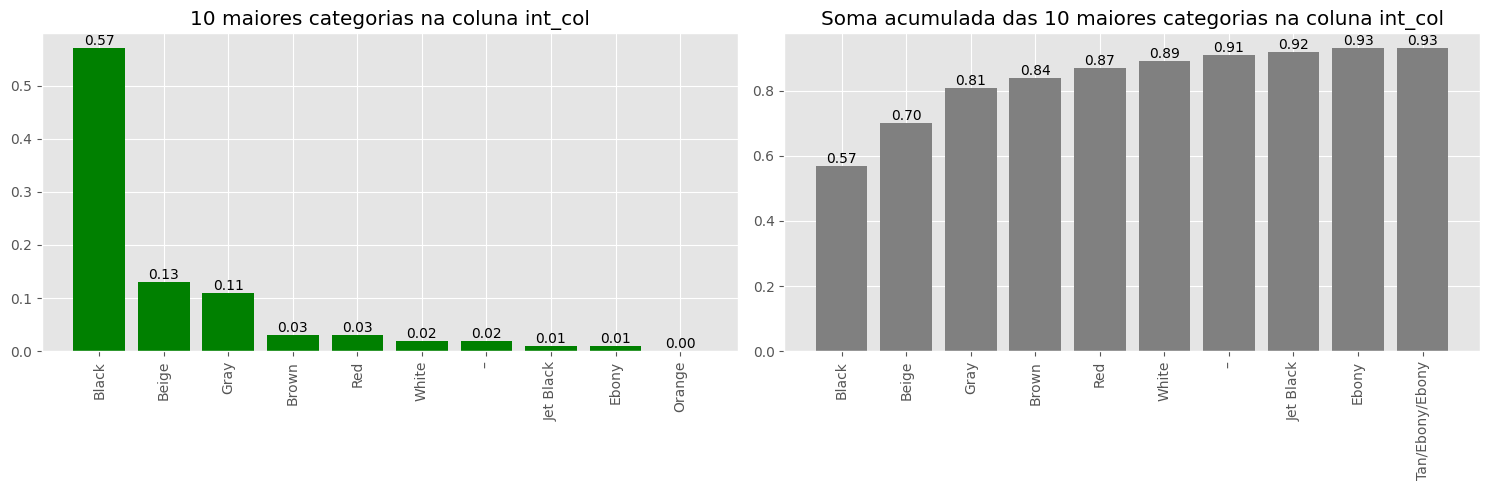

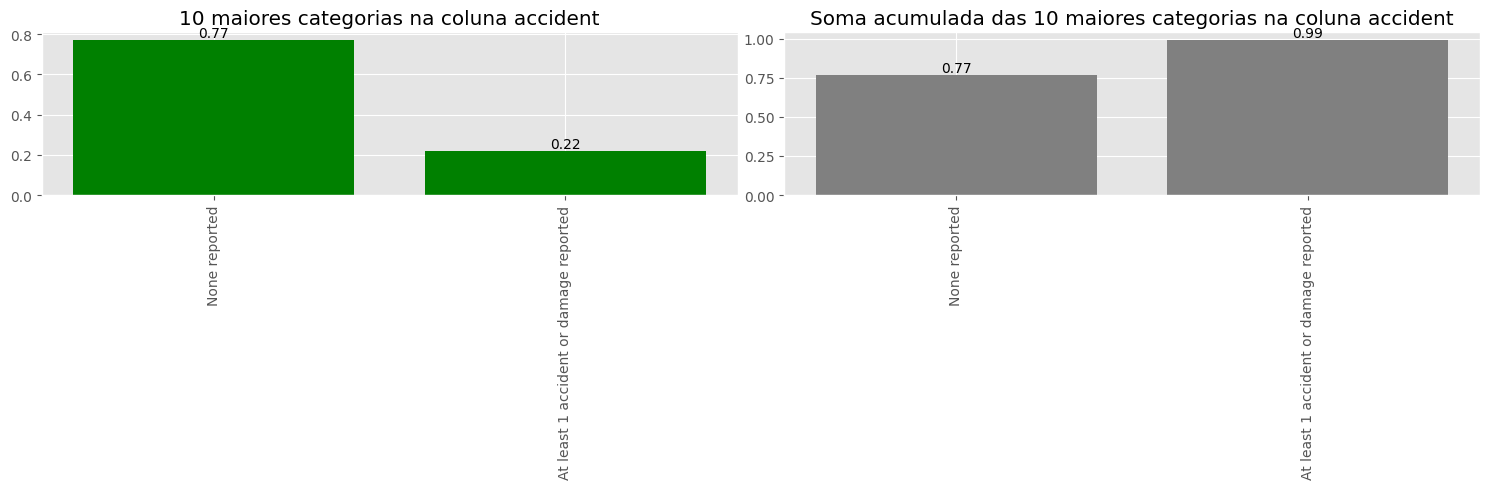

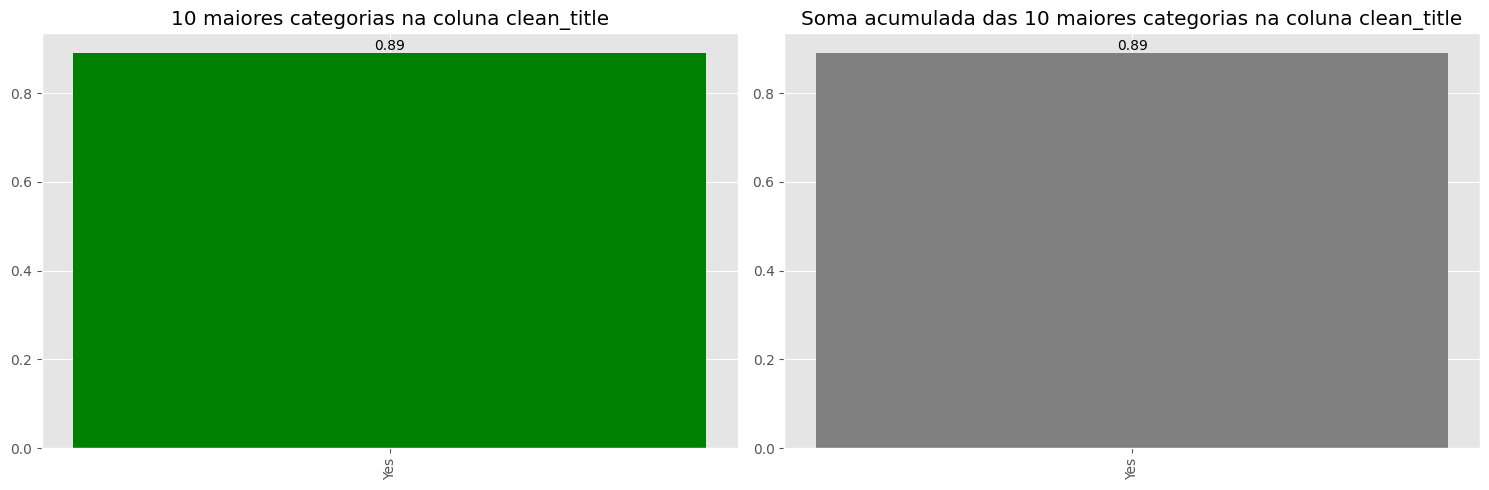

In [352]:
for col in train.columns:
    if train[col].dtype != "int64":
        fig, axes = plt.subplots(1, 2, figsize=(15, 5))
        
        train_class = (
                round(train[col].value_counts() / train.shape[0], 2)
                .head(10)
                .sort_values(ascending=False)
            )
        
        train_cumsum = (
            round(train[col].value_counts() / train.shape[0], 2)
            .sort_values(ascending=False)
            .cumsum()
            .head(10)
        )
        
        
        axes[0].bar(train_class.index, train_class.values, color="green", label="train")
        axes[0].set_title(f"10 maiores categorias na coluna {col}")
        axes[0].tick_params(axis="x", rotation=90)
        for index, value in enumerate(train_class.values):
            axes[0].text(index, value, f"{value:.2f}", ha="center", va="bottom")

        axes[1].bar(
            train_cumsum.index, train_cumsum.values, color="gray", label="train"
        )
        axes[1].set_title(f"Soma acumulada das 10 maiores categorias na coluna {col}")
        axes[1].tick_params(axis="x", rotation=90)
        for index, value in enumerate(train_cumsum.values):
            axes[1].text(index, value, f"{value:.2f}", ha="center", va="bottom")

        plt.tight_layout()
        plt.show()
   


In [353]:
## Criando novas variáveis
# potencia do motor
train['hp'] = pd.to_numeric([float(i[0].split('HP')[0]) if 'HP' in i[0] else None for i in train['engine'].str.split(' ')],errors='coerce')
## Litros de combustível
train['litros'] = pd.to_numeric([i[1].split('L')[0] if 'HP' in i[0] else i[0].split('L')[0] for i in train['engine'].str.split(' ')],errors='coerce')
# Idade do carro em anos
train['idade_carro'] = datetime.datetime.now().year - train.model_year
## Quantas valvulas tem o motor 

lista_engine = []
for t in train['engine'].str.split(' '):
    if 'HP' in t[0]:
        if 'Straight' in t[2] or 'Flat' in t[2] or 'Cylinder' in t[2]:
            lista_engine.append(t[3])
        elif 'Electric' in t[0] or 'Electric' in t[1]:
            lista_engine.append('e')
        else:
            lista_engine.append(t[2])
    elif 'L' in t[0]:
        try:
            if 'Straight' in t[1] or 'Flat' in t[1] or 'Cylinder' in t[1]:
                lista_engine.append(t[2])
            else:
                lista_engine.append(t[1])
        except IndexError:
            lista_engine.append('None')
                
    elif len(t) > 1:
        if  'Liter' in t[1]:
            lista_engine.append('None')
        else:
            lista_engine.append(t)
    elif 'Electric' == t[0]:
        lista_engine.append('e')
 
    elif 'Intercooled' == t[0]:
        lista_engine.append(t[3])
    elif 'Dual' == t[0]:
        lista_engine.append('None')
    else:
        lista_engine.append('None')

train['cilindros'] = lista_engine
train['cilindros'] = pd.to_numeric(train['cilindros'].str.replace(r'[VIHW]', '', regex=True).str.replace('Electric', 'e').str.replace('Rotary', 'None'),errors='coerce')
                            

<Axes: >

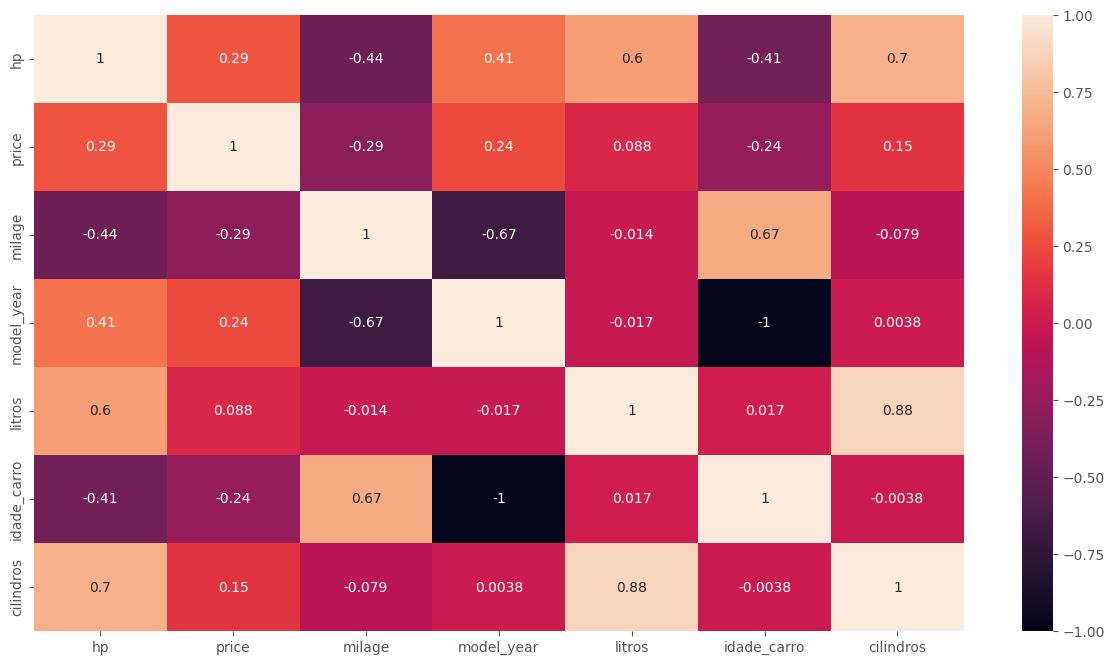

In [354]:
plt.figure(figsize=(15,8))
sns.heatmap(train[['hp','price','milage','model_year','litros','idade_carro','cilindros']].corr(), annot=True)

 - Olhando a potência, percebemos que quanto mais potente um carro for, mais caro o mesmo vai ser.

 - Já olhando a distância, percebemos que quanto mais distancia um veículo percorre, mais barato o mesmo vai ser.

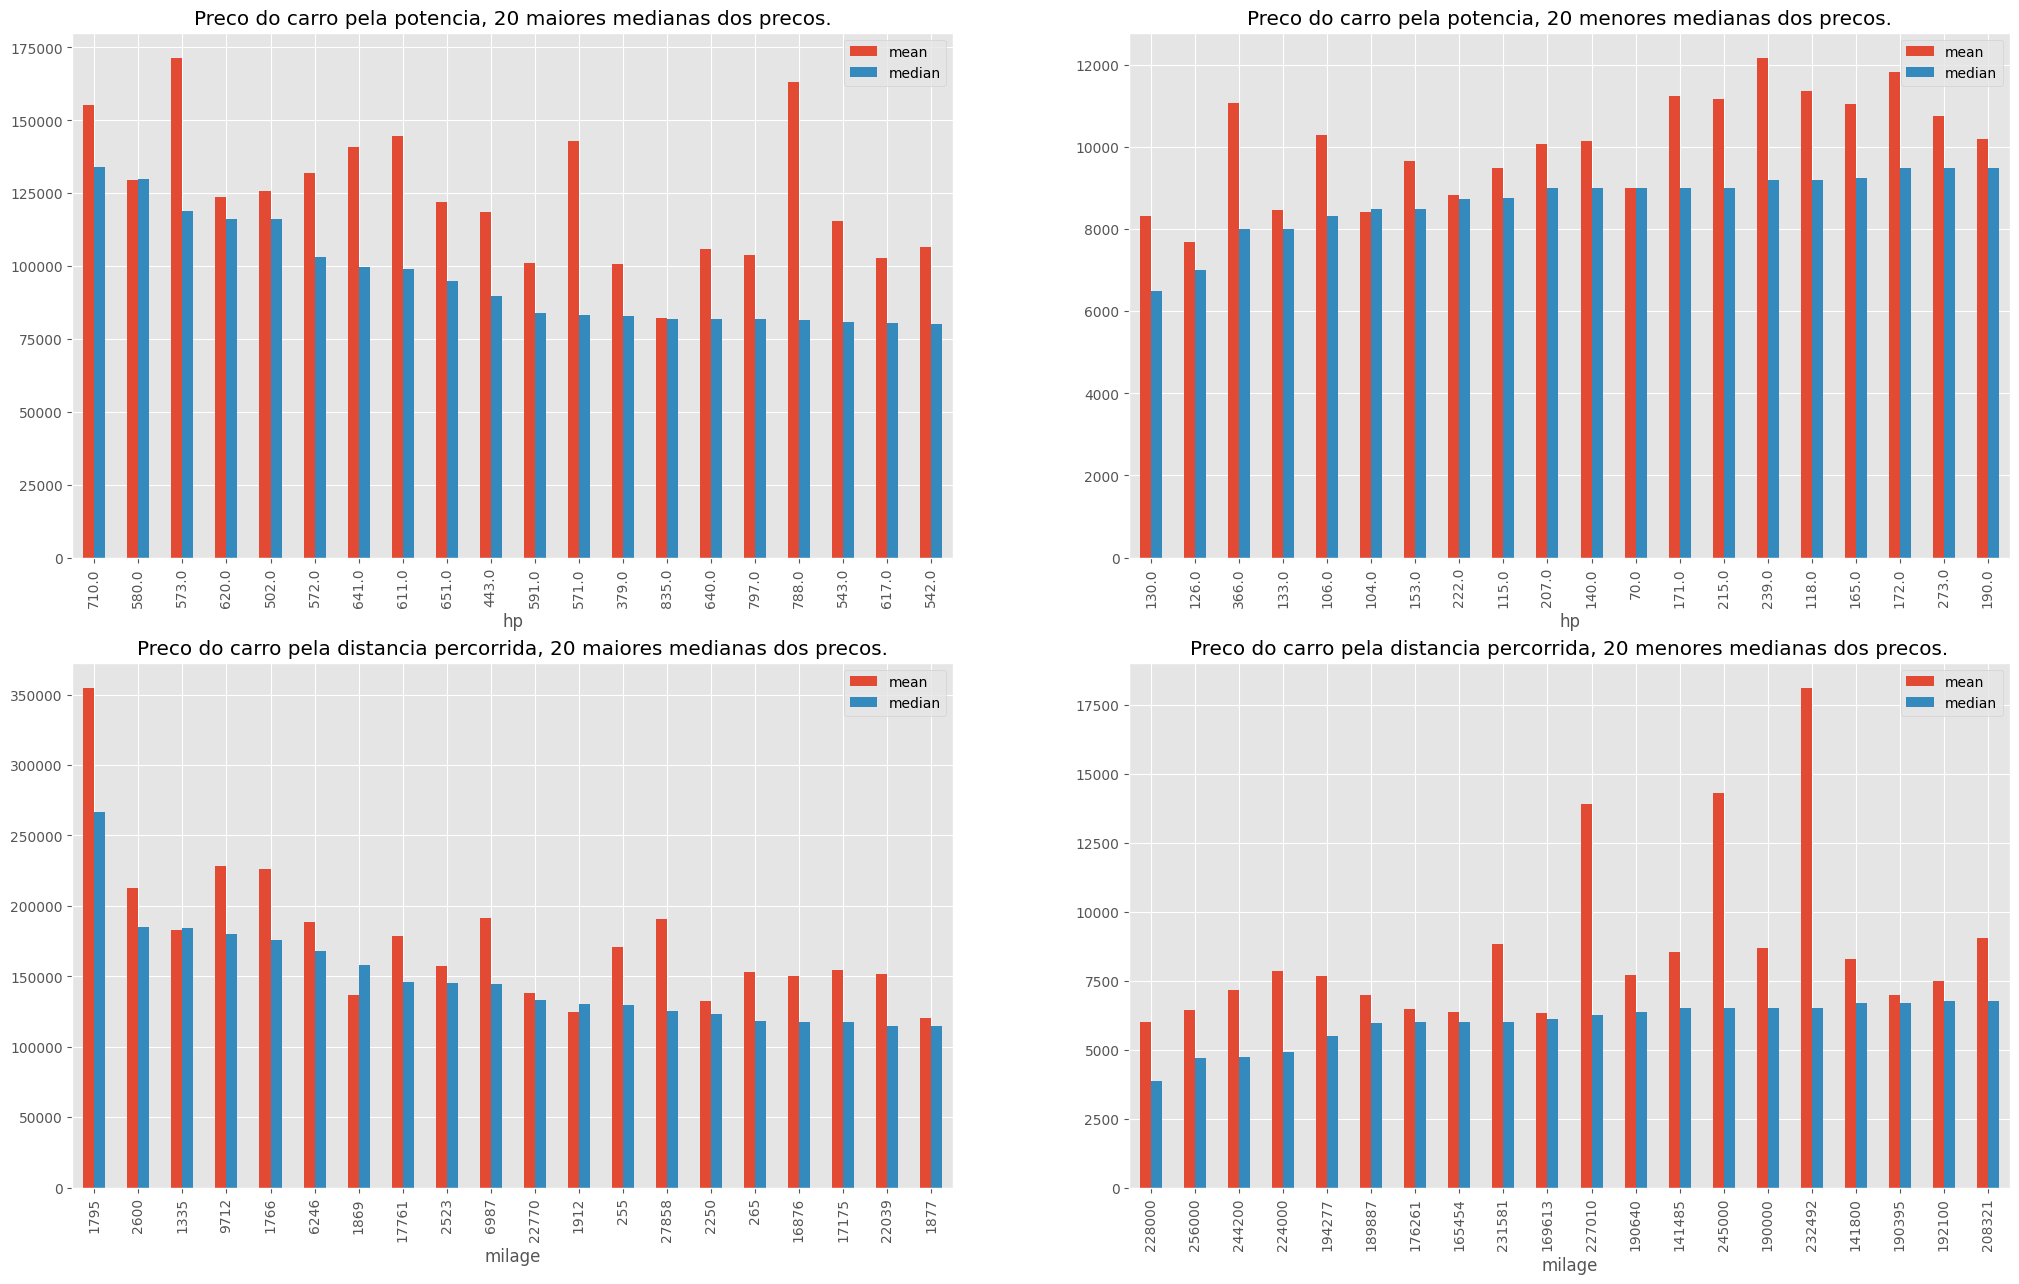

In [355]:
preco_potencia_superio = train.groupby(['hp'])['price'].agg(['mean', 'median', 'count']).sort_values(by='median',ascending=False).head(20)
preco_potencia_inferior = train.groupby(['hp'])['price'].agg(['mean', 'median', 'count']).sort_values(by='median',ascending=True).head(20)
preco_distancia_superio = train.groupby(['milage'])['price'].agg(['mean', 'median', 'count']).query('count > 10').sort_values(by='median',ascending=False).head(20)
preco_distancia_inferior = train.groupby(['milage'])['price'].agg(['mean', 'median', 'count']).query('count > 10').sort_values(by='median',ascending=True).head(20)

fig, axes = plt.subplots(2, 2, figsize=(25, 15))

preco_potencia_superio[['mean', 'median']].plot(kind='bar',ax=axes[0][0])
axes[0][0].set_title('Preco do carro pela potencia, 20 maiores medianas dos precos.')
axes[0][0].tick_params(axis="x", rotation=90)
    
    
preco_potencia_inferior[['mean', 'median']].plot(kind='bar',ax=axes[0][1])
axes[0][1].set_title('Preco do carro pela potencia, 20 menores medianas dos precos.')
axes[0][1].tick_params(axis="x", rotation=90)


preco_distancia_superio[['mean', 'median']].plot(kind='bar',ax=axes[1][0])
axes[1][0].set_title('Preco do carro pela distancia percorrida, 20 maiores medianas dos precos.')
axes[1][0].tick_params(axis="x", rotation=90)
    
    
preco_distancia_inferior[['mean', 'median']].plot(kind='bar',ax=axes[1][1])
axes[1][1].set_title('Preco do carro pela distancia percorrida, 20 menores medianas dos precos.')
axes[1][1].tick_params(axis="x", rotation=90)

In [236]:
train.groupby('transmission')['price'].agg(['mean', 'median', 'count']).query('count > 10').sort_values(by='count',ascending=False).head(50)

,mean,median,count
transmission,,,
A/T,31586.064298,20499.0,40110
8-Speed A/T,56332.812454,41000.0,16428
Transmission w/Dual Shift Mode,50279.351058,35900.0,15402
6-Speed A/T,25541.718406,19995.0,14425
6-Speed M/T,33186.920744,21999.0,9627
7-Speed A/T,46697.726935,32400.0,8877
Automatic,59570.132636,44998.0,8512
8-Speed Automatic,67837.320083,41998.0,6717
10-Speed A/T,58303.695793,48990.0,6489


In [361]:
train['dummy_electric'] = np.where(train['engine'].str.contains('Electric', na=False), 1, 0)

In [366]:
train[train['dummy_electric'] == 1]['engine']

25        395.0HP 5.7L 8 Cylinder Engine Gasoline/Mild E...
29              518.0HP Electric Motor Electric Fuel System
64              425.0HP Electric Motor Electric Fuel System
117             518.0HP Electric Motor Electric Fuel System
128       360.0HP 3.5L V6 Cylinder Engine Gas/Electric H...
                                ...                        
150771          518.0HP Electric Motor Electric Fuel System
150773          425.0HP Electric Motor Electric Fuel System
150781          425.0HP Electric Motor Electric Fuel System
150783          201.0HP Electric Motor Electric Fuel System
150790          455.0HP Electric Motor Electric Fuel System
Name: engine, Length: 8848, dtype: object

In [310]:
## substituindo os valores faltantes de hp
train_hp = train[train['hp'].notnull()]
x_train_hp = train_hp[['price','litros','idade_carro','cilindros']]
y_train_hp = train_hp['hp']
pipe = Pipeline([('inputar', SimpleImputer(strategy='median')),
                 ('scaler', StandardScaler()), 
                 ('random_forest', RandomForestRegressor())])

pipe.fit(x_train_hp, y_train_hp)

x_predict_hp = train.loc[train['hp'].isnull(),['price','litros','idade_carro','cilindros']]

train.loc[x_predict_hp.index,'hp'] = pipe.predict(x_predict_hp)

Pipeline(steps=[('inputar', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('random_forest', RandomForestRegressor())])

<Axes: xlabel='hp', ylabel='Count'>

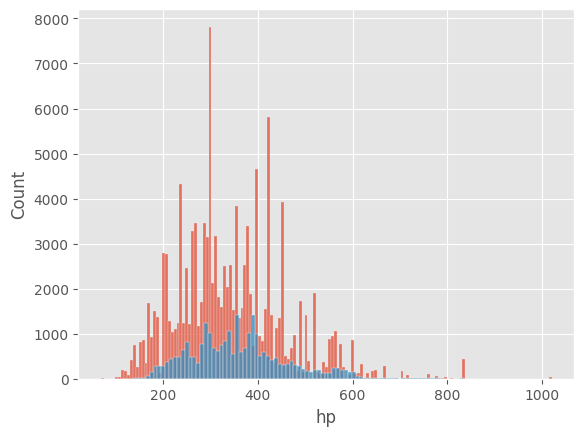

In [319]:
sns.histplot(y_train_hp)
sns.histplot(train.loc[x_predict_hp.index,'hp'])

In [321]:
## substituindo os valores faltantes de litros
train_litros = train[train['litros'].notnull()]
x_train_litros = train_litros[['price','hp','idade_carro','cilindros']]
y_train_litros = train_litros['litros']
pipe = Pipeline([('inputar', SimpleImputer(strategy='median')),
                 ('scaler', StandardScaler()), 
                 ('random_forest', RandomForestRegressor())])

pipe.fit(x_train_litros, y_train_litros)

x_predict_litros= train.loc[train['litros'].isnull(),['price','hp','idade_carro','cilindros']]

train.loc[x_predict_litros.index,'litros'] = pipe.predict(x_predict_litros)

In [324]:
## substituindo os valores faltantes de cilindros
train_cilindros = train[train['cilindros'].notnull()]
x_train_cilindros = train_cilindros[['price','hp','idade_carro','litros']]
y_train_cilindros = train_cilindros['cilindros']
pipe = Pipeline([('inputar', SimpleImputer(strategy='median')),
                 ('scaler', StandardScaler()), 
                 ('random_forest', RandomForestRegressor())])

pipe.fit(x_train_cilindros, y_train_cilindros)

x_predict_cilindros= train.loc[train['cilindros'].isnull(),['price','hp','idade_carro','litros']]

train.loc[x_predict_cilindros.index,'cilindros'] = pipe.predict(x_predict_cilindros)

In [333]:
train[train.fuel_type.isnull()]

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price,hp,litros,idade_carro,valvulas,cilindros
29,Tesla,Model X 100D,2018,59271,NaN,518.0HP Electric Motor Electric Fuel System,8-Speed A/T,Dark Gray Metallic,Brown,NaN,NaN,35000,518.000000,3.527,6,NaN,6.0
64,Tesla,Model 3 Long Range,2019,46250,NaN,425.0HP Electric Motor Electric Fuel System,1-Speed A/T,Red,Black,None reported,Yes,49995,425.000000,3.000,5,NaN,6.0
174,Tesla,Model Y Long Range,2023,13232,NaN,425.0HP Electric Motor Electric Fuel System,1-Speed A/T,White,White,None reported,Yes,46900,425.000000,3.000,1,NaN,6.0
191,Tesla,Model X P90D,2018,49872,NaN,Electric,1-Speed A/T,Black,Black,None reported,Yes,26000,335.141892,3.194,6,NaN,6.0
204,Mercedes-Benz,EQS 450+ Base,2019,111773,NaN,Electric,Automatic,Caspian Blue,Black,None reported,NaN,45861,391.214000,3.414,5,NaN,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150771,Tesla,Model X 100D,2018,25500,NaN,518.0HP Electric Motor Electric Fuel System,Transmission w/Dual Shift Mode,Gray,White,None reported,Yes,59500,518.000000,3.512,6,NaN,6.0
150773,Tesla,Model S Long Range Plus,2023,5844,NaN,425.0HP Electric Motor Electric Fuel System,1-Speed A/T,White,Black,None reported,Yes,66000,425.000000,3.000,1,NaN,6.0
150781,Tesla,Model Y Long Range,2022,8000,NaN,425.0HP Electric Motor Electric Fuel System,A/T,Green,White,None reported,Yes,83000,425.000000,3.000,2,NaN,6.0
150783,Kia,EV6 GT-Line,2020,63250,NaN,201.0HP Electric Motor Electric Fuel System,1-Speed A/T,White,Black,None reported,Yes,32000,201.000000,2.871,4,NaN,6.0
